# Codenames Analysis
Visualizations and analyses for Codenames.

In [2]:
# imports
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import numpy as np
from collections import defaultdict
import pandas as pd
import random
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.patches import Patch
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
from collections import Counter


In [3]:
random.seed(42)

In [4]:
# global params for consistency and readability of graphs
TITLE = 28
AXIS = 22
LABEL = 20
TICKS = 18
LEGEND = 13

plt.rcParams['figure.dpi'] = 600

In [5]:
# load data
def load_data():
    with open("boards-data-expanded.json", "r") as f:
        boards = json.load(f)
    with open("relatedness-data-expanded.json", "r") as f:
        relatedness = json.load(f)
    return boards, relatedness

# Correlations

In [6]:
# basic correlation graph (every point is a pairwise relatedness judgment, x axis is humans, y axis is LLMs)
def correlation_graph(data):
    relatedness = {}
    for entry in data:
        clue = entry["clue"]
        word = entry["word"]
        source = entry["source"]
        value = entry["relatedness"]
        if value is None:
            continue
        if isinstance(value, list):
            value = sum(value) / len(value)
        relatedness.setdefault(clue, {}).setdefault(word, {})[source] = value    
    # extract all pairs with both human and GPT ratings
    human_scores = []
    gpt_scores = []
    for clue in relatedness:
        for word in relatedness[clue]:
            word_data = relatedness[clue][word]
            if "human" in word_data and "gpt" in word_data:
                human_scores.append(word_data["human"])
                gpt_scores.append(word_data["gpt"])
    # plot
    plt.figure(figsize=(8, 8))
    sns.set(style="whitegrid")
    # scatter plot
    plt.scatter(human_scores, gpt_scores, alpha=0.6)
    # best-fit line
    sns.regplot(x=human_scores, y=gpt_scores, scatter=False, color='black', ci=None)
    # correlation
    r, _ = scipy.stats.pearsonr(human_scores, gpt_scores)
    n = len(human_scores)

    # compute t statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    print("n:", n)
    print("t-statistic:", t_stat)

    # compute log(p-value) safely in log-space
    log_p = scipy.stats.t.logsf(np.abs(t_stat), df=n-2) + np.log(2)
    import random

    shuffled = gpt_scores[:]
    random.shuffle(shuffled)
    r_shuffled, _ = scipy.stats.pearsonr(human_scores, shuffled)
    print("Correlation with shuffled GPT scores:", r_shuffled)
    print(f"r = {r:.6f}")
    print(f"log10(p) = {log_p / np.log(10):.2f}")
    plt.title(f"Human vs GPT Relatedness Judgments\nPearson r = {r:.2f}", fontsize = TITLE, fontweight='bold')
    plt.xlabel("Human Relatedness Judgment", fontsize = AXIS)
    plt.ylabel("GPT Relatedness Judgment", fontsize = AXIS)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()




In [7]:
def split_half_reliability(relatedness_data, n_iterations=1000):
    # find items that have both human and GPT data
    item_data = {}
    
    for entry in relatedness_data:
        if entry["relatedness"] is None:
            continue
            
        clue = entry["clue"]
        word = entry["word"]
        source = entry["source"]
        judgments = entry["relatedness"]
        
        item_key = (clue, word)
        if item_key not in item_data:
            item_data[item_key] = {}
            
        if isinstance(judgments, list):
            item_data[item_key][source] = judgments
        else:
            item_data[item_key][source] = [judgments]
    
    # filter to items that have both human and GPT data with sufficient human judgments
    valid_items = {}
    for item_key, sources in item_data.items():
        if ("human" in sources and "gpt" in sources and 
            len(sources["human"]) >= 4):  
            valid_items[item_key] = sources["human"]
    
    print(f"Found {len(item_data)} total items")
    print(f"Items with both human and GPT data: {sum(1 for sources in item_data.values() if 'human' in sources and 'gpt' in sources)}")
    print(f"Items with ≥4 human judgments AND GPT data: {len(valid_items)}")
    
    if len(valid_items) < 10:
        print("Warning: Very few items available for reliable split-half analysis")
        return []
    
    # perform split-half correlation n_iterations times
    correlations = []
    
    for i in range(n_iterations):
        half1_scores = []
        half2_scores = []
        
        for item_key, judgments in valid_items.items():
            # randomly split the human raters for this item
            shuffled_judgments = judgments.copy()
            random.shuffle(shuffled_judgments)
            
            half_size = len(shuffled_judgments) // 2
            if half_size == 0:  # skip items with too few judgments
                continue
                
            half1 = shuffled_judgments[:half_size]
            half2 = shuffled_judgments[half_size:]
            
            # calculate mean for each half
            half1_mean = sum(half1) / len(half1)
            half2_mean = sum(half2) / len(half2)
            
            half1_scores.append(half1_mean)
            half2_scores.append(half2_mean)
        
        # calculate correlation between the two halves
        if len(half1_scores) >= 10:  # need minimum items for meaningful correlation
            r, _ = pearsonr(half1_scores, half2_scores)
            if not np.isnan(r):
                correlations.append(r)
    
    return correlations

In [8]:
def human_gpt_correlation(relatedness_data, n_iterations=1000):
    item_data = {}
    for entry in relatedness_data:
        if entry["relatedness"] is None:
            continue
            
        clue = entry["clue"]
        word = entry["word"]
        source = entry["source"]
        judgments = entry["relatedness"]
        
        item_key = (clue, word)
        if item_key not in item_data:
            item_data[item_key] = {}
            
        if isinstance(judgments, list):
            item_data[item_key][source] = judgments
        else:
            item_data[item_key][source] = [judgments]
    
    # filter to items with both human (≥4 judgments) and GPT data
    valid_items = {}
    for item_key, sources in item_data.items():
        if ("human" in sources and "gpt" in sources and 
            len(sources["human"]) >= 4):
            valid_items[item_key] = sources
    
    print(f"Human-GPT correlation calculated on {len(valid_items)} items")
    
    # perform multiple iterations like split-half
    correlations = []
    
    for i in range(n_iterations):
        human_scores = []
        gpt_scores = []
        
        for item_key, sources in valid_items.items():
            # randomly sample half the human raters
            human_judgments = sources["human"].copy()
            random.shuffle(human_judgments)
            half_size = len(human_judgments) // 2
            
            if half_size == 0:
                continue
                
            human_half = human_judgments[:half_size]
            human_avg = sum(human_half) / len(human_half)
            
            # use all GPT judgments
            gpt_avg = sum(sources["gpt"]) / len(sources["gpt"])
            
            human_scores.append(human_avg)
            gpt_scores.append(gpt_avg)
        
        if len(human_scores) >= 10:
            r, _ = pearsonr(human_scores, gpt_scores)
            if not np.isnan(r):
                correlations.append(r)
    
    if correlations:
        mean_correlation = np.mean(correlations)
        return mean_correlation, correlations
    else:
        return None, []

In [9]:
def diagnostic_analysis(relatedness_data):
    print("Diagnostic Analysis")
    
    # count items by data availability
    item_counts = {}
    human_judgment_counts = []
    
    for entry in relatedness_data:
        if entry["relatedness"] is None:
            continue
            
        clue = entry["clue"]
        word = entry["word"]
        source = entry["source"]
        judgments = entry["relatedness"]
        
        item_key = (clue, word)
        if item_key not in item_counts:
            item_counts[item_key] = {"human": 0, "gpt": 0}
            
        item_counts[item_key][source] = 1
        
        if source == "human" and isinstance(judgments, list):
            human_judgment_counts.append(len(judgments))
    
    # Analyze availability
    both_sources = sum(1 for counts in item_counts.values() 
                      if counts["human"] > 0 and counts["gpt"] > 0)
    human_only = sum(1 for counts in item_counts.values() 
                    if counts["human"] > 0 and counts["gpt"] == 0)
    gpt_only = sum(1 for counts in item_counts.values() 
                  if counts["human"] == 0 and counts["gpt"] > 0)
    
    print(f"Total unique (clue, word) pairs: {len(item_counts)}")
    print(f"Items with both human and GPT: {both_sources}")
    print(f"Items with only human: {human_only}")
    print(f"Items with only GPT: {gpt_only}")
    
    if human_judgment_counts:
        print(f"Human judgments per item: min={min(human_judgment_counts)}, max={max(human_judgment_counts)}, avg={np.mean(human_judgment_counts):.1f}")
    
    return item_counts

In [10]:
def complete_analysis(relatedness_data):
    print("Running diagnostic analysis...")
    diagnostic_analysis(relatedness_data)
    print("\n" + "="*50 + "\n")
    
    print("Calculating split-half reliability...")
    split_half_corrs = split_half_reliability(relatedness_data, n_iterations=1000)
    
    print("\nCalculating human-GPT correlation (using same methodology)...")
    human_gpt_r, human_gpt_corrs = human_gpt_correlation(relatedness_data, n_iterations=1000)
    
    if split_half_corrs and human_gpt_r is not None:
        mean_reliability = np.mean(split_half_corrs)
        std_reliability = np.std(split_half_corrs)
        std_human_gpt = np.std(human_gpt_corrs)
        
        print(f"\nResults")
        print(f"Split-Half Reliability (human self-consistency):")
        print(f"  Mean: {mean_reliability:.3f}")
        print(f"  Std:  {std_reliability:.3f}")
        print(f"  Range: {min(split_half_corrs):.3f} to {max(split_half_corrs):.3f}")
        
        print(f"\nHuman-GPT Correlation:")
        print(f"  Mean: {human_gpt_r:.3f}")
        print(f"  Std:  {std_human_gpt:.3f}")
        print(f"  Range: {min(human_gpt_corrs):.3f} to {max(human_gpt_corrs):.3f}")
        
        percentage = (human_gpt_r / mean_reliability) * 100
        print(f"\nGPT achieves {percentage:.1f}% of theoretical maximum")

        
        # visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # distribution comparison
        ax1.hist(split_half_corrs, bins=30, alpha=0.7, label='Split-half reliability', color='red')
        ax1.hist(human_gpt_corrs, bins=30, alpha=0.7, label='Human-GPT correlation', color='blue')
        ax1.axvline(mean_reliability, color='red', linestyle='--', linewidth=2)
        ax1.axvline(human_gpt_r, color='blue', linestyle='--', linewidth=2)
        ax1.set_title("Comparison of Correlation Distributions")
        ax1.set_xlabel("Correlation Coefficient")
        ax1.set_ylabel("Frequency")
        ax1.legend()
        
        # summary comparison
        categories = ['Split-Half\nReliability', 'Human-GPT\nCorrelation']
        means = [mean_reliability, human_gpt_r]
        stds = [std_reliability, std_human_gpt]
        
        ax2.bar(categories, means, yerr=stds, capsize=5, alpha=0.7, 
               color=['red', 'blue'])
        ax2.set_title("Mean Correlations with Error Bars")
        ax2.set_ylabel("Correlation Coefficient")
        ax2.set_ylim(0, 1)
        
        # percentage annotation
        ax2.text(1, human_gpt_r + 0.05, f'{percentage:.1f}% of max', 
                ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'split_half_mean': mean_reliability,
            'human_gpt_mean': human_gpt_r,
            'percentage_of_maximum': percentage,
            'split_half_correlations': split_half_corrs,
            'human_gpt_correlations': human_gpt_corrs
        }
    else:
        print("Analysis failed - insufficient data")
        return None

n: 1852
t-statistic: 73.22228752838835
Correlation with shuffled GPT scores: -0.0018091394378282862
r = 0.862244
log10(p) = -inf


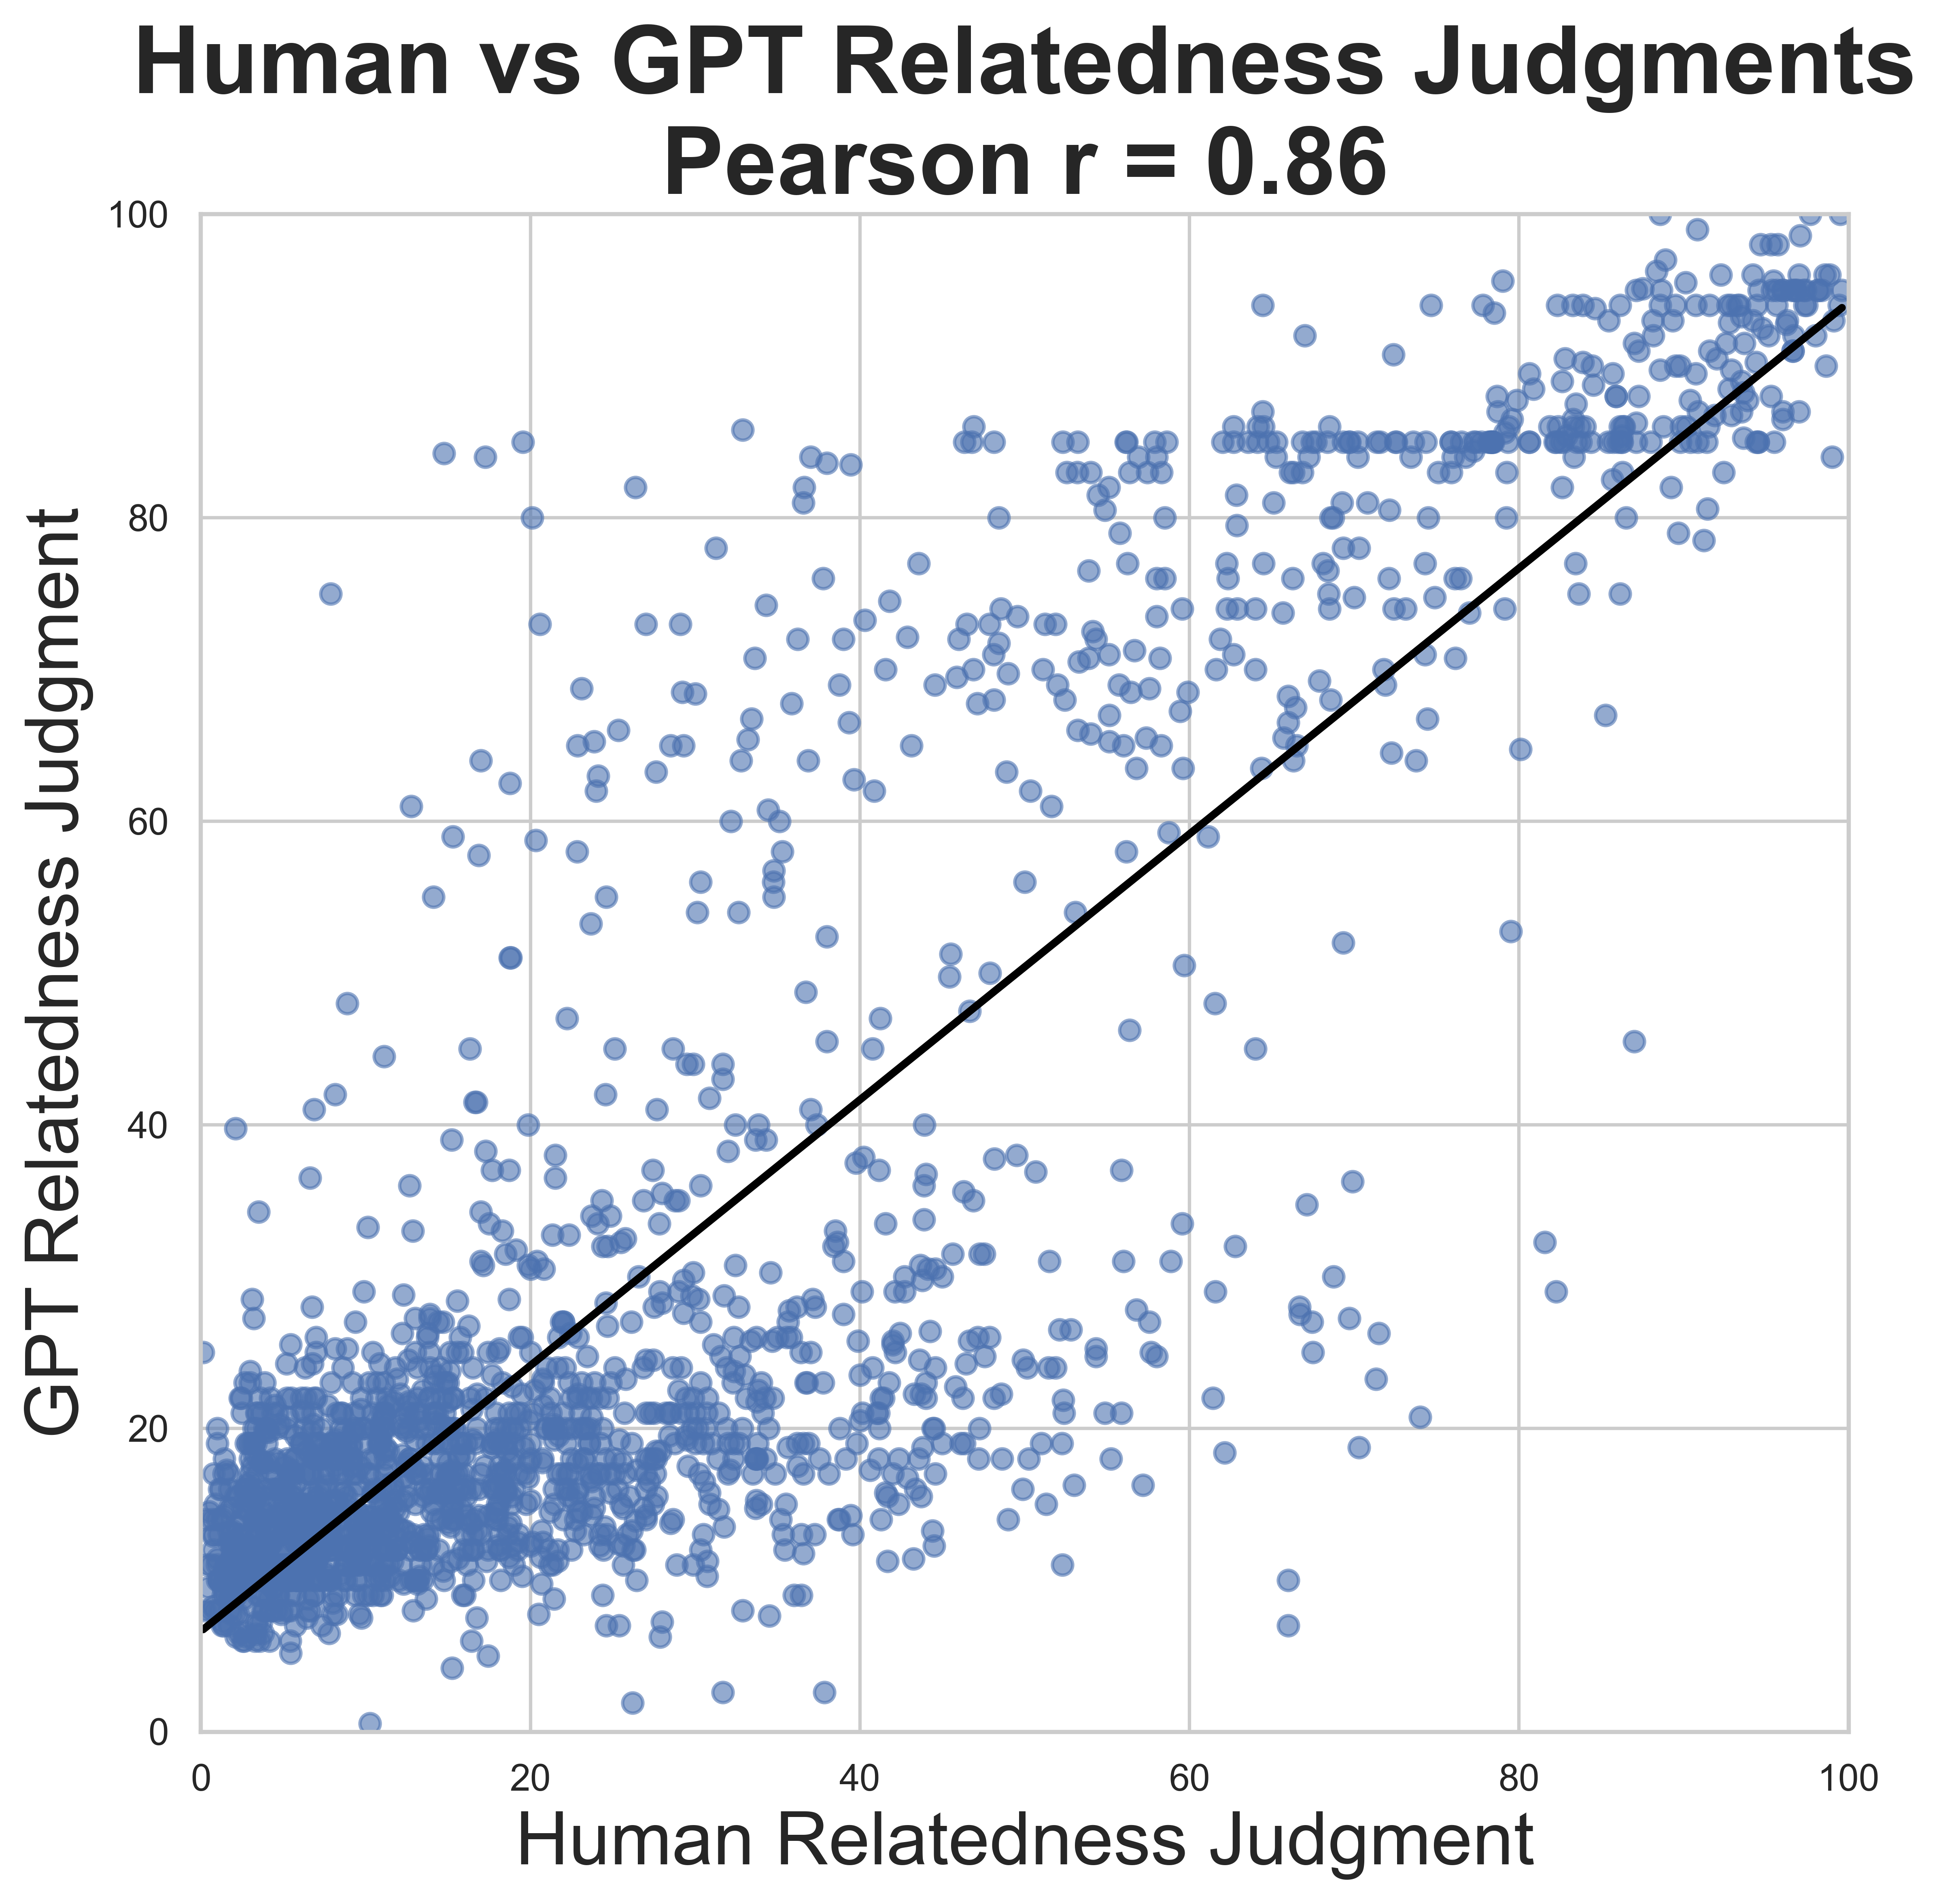

Running diagnostic analysis...
Diagnostic Analysis
Total unique (clue, word) pairs: 8471
Items with both human and GPT: 1852
Items with only human: 0
Items with only GPT: 6619
Human judgments per item: min=5, max=27, avg=8.9


Calculating split-half reliability...
Found 8471 total items
Items with both human and GPT data: 1852
Items with ≥4 human judgments AND GPT data: 931

Calculating human-GPT correlation (using same methodology)...
Human-GPT correlation calculated on 931 items

Results
Split-Half Reliability (human self-consistency):
  Mean: 0.835
  Std:  0.007
  Range: 0.813 to 0.859

Human-GPT Correlation:
  Mean: 0.831
  Std:  0.007
  Range: 0.804 to 0.850

GPT achieves 99.5% of theoretical maximum


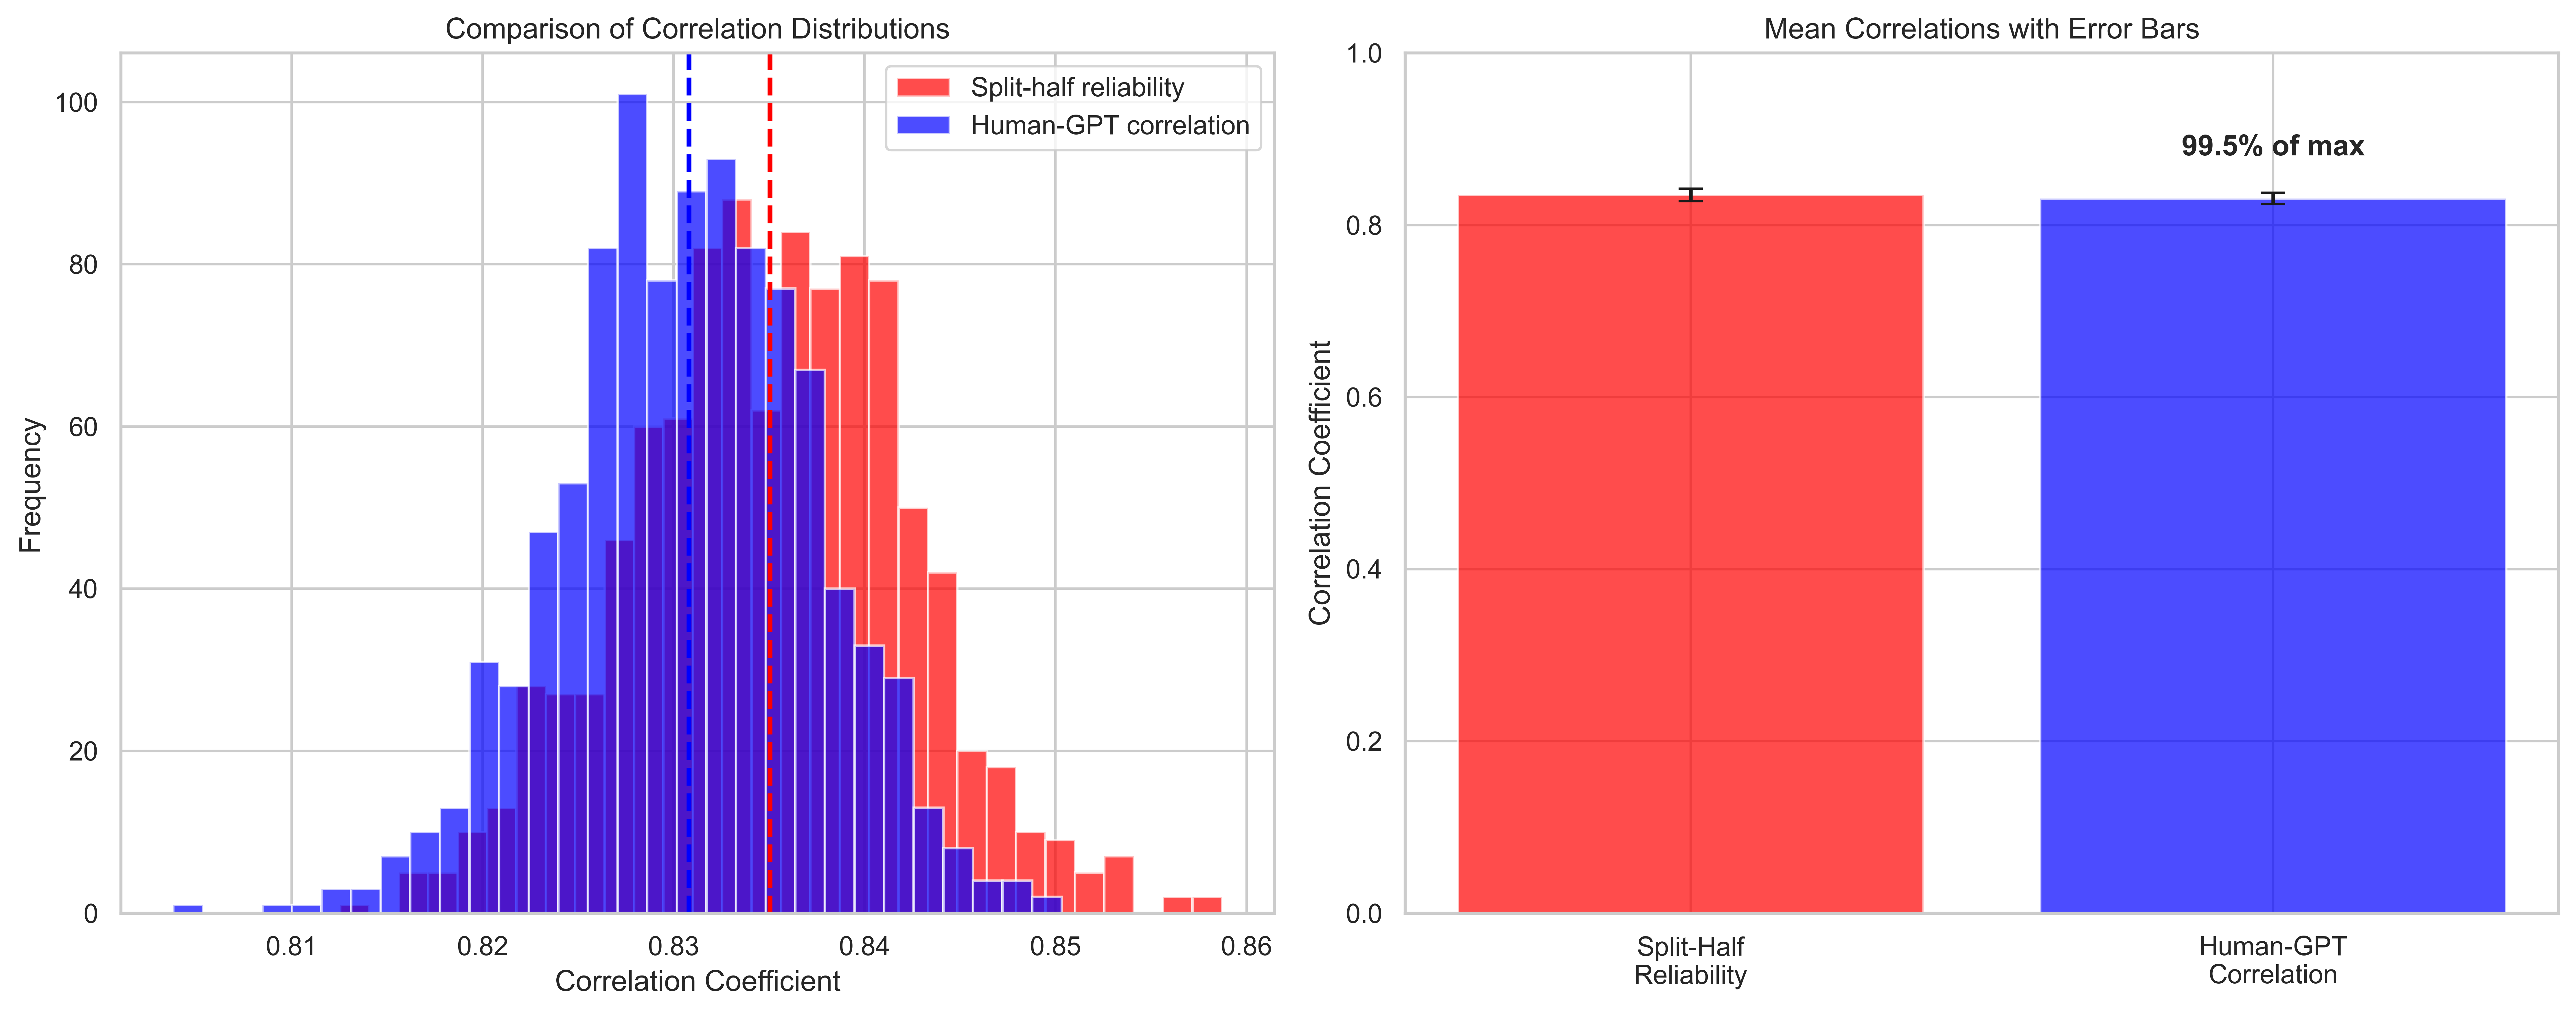

In [11]:
# load and process correlation
boards_data, relatedness_data = load_data()
correlation_graph(relatedness_data)
results = complete_analysis(relatedness_data)

# Performance Differences Between Participant and Clue Types

In [12]:
def calculate_accuracy(intended_words, responses):
    accuracy = []

    for res in responses:
        #print("res", res)

        # Ensure res is treated as a list
        if isinstance(res, str):  
            res = [res]  # Convert single word to list

        n_correct = len([w for w in res if w in intended_words])
        # print(n_correct)

        accuracy.append(n_correct / len(res))
    # print(sum(accuracy) / len(accuracy) if accuracy else 0)
    return sum(accuracy) / len(accuracy)

In [13]:
def load_and_process_data_violinplot(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    conditions = {
        'Human Guess\nGPT Clue': [],
        'Human Guess\nHuman Clue': [], 
        'GPT Guess\nGPT Clue': [],
        'GPT Guess\nHuman Clue': []
    }

    # dictionary to store board-level performance data
    board_performances = {}
    
    for board_key, board_data in data.items():
        board_performances[board_key] = {
            'words': board_data.get('words', []),
            'human_on_gpt': None,
            'human_on_human': None,
            'gpt_on_gpt': None,
            'gpt_on_human': None
        }

        # GPT clue conditions
        if 'gpt_intended_words' in board_data:
            gpt_intended = board_data['gpt_intended_words']
            
            # human guesses on GPT clues - average across human participants for this board
            if 'human_guess_gpt_clue' in board_data:
                human_guesses = board_data['human_guess_gpt_clue']
                if isinstance(human_guesses, list) and len(human_guesses) > 0:
                    #accuracies = [calculate_accuracy(guess, gpt_intended) for guess in human_guesses]
                    accuracies = [calculate_accuracy(gpt_intended, [guess]) for guess in human_guesses]                    
                    mean_accuracy = np.mean(accuracies)
                    conditions['Human Guess\nGPT Clue'].append(mean_accuracy)
                    board_performances[board_key]['human_on_gpt'] = mean_accuracy
            
            # GPT guesses on GPT clues - average across GPT participants for this board
            if 'gpt_guess_gpt_clue' in board_data:
                gpt_guesses = board_data['gpt_guess_gpt_clue']
                if isinstance(gpt_guesses, list) and len(gpt_guesses) > 0:
                    accuracies = [calculate_accuracy(gpt_intended, [guess]) for guess in gpt_guesses]                    
                    mean_accuracy = np.mean(accuracies)
                    conditions['GPT Guess\nGPT Clue'].append(mean_accuracy)
                    board_performances[board_key]['gpt_on_gpt'] = mean_accuracy
        
        # human clue conditions
        if 'human_intended_words' in board_data:
            human_intended = board_data['human_intended_words']
            
            # human guesses on Human clues - average across human participants for this board
            if 'human_guess_human_clue' in board_data:
                human_guesses = board_data['human_guess_human_clue']
                if isinstance(human_guesses, list) and len(human_guesses) > 0:
                    # accuracies = [calculate_accuracy(guess, human_intended) for guess in human_guesses]
                    accuracies = [calculate_accuracy(human_intended, [guess]) for guess in human_guesses]                    

                    mean_accuracy = np.mean(accuracies)
                    conditions['Human Guess\nHuman Clue'].append(mean_accuracy)
                    board_performances[board_key]['human_on_human'] = mean_accuracy

            
            # GPT guesses on human clues - average across GPT participants for this board
            if 'gpt_guess_human_clue' in board_data:
                gpt_guesses = board_data['gpt_guess_human_clue']
                if isinstance(gpt_guesses, list) and len(gpt_guesses) > 0:
                    accuracies = [calculate_accuracy(human_intended, [guess]) for guess in gpt_guesses]                    

                    #accuracies = [calculate_accuracy(guess, human_intended) for guess in gpt_guesses]
                    mean_accuracy = np.mean(accuracies)
                    conditions['GPT Guess\nHuman Clue'].append(mean_accuracy)
                    board_performances[board_key]['gpt_on_human'] = mean_accuracy
    
    with open('board_correctness.json', 'w') as f:
        json.dump(board_performances, f, indent=2)
    print("Board correctness data saved to board_correctness.json")
    
    return conditions

In [14]:
def create_violin_plot(conditions, save_path=None):
    data_rows = []
    
    for condition_name, accuracies in conditions.items():
        # parse the condition name to create the combined category
        if 'Human Guess\nGPT Clue' == condition_name:
            combined_condition = 'Human Guesser\nGPT Clue'
            clue_type = 'GPT Clues'
            guesser = 'Human'
        elif 'GPT Guess\nGPT Clue' == condition_name:
            combined_condition = 'GPT Guesser\nGPT Clue'
            clue_type = 'GPT Clues'
            guesser = 'GPT'
        elif 'Human Guess\nHuman Clue' == condition_name:
            combined_condition = 'Human Guesser\nHuman Clue'
            clue_type = 'Human Clues'
            guesser = 'Human'
        elif 'GPT Guess\nHuman Clue' == condition_name:
            combined_condition = 'GPT Guesser\nHuman Clue'
            clue_type = 'Human Clues'
            guesser = 'GPT'
        
        # Add each accuracy value as a row
        for accuracy in accuracies:
            data_rows.append({
                'Accuracy': accuracy,
                'Condition': combined_condition,
                'Clue_Type': clue_type,
                'Guesser': guesser
            })

    
    df = pd.DataFrame(data_rows)
    
    plt.figure(figsize=(12, 7))
    
    # create violin plot with the combined condition as x-axis
    ax = sns.violinplot(x='Condition', y='Accuracy', data=df, 
                      size=3, alpha=0.7, 
                      palette=['#3498db', '#e74c3c', '#3498db', '#e74c3c'],
                      order=['Human Guesser\nGPT Clue', 'GPT Guesser\nGPT Clue', 
                             'Human Guesser\nHuman Clue', 'GPT Guesser\nHuman Clue'])
    
    # customize the plot
    plt.title('Codenames Performance by Board', fontsize=TITLE, fontweight='600', pad=30)
    plt.ylabel('Accuracy', fontsize=AXIS)
    plt.xlabel('', fontsize=AXIS)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)
    # add group labels
    plt.text(0.5, -0.08, '', ha='center', va='top', fontsize=LABEL, fontweight='bold',
             transform=ax.transAxes)
    plt.text(0.5, -0.08, '', ha='center', va='top', fontsize=LABEL, fontweight='bold',
             transform=ax.transAxes)
    
    # separator line between clue types
    plt.axvline(x=1.5, color='gray', linestyle='--', alpha=0.5)
    
    conditions_order = ['Human Guesser\nGPT Clue', 'GPT Guesser\nGPT Clue', 
                       'Human Guesser\nHuman Clue', 'GPT Guesser\nHuman Clue']
    
    for i, condition in enumerate(conditions_order):
        subset = df[df['Condition'] == condition]
        if len(subset) > 0:
            mean_val = subset['Accuracy'].mean()
            n = len(subset)
            
            # position text above each plot
            plt.text(i, 1.02, f'n={n}\nμ={mean_val:.2f}', 
                    ha='center', va='bottom', fontsize=LABEL,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    # custom legend (kind of broken rn perhaps)
    legend_elements = [
        Patch(facecolor='#3498db', alpha=0.7, label='Human Guesser'),
        Patch(facecolor='#e74c3c', alpha=0.7, label='GPT Guesser')
    ]
    plt.legend(handles=legend_elements, loc='lower left', fontsize=LABEL)
    
    plt.tight_layout()
    
    # save
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    return plt.gcf(), plt.gca()

def print_summary_statistics(conditions):
    """Print summary statistics for each condition"""
    print("=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    for condition, accuracies in conditions.items():
        if len(accuracies) > 0:
            mean_acc = np.mean(accuracies)
            std_acc = np.std(accuracies)
            median_acc = np.median(accuracies)
            n = len(accuracies)
            
            print(f"\n{condition}:")
            print(f"  Sample size: {n}")
            print(f"  Mean accuracy: {mean_acc:.3f} ± {std_acc:.3f}")
            print(f"  Median accuracy: {median_acc:.3f}")
            print(f"  Range: [{min(accuracies):.3f}, {max(accuracies):.3f}]")

In [15]:
def find_boards_with_specific_accuracy(filename='boards-data-expanded.json', target_accuracy=0.67, condition='human_guess_gpt_clue'):
# this allows debug of results, exploration of banding
    with open(filename, 'r') as f:
        data = json.load(f)
    
    matching_boards = []
    
    for board_key, board_data in data.items():
        if condition == 'human_guess_gpt_clue' and 'human_guess_gpt_clue' in board_data:
            guesses = board_data['human_guess_gpt_clue']
            intended = board_data['gpt_intended_words']
            mean_acc = np.mean([calculate_accuracy(guess, intended) for guess in guesses])
            if abs(mean_acc - target_accuracy) < 0.01:  # Close to target
                matching_boards.append((board_key, board_data, mean_acc))
    
    print(f"Found {len(matching_boards)} boards with {condition} accuracy ≈ {target_accuracy}")
    
    for i, (board_key, board_data, acc) in enumerate(matching_boards[:3]):  # Show first 3
        print(f"\nBoard {i+1} (accuracy: {acc:.3f}):")
        print(f"Words: {board_data['words']}")
        print(f"Clue: '{board_data['gpt_clue']}'")
        print(f"Intended: {board_data['gpt_intended_words']}")
        print("Guesses:")
        for j, guess in enumerate(board_data['human_guess_gpt_clue']):
            acc_individual = calculate_accuracy(guess, board_data['gpt_intended_words'])
            print(f"  {guess} → {acc_individual:.2f}")


In [16]:
def interpret_cohens_d(d):
    # debug function; removable
    if d < 0.2:
        return "negligible"
    elif d < 0.5:
        return "small"
    elif d < 0.8:
        return "medium"
    else:
        return "large"

In [17]:
def perform_statistical_tests(conditions):
    """Perform t-tests and other statistical comparisons between conditions"""
    print("=" * 80)
    print("STATISTICAL TESTS")
    print("=" * 80)
    
    # convert condition names for easier reference
    condition_mapping = {
        'Human Guess\nGPT Clue': 'Human_GPT_Clue',
        'GPT Guess\nGPT Clue': 'GPT_GPT_Clue', 
        'Human Guess\nHuman Clue': 'Human_Human_Clue',
        'GPT Guess\nHuman Clue': 'GPT_Human_Clue'
    }
    
    # create arrays for easier manipulation
    condition_data = {}
    for orig_name, short_name in condition_mapping.items():
        if len(conditions[orig_name]) > 0:
            condition_data[short_name] = np.array(conditions[orig_name])
    
    print("\n1. PAIRWISE T-TESTS (Independent samples)")
    print("-" * 50)
    
    # perform all pairwise t-tests
    condition_names = list(condition_data.keys())
    comparisons = []
    
    for i, cond1 in enumerate(condition_names):
        for j, cond2 in enumerate(condition_names):
            if i < j:  # avoid duplicate comparisons
                data1 = condition_data[cond1]
                data2 = condition_data[cond2]
                
                # independent samples t-test
                t_stat, p_value = scipy.stats.ttest_ind(data1, data2)
                
                # effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                                    (len(data2) - 1) * np.var(data2, ddof=1)) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
                
                # quick interpretation
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                
                comparisons.append({
                    'comparison': f"{cond1} vs {cond2}",
                    't_stat': t_stat,
                    'p_value': p_value,
                    'cohens_d': cohens_d,
                    'significance': significance
                })
                
                print(f"{cond1} vs {cond2}:")
                print(f"  t-statistic: {t_stat:.4f}")
                print(f"  p-value: {p_value:.6f} {significance}")
                print(f"  Cohen's d: {cohens_d:.4f}")
                print(f"  Effect size: {interpret_cohens_d(abs(cohens_d))}")
                print()
    
    print("\n2. SPECIFIC COMPARISON TESTING")
    print("-" * 50)
    

    hypotheses = [
        ("Human vs GPT Guessers (GPT Clues)", "Human_GPT_Clue", "GPT_GPT_Clue"),
        ("Human vs GPT Guessers (Human Clues)", "Human_Human_Clue", "GPT_Human_Clue"),
        ("GPT vs Human Clues (Human Guessers)", "Human_GPT_Clue", "Human_Human_Clue"),
        ("GPT vs Human Clues (GPT Guessers)", "GPT_GPT_Clue", "GPT_Human_Clue")
    ]
    
    for hypothesis, cond1, cond2 in hypotheses:
        if cond1 in condition_data and cond2 in condition_data:
            data1 = condition_data[cond1]
            data2 = condition_data[cond2]
            
            t_stat, p_value = scipy.stats.ttest_ind(data1, data2)
            
            print(f"{hypothesis}:")
            print(f"  Mean difference: {np.mean(data1) - np.mean(data2):.4f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
            print()
    
    
    print("\n3. ONE-WAY ANOVA")
    print("-" * 50)
    
    # prepare data for ANOVA
    all_data = []
    all_labels = []
    for name, data in condition_data.items():
        all_data.extend(data)
        all_labels.extend([name] * len(data))
    
    # perform one-way ANOVA
    groups = [condition_data[name] for name in condition_names]
    f_stat, p_value = scipy.stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Significant overall difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # calculate eta-squared (effect size for ANOVA)
    df_between = len(groups) - 1
    df_within = len(all_data) - len(groups)
    eta_squared = (f_stat * df_between) / (f_stat * df_between + df_within)
    print(f"Eta-squared (effect size): {eta_squared:.4f}")
    
    return comparisons

In [18]:

def create_statistical_summary_table(comparisons):
    """Create a summary table of statistical comparisons"""
    print("\nSTATISTICAL COMPARISON SUMMARY TABLE")
    print("-" * 80)
    print(f"{'Comparison':<35} {'t-stat':<8} {'p-value':<10} {'Cohen d':<10} {'Sig.':<5}")
    print("-" * 80)
    
    for comp in comparisons:
        print(f"{comp['comparison']:<35} {comp['t_stat']:<8.3f} {comp['p_value']:<10.6f} "
              f"{comp['cohens_d']:<10.3f} {comp['significance']:<5}")
    
    print("\n* p < 0.05, ** p < 0.01, *** p < 0.001, ns = not significant")

In [19]:
def create_bar_plot(conditions, save_path=None):
    """Create a bar plot with error bars showing mean accuracy and confidence intervals"""
    
    # Calculate statistics for each condition
    condition_stats = {}
    for condition_name, accuracies in conditions.items():
        if len(accuracies) > 0:
            mean_acc = np.mean(accuracies)
            std_acc = np.std(accuracies, ddof=1)  # Sample standard deviation
            n = len(accuracies)
            
            # Calculate 95% confidence interval for the mean
            confidence_level = 0.95
            degrees_freedom = n - 1
            confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, 
                                                        mean_acc, std_acc/np.sqrt(n))
            margin_error = confidence_interval[1] - mean_acc
            
            condition_stats[condition_name] = {
                'mean': mean_acc,
                'std': std_acc,
                'n': n,
                'sem': std_acc / np.sqrt(n),  # Standard error of the mean
                'ci_margin': margin_error
            }
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Define order and labels
    conditions_order = ['Human Guess\nGPT Clue', 'GPT Guess\nGPT Clue', 
                       'Human Guess\nHuman Clue', 'GPT Guess\nHuman Clue']
    
    condition_labels = ['Human Guesser\nGPT Clue', 'GPT Guesser\nGPT Clue', 
                       'Human Guesser\nHuman Clue', 'GPT Guesser\nHuman Clue']
    
    # Colors: Blue for Human guessers, Red for GPT guessers
    colors = ['#3498db', '#e74c3c', '#3498db', '#e74c3c']
    
    # Extract data for plotting
    means = [condition_stats[cond]['mean'] for cond in conditions_order if cond in condition_stats]
    errors = [condition_stats[cond]['ci_margin'] for cond in conditions_order if cond in condition_stats]
    ns = [condition_stats[cond]['n'] for cond in conditions_order if cond in condition_stats]
    labels = [condition_labels[i] for i, cond in enumerate(conditions_order) if cond in condition_stats]
    plot_colors = [colors[i] for i, cond in enumerate(conditions_order) if cond in condition_stats]
    
    # Create the bar plot
    x_positions = np.arange(len(means))
    bars = plt.bar(x_positions, means, yerr=errors, capsize=8, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.2,
                   error_kw={'elinewidth': 2, 'ecolor': 'black', 'alpha': 0.8})
    
    # Customize the plot
    plt.title('Codenames Performance by Condition', fontsize=TITLE, fontweight='600', pad=30)
    plt.ylabel('Mean Accuracy', fontsize=AXIS)
    plt.xlabel('', fontsize=AXIS)
    
    # Set y-axis with fine-grained scale (0.1 increments)
    plt.ylim(0.65, 0.85)  # Adjust based on your data range
    plt.yticks(np.arange(0.65, 0.86, 0.05))  # 0.05 increments for readability
    
    # Add horizontal grid lines
    plt.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.8)
    
    # Set x-axis labels
    plt.xticks(x_positions, labels, fontsize=TICKS)
    
    # Add value labels on top of bars
    for i, (bar, mean_val, n, error) in enumerate(zip(bars, means, ns, errors)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error + 0.005,
                f'{mean_val:.3f}\n(n={n})', 
                ha='center', va='bottom', fontsize=LABEL, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Add a separator line between clue types
    if len(means) >= 3:
        plt.axvline(x=1.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add group labels
        # plt.text(0.75, 0.66, 'GPT Clues', ha='center', va='center', fontsize=12, 
        #         fontweight='bold', style='italic',
        #         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.7))
        # plt.text(2.25, 0.66, 'Human Clues', ha='center', va='center', fontsize=12, 
        #         fontweight='bold', style='italic',
        #         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightcoral', alpha=0.7))
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='#3498db', alpha=0.8, label='Human Guesser'),
        Patch(facecolor='#e74c3c', alpha=0.8, label='GPT Guesser')
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=LABEL, framealpha=0.9)
    
    # # Add note about error bars
    # plt.text(0.02, 0.02, 'Error bars show 95% confidence intervals', 
    #          transform=plt.gca().transAxes, fontsize=9, style='italic',
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the plot
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    return plt.gcf(), plt.gca()

In [20]:
def calculate_human_guesser_agreement(filename='boards-data-expanded.json'):
    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    all_differences = []
    board_count = 0
    
    print("Analyzing human guesser agreement on human clues...")
    print("=" * 60)
    
    for board_key, board_data in data.items():
        # Only look at human guesses on human clues
        if 'human_guess_human_clue' in board_data and 'human_intended_words' in board_data:
            human_guesses = board_data['human_guess_human_clue']
            
            # Need at least 2 human guesses to compare
            if isinstance(human_guesses, list) and len(human_guesses) >= 2:
                board_count += 1
                board_differences = []
                
                # Compare all pairs of human guesses for this board
                # Each guess is a triplet like ["CAT", "WITCH", "TIME"]
                for i, guess1 in enumerate(human_guesses):
                    for j, guess2 in enumerate(human_guesses):
                        if i < j:  # Avoid duplicate comparisons
                            # Convert triplets to sets for comparison
                            set1 = set(guess1)  # e.g., {"CAT", "WITCH", "TIME"}
                            set2 = set(guess2)  # e.g., {"WITCH", "CAT", "PILOT"}
                            
                            # Calculate position differences (how many word choices they disagree on)
                            # This is: total_positions - number_of_shared_words
                            intersection = set1.intersection(set2)
                            different_positions = 3 - len(intersection)
                            board_differences.append(different_positions)
                            
                            # Debug print for first few comparisons
                            if board_count == 1 and len(board_differences) <= 3:
                                shared_words = len(intersection)
                                print(f"    Comparing {list(set1)} vs {list(set2)}: {shared_words} shared, {different_positions} different positions")
                
                if board_differences:
                    # Average difference for this board
                    avg_board_diff = np.mean(board_differences)
                    all_differences.append(avg_board_diff)
                    
                    print(f"Board {board_key}: {len(human_guesses)} human guesses, "
                          f"avg difference = {avg_board_diff:.2f} positions")
    
    if all_differences:
        overall_avg_difference = np.mean(all_differences)
        std_difference = np.std(all_differences)
        
        print("\n" + "=" * 60)
        print("RESULTS:")
        print("=" * 60)
        print(f"Boards analyzed: {board_count}")
        print(f"Average difference between human guessers: {overall_avg_difference:.3f} positions")
        print(f"Standard deviation: {std_difference:.3f} positions")
        print(f"Range: {min(all_differences):.2f} - {max(all_differences):.2f} positions")
        
        # Round to reasonable precision for the statement
        X_value = round(overall_avg_difference, 1)
        print(f"\nValue of X for your statement: {X_value}")
        print(f"\nStatement: \"Guessers for the same clue and board differed in their")
        print(f"selected words by less than {X_value} positions on average, supporting the idea")
        print(f"that participants used similar cognitive strategies...\"")
        
        # Show distribution of differences
        print(f"\nDistribution of position differences:")
        diff_counts = {}
        for diff in all_differences:
            rounded_diff = round(diff)
            diff_counts[rounded_diff] = diff_counts.get(rounded_diff, 0) + 1
        
        for i in range(4):  # 0, 1, 2, 3 positions can differ
            count = diff_counts.get(i, 0)
            percent = (count / len(all_differences) * 100) if all_differences else 0
            print(f"  {i} position differences: {count} board pairs ({percent:.1f}%)")
        
        return {
            'average_difference': overall_avg_difference,
            'X_value': X_value,
            'std_deviation': std_difference,
            'boards_analyzed': board_count,
            'all_differences': all_differences
        }
    else:
        print("No valid comparisons found!")
        return None


In [21]:
calculate_human_guesser_agreement('boards-data-expanded.json')

Analyzing human guesser agreement on human clues...
    Comparing ['WEB', 'BEAR', 'MOUSE'] vs ['BAT', 'BEAR', 'MOUSE']: 2 shared, 1 different positions
    Comparing ['WEB', 'BEAR', 'MOUSE'] vs ['BAT', 'BEAR', 'MOUSE']: 2 shared, 1 different positions
    Comparing ['WEB', 'BEAR', 'MOUSE'] vs ['BAT', 'BEAR', 'MOUSE']: 2 shared, 1 different positions
Board ('WEB', 'BAT', 'TELESCOPE', 'WATER', 'MOUSE', 'BERLIN', 'JAM', 'CLUB', 'IRON', 'TUBE', 'IVORY', 'BEAR'): 12 human guesses, avg difference = 0.17 positions
Board ('PAN', 'WASHINGTON', 'TOKYO', 'KETCHUP', 'KID', 'EMBASSY', 'SPIKE', 'ALPS', 'EUROPE', 'CAR', 'FORK', 'MILLIONAIRE'): 6 human guesses, avg difference = 0.00 positions
Board ('MILLIONAIRE', 'PLATYPUS', 'FENCE', 'SPRING', 'WATER', 'AMERICA', 'LUCK', 'LONDON', 'NOVEL', 'DECK', 'ICE', 'CLOAK'): 14 human guesses, avg difference = 1.23 positions
Board ('CRICKET', 'PAN', 'FENCE', 'STRAW', 'EYE', 'GRACE', 'VAN', 'GLASS', 'BOLT', 'MATCH', 'HORN', 'CYCLE'): 10 human guesses, avg differe

{'average_difference': 0.729898370892953,
 'X_value': 0.7,
 'std_deviation': 0.4479296111985368,
 'boards_analyzed': 400,
 'all_differences': [0.16666666666666666,
  0.0,
  1.2307692307692308,
  0.2,
  0.8,
  0.44871794871794873,
  1.0,
  0.2,
  0.9636363636363636,
  0.9722222222222222,
  0.6916666666666667,
  0.8484848484848485,
  1.0606060606060606,
  0.0,
  0.0,
  0.0,
  1.4444444444444444,
  0.8545454545454545,
  0.0,
  1.1090909090909091,
  0.2222222222222222,
  0.4,
  1.6666666666666667,
  0.6,
  1.018181818181818,
  0.7222222222222222,
  0.2222222222222222,
  1.25,
  0.0,
  1.9333333333333333,
  0.9111111111111111,
  0.8181818181818182,
  0.2857142857142857,
  0.14285714285714285,
  1.6794871794871795,
  1.3818181818181818,
  0.6944444444444444,
  1.0065359477124183,
  0.8214285714285714,
  0.6111111111111112,
  1.0256410256410255,
  1.5,
  0.9333333333333333,
  0.75,
  0.4358974358974359,
  0.4444444444444444,
  0.8791208791208791,
  0.8681318681318682,
  0.8181818181818182,
  

In [22]:
def calculate_performance_basic(filename='boards-data-expanded.json'):
# calculate average percentage of words correct and percentage of trials with all 3 words correct
    with open(filename, 'r') as f:
        data = json.load(f)
    
    print("="*80)
    print("BASIC PERFORMANCE METRICS")
    print("="*80)
    
    conditions_detailed = {
        'Human Guess GPT Clue': [],
        'GPT Guess GPT Clue': [],
        'Human Guess Human Clue': [],
        'GPT Guess Human Clue': []
    }
    
    # track perfect scores (where all 3 guess words are correct targets)
    perfect_scores = {
        'Human Guess GPT Clue': 0,
        'GPT Guess GPT Clue': 0,
        'Human Guess Human Clue': 0,
        'GPT Guess Human Clue': 0
    }
    
    total_trials = {
        'Human Guess GPT Clue': 0,
        'GPT Guess GPT Clue': 0,
        'Human Guess Human Clue': 0,
        'GPT Guess Human Clue': 0
    }
    
    gpt_gpt_responses_per_clue = []
    for board_key, board_data in data.items():
        if 'gpt_guess_gpt_clue' in board_data:
            gpt_guesses = board_data['gpt_guess_gpt_clue']
            if isinstance(gpt_guesses, list):
                gpt_gpt_responses_per_clue.append(len(gpt_guesses))

    avg_responses_per_clue = np.mean(gpt_gpt_responses_per_clue) if gpt_gpt_responses_per_clue else 0

    for board_key, board_data in data.items():
        
        # GPT clue conditions
        if 'gpt_intended_words' in board_data:
            gpt_intended = board_data['gpt_intended_words']
            
            # Human guesses on GPT clues
            if 'human_guess_gpt_clue' in board_data:
                human_guesses = board_data['human_guess_gpt_clue']
                if isinstance(human_guesses, list):
                    for guess in human_guesses:
                        if isinstance(guess, list) and len(guess) > 0:
                            # Calculate number of correct words (out of 3)
                            guess_set = set(guess)
                            intended_set = set(gpt_intended)
                            n_correct = len(guess_set.intersection(intended_set))
                            
                            accuracy = n_correct / 3.0
                            conditions_detailed['Human Guess GPT Clue'].append(accuracy)
                            total_trials['Human Guess GPT Clue'] += 1
                            
                            # Check if all 3 correct
                            if n_correct == 3:
                                perfect_scores['Human Guess GPT Clue'] += 1
            
            # GPT guesses on GPT clues
            if 'gpt_guess_gpt_clue' in board_data:
                gpt_guesses = board_data['gpt_guess_gpt_clue']
                if isinstance(gpt_guesses, list):
                    for guess in gpt_guesses:
                        if isinstance(guess, list) and len(guess) > 0:
                            guess_set = set(guess)
                            intended_set = set(gpt_intended)
                            n_correct = len(guess_set.intersection(intended_set))
                            
                            accuracy = n_correct / 3.0
                            conditions_detailed['GPT Guess GPT Clue'].append(accuracy)
                            total_trials['GPT Guess GPT Clue'] += 1
                            
                            if n_correct == 3:
                                perfect_scores['GPT Guess GPT Clue'] += 1
        
        # Human clue conditions
        if 'human_intended_words' in board_data:
            human_intended = board_data['human_intended_words']
            
            # Human guesses on human clues
            if 'human_guess_human_clue' in board_data:
                human_guesses = board_data['human_guess_human_clue']
                if isinstance(human_guesses, list):
                    for guess in human_guesses:
                        if isinstance(guess, list) and len(guess) > 0:
                            guess_set = set(guess)
                            intended_set = set(human_intended)
                            n_correct = len(guess_set.intersection(intended_set))
                            
                            accuracy = n_correct / 3.0
                            conditions_detailed['Human Guess Human Clue'].append(accuracy)
                            total_trials['Human Guess Human Clue'] += 1
                            
                            if n_correct == 3:
                                perfect_scores['Human Guess Human Clue'] += 1
            
            # GPT guesses on human clues
            if 'gpt_guess_human_clue' in board_data:
                gpt_guesses = board_data['gpt_guess_human_clue']
                if isinstance(gpt_guesses, list):
                    for guess in gpt_guesses:
                        if isinstance(guess, list) and len(guess) > 0:
                            guess_set = set(guess)
                            intended_set = set(human_intended)
                            n_correct = len(guess_set.intersection(intended_set))
                            
                            accuracy = n_correct / 3.0
                            conditions_detailed['GPT Guess Human Clue'].append(accuracy)
                            total_trials['GPT Guess Human Clue'] += 1
                            
                            if n_correct == 3:
                                perfect_scores['GPT Guess Human Clue'] += 1
    
    print("-" * 50)
    
    for condition, accuracies in conditions_detailed.items():
        if len(accuracies) > 0:
            # average percentage of words correct
            avg_accuracy = np.mean(accuracies)
            avg_percentage = avg_accuracy * 100
            
            # percentage of trials with all 3 guesses correct
            n_trials = total_trials[condition]
            n_perfect = perfect_scores[condition]
            perfect_percentage = (n_perfect / n_trials) * 100 if n_trials > 0 else 0
            
            print(f"\n{condition}:")
            print(f"  Total trials: {n_trials}")
            print(f"  Average words correct: {avg_percentage:.4f}% (vs 25% chance)")
            print(f"  All 3 words correct: {perfect_percentage:.4f}% of trials (vs 0.45% chance)")
            print(f"  Perfect trials: {n_perfect}/{n_trials}")
    
    print(f"\nCHANCE PERFORMANCE VERIFICATION:")
    print(f"-" * 50)
    print(f"Single word chance: 3 correct out of ~25 total words = ~12% per word")
    print(f"Average words correct by chance: 3 words × 12% = ~36% total")
    print(f"All 3 words correct by chance: 0.12³ = {(0.12**3)*100:.2f}%")
    print(f"Note: Exact chance depends on total vocabulary size in each game")
    
    # GPT-GPT performance
    gpt_gpt_accuracies = conditions_detailed['GPT Guess GPT Clue']
    gpt_gpt_trials = total_trials['GPT Guess GPT Clue']
    gpt_gpt_perfect = perfect_scores['GPT Guess GPT Clue']
    
    if len(gpt_gpt_accuracies) > 0:
        avg_words_correct = np.mean(gpt_gpt_accuracies) * 100
        perfect_rate = (gpt_gpt_perfect / gpt_gpt_trials) * 100
        
        print(f"\n" + "="*60)
        print(f"="*60)
        print(f"Partnerships between spymasters and guessers were generally successful,")
        print(f"with guessers guessing {avg_words_correct:.4f}% of words correctly on average,")
        print(f"compared to chance performance at 25%. Additionally, guessers got all 3")
        print(f"words correct on {perfect_rate:.4f}% of trials, with chance performance at just 0.45%.")

        print(avg_responses_per_clue)
        total_gpt_queries = sum(gpt_gpt_responses_per_clue) if gpt_gpt_responses_per_clue else 0
        print(total_gpt_queries)
        return {
            'avg_words_correct': avg_words_correct,
            'perfect_rate': perfect_rate,
            'total_trials': gpt_gpt_trials,
            'perfect_trials': gpt_gpt_perfect,
        }

In [23]:
calculate_performance_basic()

BASIC PERFORMANCE METRICS
--------------------------------------------------

Human Guess GPT Clue:
  Total trials: 2327
  Average words correct: 73.4852% (vs 25% chance)
  All 3 words correct: 33.4766% of trials (vs 0.45% chance)
  Perfect trials: 779/2327

GPT Guess GPT Clue:
  Total trials: 2320
  Average words correct: 79.2385% (vs 25% chance)
  All 3 words correct: 43.4914% of trials (vs 0.45% chance)
  Perfect trials: 1009/2320

Human Guess Human Clue:
  Total trials: 4009
  Average words correct: 79.2134% (vs 25% chance)
  All 3 words correct: 47.6677% of trials (vs 0.45% chance)
  Perfect trials: 1911/4009

GPT Guess Human Clue:
  Total trials: 4009
  Average words correct: 79.7539% (vs 25% chance)
  All 3 words correct: 47.3435% of trials (vs 0.45% chance)
  Perfect trials: 1898/4009

CHANCE PERFORMANCE VERIFICATION:
--------------------------------------------------
Single word chance: 3 correct out of ~25 total words = ~12% per word
Average words correct by chance: 3 words ×

{'avg_words_correct': 79.23850574712642,
 'perfect_rate': 43.49137931034483,
 'total_trials': 2320,
 'perfect_trials': 1009}

Board correctness data saved to board_correctness.json
SUMMARY STATISTICS

Human Guess
GPT Clue:
  Sample size: 400
  Mean accuracy: 0.739 ± 0.165
  Median accuracy: 0.733
  Range: [0.000, 1.000]

Human Guess
Human Clue:
  Sample size: 400
  Mean accuracy: 0.790 ± 0.149
  Median accuracy: 0.795
  Range: [0.278, 1.000]

GPT Guess
GPT Clue:
  Sample size: 400
  Mean accuracy: 0.793 ± 0.175
  Median accuracy: 0.750
  Range: [0.000, 1.000]

GPT Guess
Human Clue:
  Sample size: 400
  Mean accuracy: 0.798 ± 0.192
  Median accuracy: 0.757
  Range: [0.278, 1.000]
STATISTICAL TESTS

1. PAIRWISE T-TESTS (Independent samples)
--------------------------------------------------
Human_GPT_Clue vs GPT_GPT_Clue:
  t-statistic: -4.4186
  p-value: 0.000011 ***
  Cohen's d: -0.3124
  Effect size: small

Human_GPT_Clue vs Human_Human_Clue:
  t-statistic: -4.5524
  p-value: 0.000006 ***
  Cohen's d: -0.3219
  Effect size: small

Human_GPT_Clue vs GPT_Human_Clue:
  t-statistic: -4.6199
  p-value: 0.000004 *

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Visualization complete! Plot saved as 'codenames_violinplot.png'


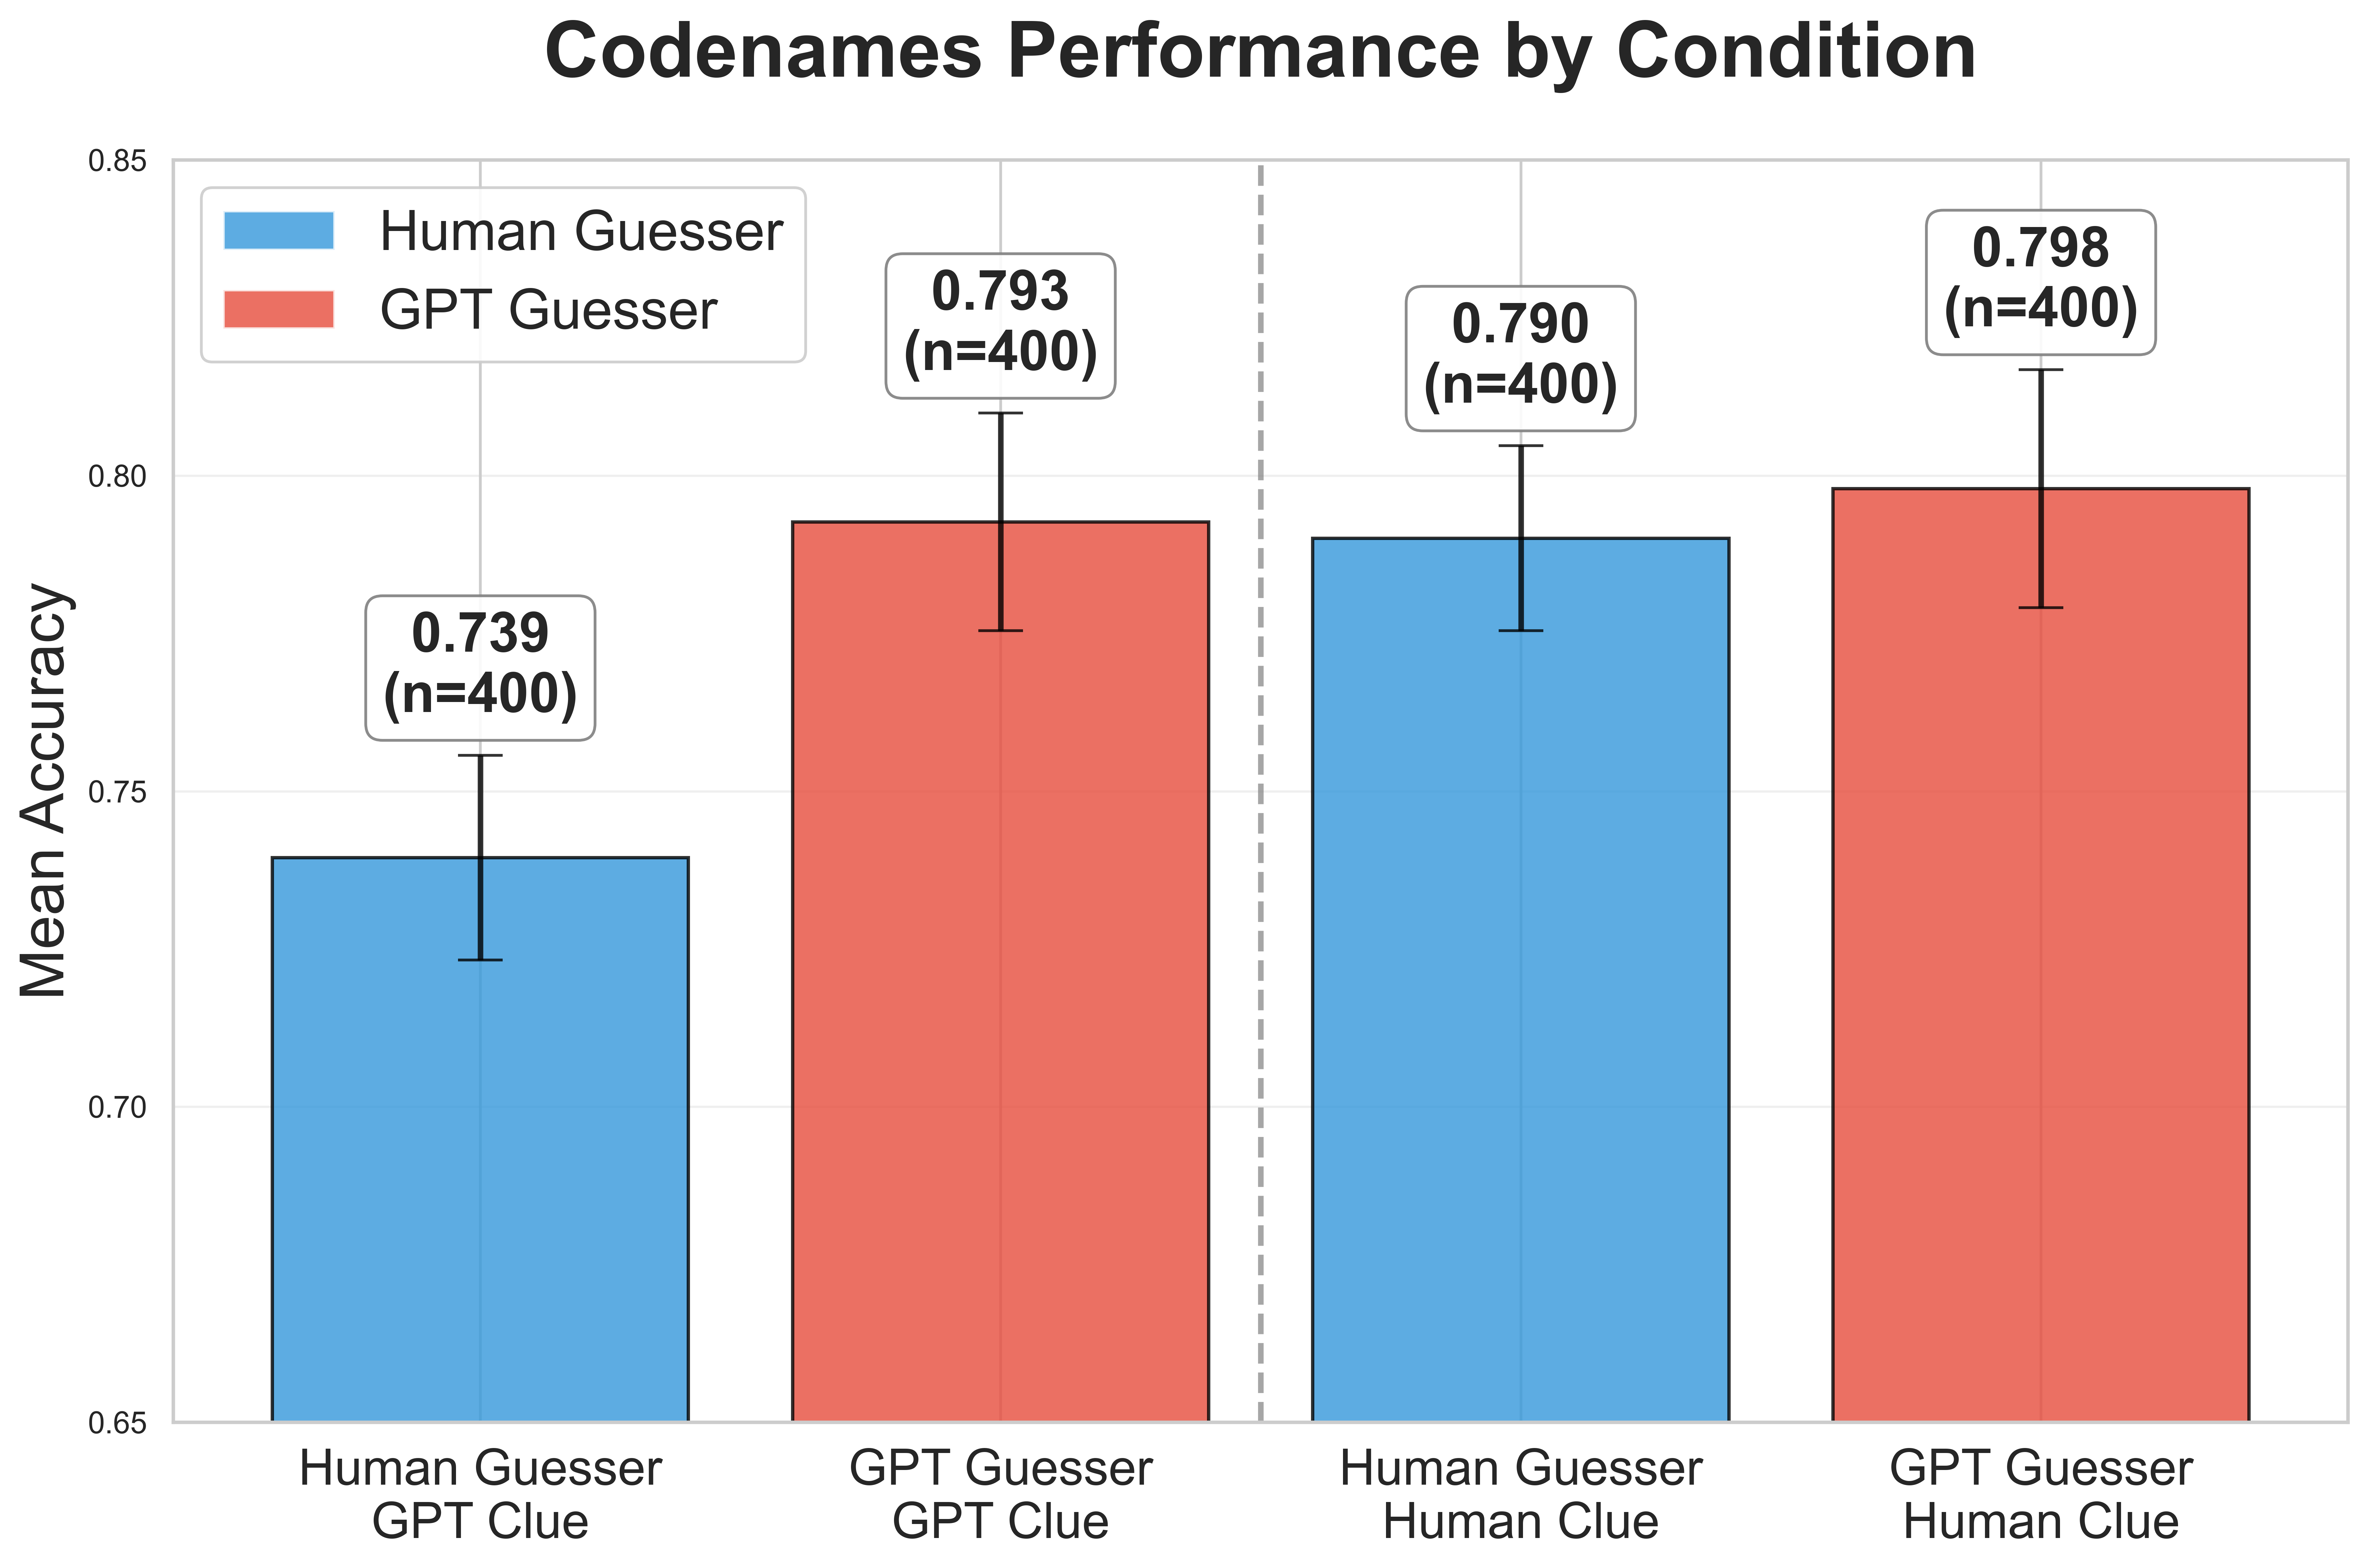

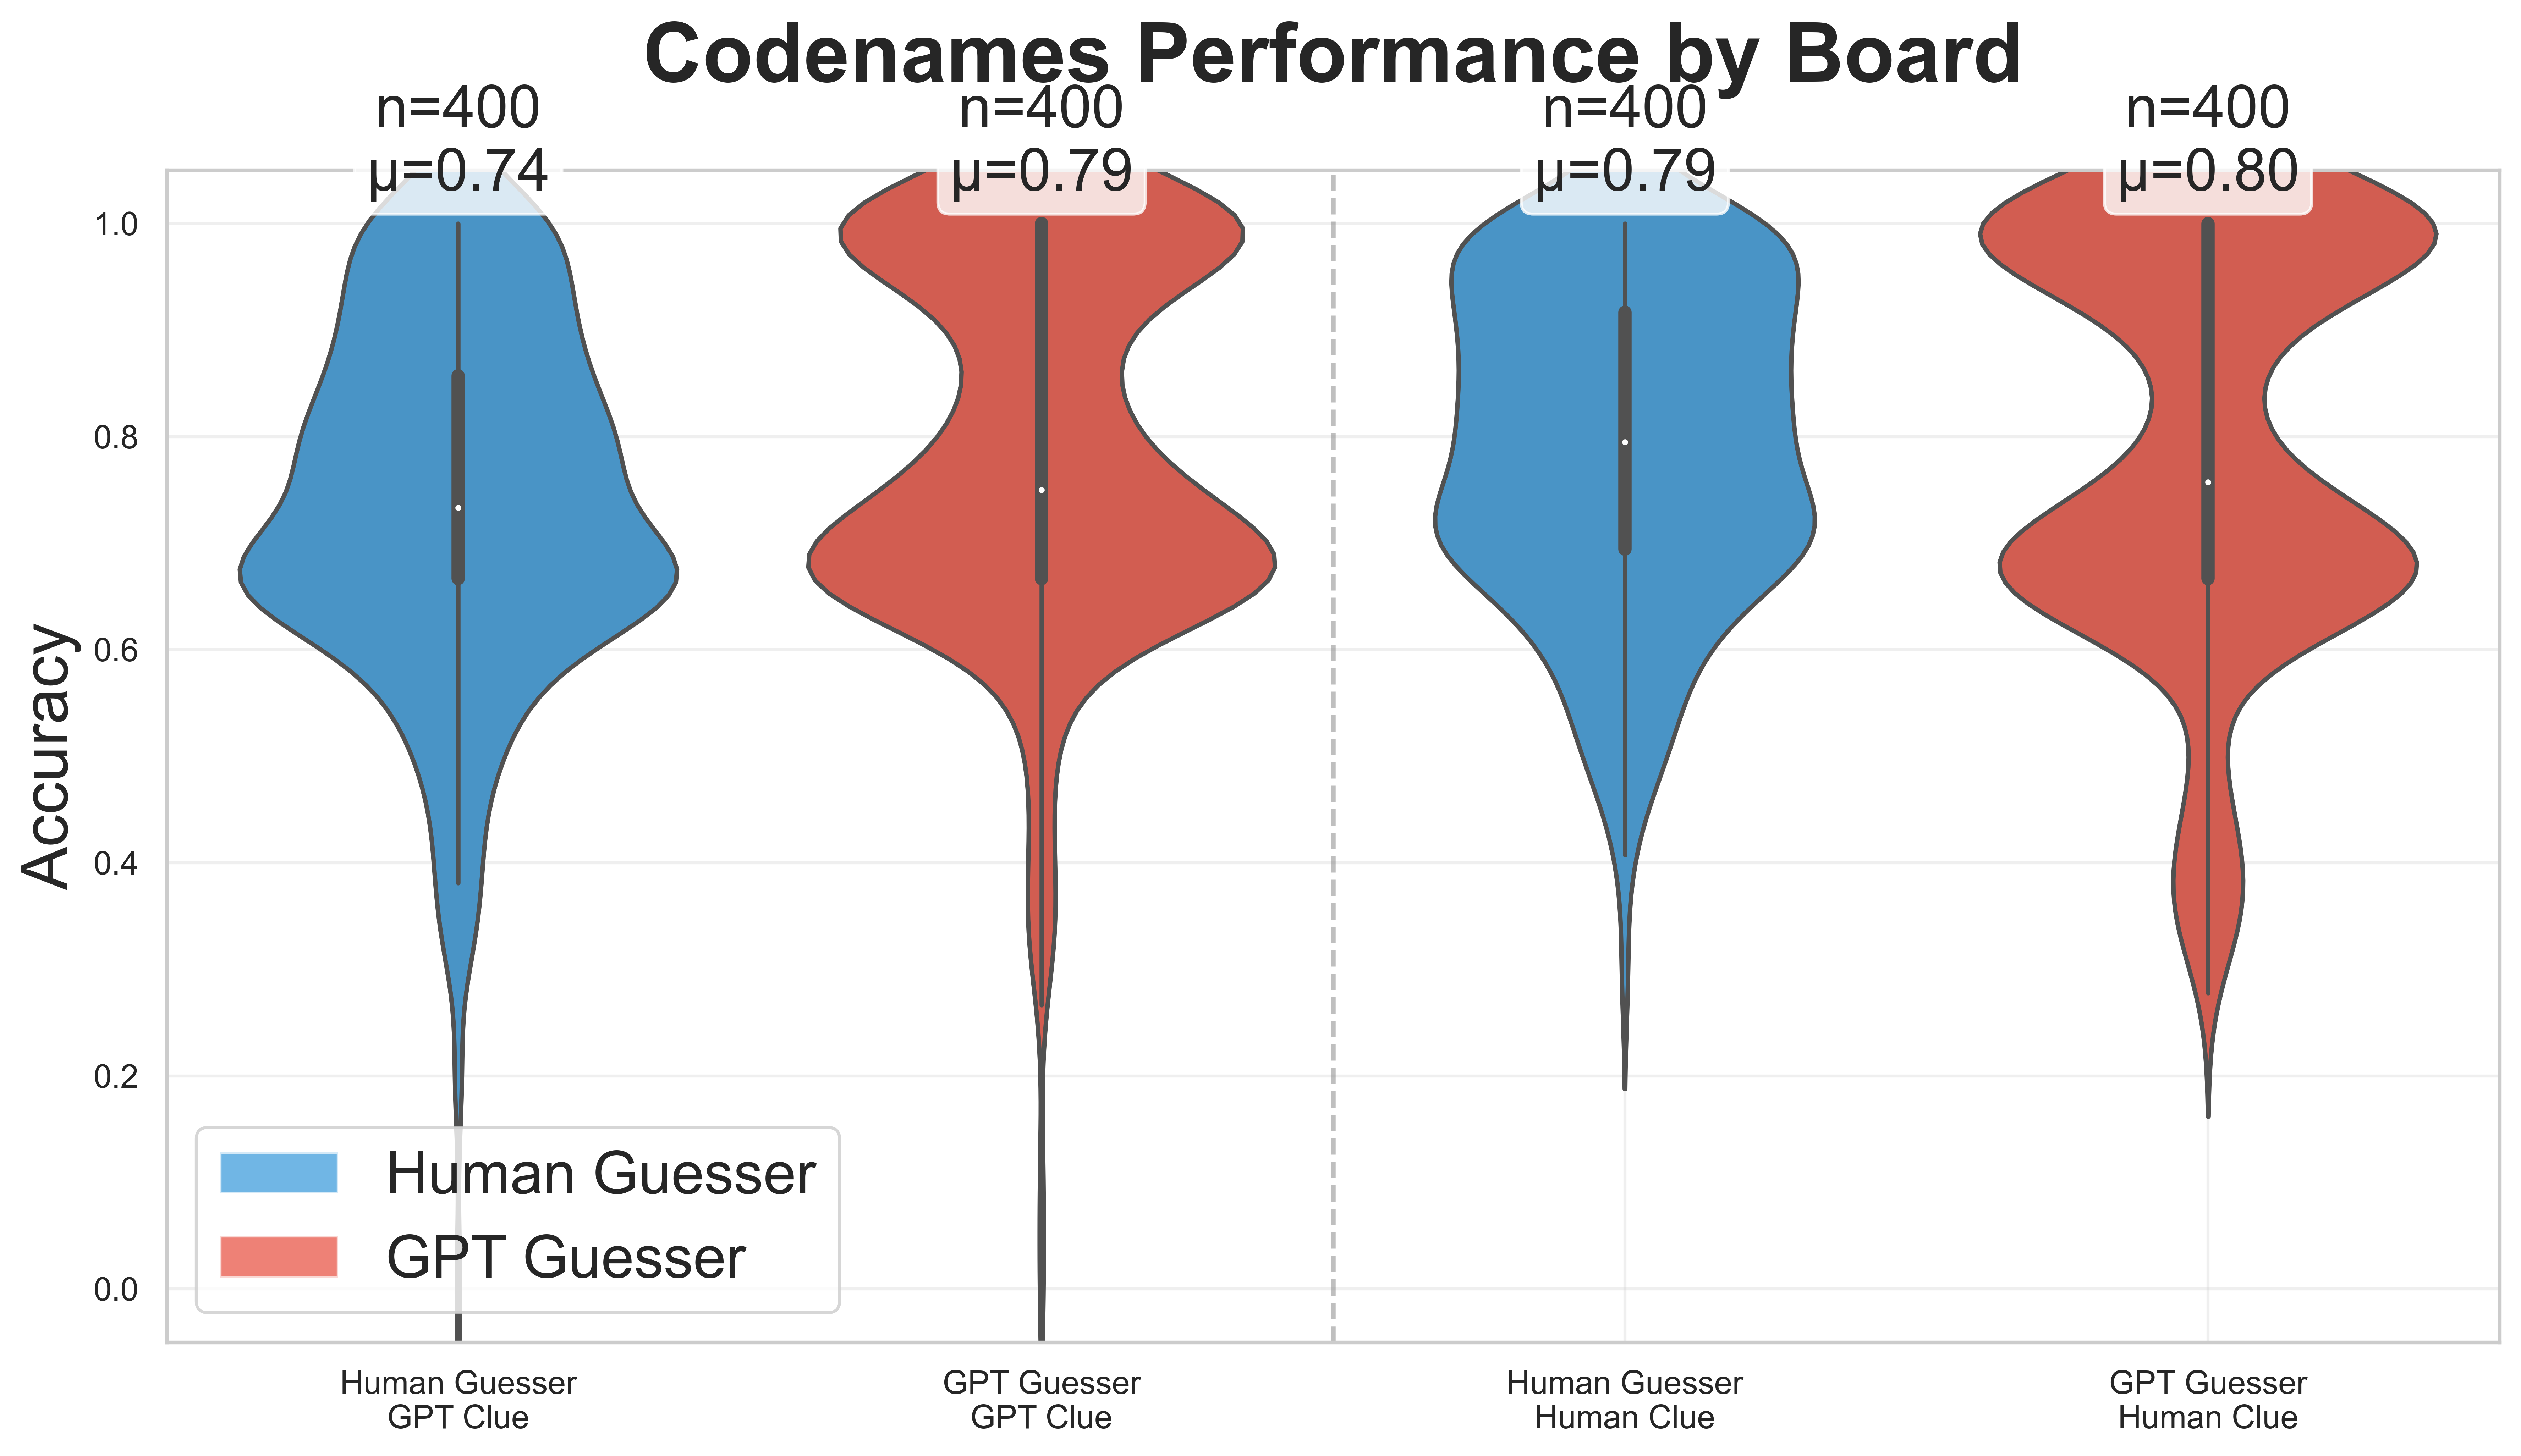

In [24]:
# Load and process violinplot
conditions = load_and_process_data_violinplot('boards-data-expanded.json')
    
# Print summary statistics
print_summary_statistics(conditions)
    
# Perform statistical tests
comparisons = perform_statistical_tests(conditions)

create_bar_plot(conditions)
    
# Create summary table
create_statistical_summary_table(comparisons)
    
# Create the violinplot
print("\nCreating violinplot visualization...")
fig, ax = create_violin_plot(conditions, save_path='codenames_violinplot.png')
print("Visualization complete! Plot saved as 'codenames_violinplot.png'")
    

# Relatedness Judgment Gaps in Boards

In [25]:
def create_relatedness_lookup(relatedness_data, aggregation_method='mean'):
    lookup = {}
    variance_info = {}
    
    for entry in relatedness_data:
        clue = entry['clue']
        word = entry['word']
        source = entry['source']
        relatedness = entry['relatedness']
        
        # skip entries with empty relatedness
        if not relatedness:
            continue
        
        # handles both single values and lists/arrays
        if isinstance(relatedness, (int, float)):
            # convert single values to lists for consistent processing
            relatedness = [relatedness]
        
        # calculate aggregated score
        if aggregation_method == 'mean':
            agg_score = np.mean(relatedness)
        elif aggregation_method == 'median':
            agg_score = np.median(relatedness)
        else:
            raise ValueError("aggregation_method must be 'mean' or 'median'")
        
        # store variance information for robustness checks
        if len(relatedness) > 1:
            variance_info[(clue, word, source)] = {
                'std': np.std(relatedness),
                'range': max(relatedness) - min(relatedness),
                'n_raters': len(relatedness)
            }
        else:

            variance_info[(clue, word, source)] = {
                'std': 0.0,
                'range': 0.0,
                'n_raters': 1
            }
        
        key = (clue, word, source)
        lookup[key] = agg_score
    
    return lookup, variance_info

In [26]:
def calculate_precision_gap(board_words, clue, source, relatedness_lookup):
    relatedness_scores = []
    
    for word in board_words:
        key = (clue, word, source)
        if key in relatedness_lookup:
            relatedness_scores.append((word, relatedness_lookup[key]))
    
    # need at least 12 words to calculate all gaps
    if len(relatedness_scores) < 12:
        return None
    
    # sort by relatedness score (descending)
    relatedness_scores.sort(key=lambda x: x[1], reverse=True)
    
    # extract scores for all 12 ranks
    scores = [relatedness_scores[i][1] for i in range(12)]
    
    # calculate all gaps (differences) between consecutive ranks
    gaps = {}
    ratios = {}
    for i in range(11): # 0 to 10 (for ranks 1-2, 2-3, ..., 11-12)
        rank_higher = i + 1
        rank_lower = i + 2
        gap_key = f'gap_{rank_higher}v{rank_lower}'
        ratio_key = f'ratio_{rank_higher}v{rank_lower}'
        
        # calculate gap (difference)
        gaps[gap_key] = scores[i] - scores[i + 1]
        
        # calculate ratio (avoid division by zero)
        ratios[ratio_key] = scores[i] / scores[i + 1] if scores[i + 1] != 0 else float('inf')
    
    # combine all results
    result = {
        # original gap (for backward compatibility)
        'gap': gaps['gap_3v4'],
        'third_score': scores[2],
        'fourth_score': scores[3],
        'sorted_words_scores': relatedness_scores
    }
    
    # add all gaps
    result.update(gaps)
    
    # add all ratios
    result.update(ratios)

    for i in range(12):
        result[f'rank_{i+1}_score'] = scores[i]
    
    return result

In [27]:
def check_complete_data(words, clue, relatedness_lookup):
    # check if we have both human and GPT judgments for all words on this board for this clue
    human_count = 0
    gpt_count = 0
    
    for word in words:
        if (clue, word, 'human') in relatedness_lookup:
            human_count += 1
        if (clue, word, 'gpt') in relatedness_lookup:
            gpt_count += 1
    
    # we need all 12 words to have judgments from both sources
    return human_count == len(words) and gpt_count == len(words)

In [28]:
def analyze_precision_gaps(boards_data, relatedness_lookup):
    results = []
    excluded_boards = []
    
    for board_key, board_data in boards_data.items():
        words = board_data['words']
        
        # Analyze GPT clues - only if we have complete data
        gpt_clue = board_data['gpt_clue']
        if check_complete_data(words, gpt_clue, relatedness_lookup):
            # GPT judge on GPT clue
            gpt_on_gpt = calculate_precision_gap(words, gpt_clue, 'gpt', relatedness_lookup)
            if gpt_on_gpt:
                result_dict = {
                    'board': board_key,
                    'clue': gpt_clue,
                    'clue_source': 'gpt',
                    'judge_source': 'gpt',
                    'gap': gpt_on_gpt['gap'],
                    'third_score': gpt_on_gpt['third_score'],
                    'fourth_score': gpt_on_gpt['fourth_score']
                }
                
                # Add all gaps (1v2 through 11v12)
                for i in range(11):
                    gap_key = f'gap_{i+1}v{i+2}'
                    if gap_key in gpt_on_gpt:
                        result_dict[gap_key] = gpt_on_gpt[gap_key]
                
                # Add all ratios (1v2 through 11v12)
                for i in range(11):
                    ratio_key = f'ratio_{i+1}v{i+2}'
                    if ratio_key in gpt_on_gpt:
                        result_dict[ratio_key] = gpt_on_gpt[ratio_key]
                
                # add all individual rank scores
                for i in range(12):
                    rank_key = f'rank_{i+1}_score'
                    if rank_key in gpt_on_gpt:
                        result_dict[rank_key] = gpt_on_gpt[rank_key]
                
                results.append(result_dict)
            
            # Human judge on GPT clue
            human_on_gpt = calculate_precision_gap(words, gpt_clue, 'human', relatedness_lookup)
            if human_on_gpt:
                result_dict = {
                    'board': board_key,
                    'clue': gpt_clue,
                    'clue_source': 'gpt',
                    'judge_source': 'human',
                    'gap': human_on_gpt['gap'],
                    'third_score': human_on_gpt['third_score'],
                    'fourth_score': human_on_gpt['fourth_score']
                }
                
                # Add all gaps (1v2 through 11v12)
                for i in range(11):
                    gap_key = f'gap_{i+1}v{i+2}'
                    if gap_key in human_on_gpt:
                        result_dict[gap_key] = human_on_gpt[gap_key]
                
                # Add all ratios (1v2 through 11v12)
                for i in range(11):
                    ratio_key = f'ratio_{i+1}v{i+2}'
                    if ratio_key in human_on_gpt:
                        result_dict[ratio_key] = human_on_gpt[ratio_key]
                
                # add all individual rank scores
                for i in range(12):
                    rank_key = f'rank_{i+1}_score'
                    if rank_key in human_on_gpt:
                        result_dict[rank_key] = human_on_gpt[rank_key]
                
                results.append(result_dict)
        else:
            excluded_boards.append((board_key, gpt_clue, 'incomplete GPT clue data'))
        
        # Analyze Human clues
        human_clue = board_data['human_clue']
        if check_complete_data(words, human_clue, relatedness_lookup):
            # GPT judge on Human clue
            gpt_on_human = calculate_precision_gap(words, human_clue, 'gpt', relatedness_lookup)
            if gpt_on_human:
                result_dict = {
                    'board': board_key,
                    'clue': human_clue,
                    'clue_source': 'human',
                    'judge_source': 'gpt',
                    'gap': gpt_on_human['gap'],
                    'third_score': gpt_on_human['third_score'],
                    'fourth_score': gpt_on_human['fourth_score']
                }
                
                # Add all gaps (1v2 through 11v12)
                for i in range(11):
                    gap_key = f'gap_{i+1}v{i+2}'
                    if gap_key in gpt_on_human:
                        result_dict[gap_key] = gpt_on_human[gap_key]
                
                # Add all ratios (1v2 through 11v12)
                for i in range(11):
                    ratio_key = f'ratio_{i+1}v{i+2}'
                    if ratio_key in gpt_on_human:
                        result_dict[ratio_key] = gpt_on_human[ratio_key]
                
                # add all individual rank scores
                for i in range(12):
                    rank_key = f'rank_{i+1}_score'
                    if rank_key in gpt_on_human:
                        result_dict[rank_key] = gpt_on_human[rank_key]
                
                results.append(result_dict)
            
            # Human judge on Human clue
            human_on_human = calculate_precision_gap(words, human_clue, 'human', relatedness_lookup)
            if human_on_human:
                result_dict = {
                    'board': board_key,
                    'clue': human_clue,
                    'clue_source': 'human',
                    'judge_source': 'human',
                    'gap': human_on_human['gap'],
                    'third_score': human_on_human['third_score'],
                    'fourth_score': human_on_human['fourth_score']
                }
                
                # Add all gaps (1v2 through 11v12)
                for i in range(11):
                    gap_key = f'gap_{i+1}v{i+2}'
                    if gap_key in human_on_human:
                        result_dict[gap_key] = human_on_human[gap_key]
                
                # Add all ratios (1v2 through 11v12)
                for i in range(11):
                    ratio_key = f'ratio_{i+1}v{i+2}'
                    if ratio_key in human_on_human:
                        result_dict[ratio_key] = human_on_human[ratio_key]
                
                # add all individual rank scores
                for i in range(12):
                    rank_key = f'rank_{i+1}_score'
                    if rank_key in human_on_human:
                        result_dict[rank_key] = human_on_human[rank_key]
                
                results.append(result_dict)
        else:
            excluded_boards.append((board_key, human_clue, 'incomplete human clue data'))
    
    if excluded_boards:
        print(f"\nEXCLUDED BOARDS DUE TO INCOMPLETE DATA:")
        # for board, clue, reason in excluded_boards:
        #     print(f"  {board[:50]}... - {clue} - {reason}")
        print(f"Total excluded: {len(excluded_boards)} board-clue combinations")
    
    return pd.DataFrame(results)

In [29]:
def create_paired_data(df):
    paired_data = {}
    
    # Debug: check if drop_duplicates is removing anything important
    all_combinations = df[['board', 'clue', 'clue_source']]
    unique_combinations = df[['board', 'clue', 'clue_source']].drop_duplicates()
    
    print(f"Total rows in df: {len(df)}")
    print(f"All board-clue combinations: {len(all_combinations)}")
    print(f"Unique board-clue combinations: {len(unique_combinations)}")
    print(f"Expected: Each unique combination should appear 2x (human + GPT judge)")
    print(f"Ratio: {len(all_combinations) / len(unique_combinations):.2f} (should be ~2.0)\n")
    
    # for each board-clue combination, get human and GPT gaps
    board_clues = unique_combinations
    
    for _, row in board_clues.iterrows():
        board = row['board']
        clue = row['clue']
        clue_source = row['clue_source']
        
        # get human and GPT gaps for this specific board-clue combination
        human_gap = df[(df['board'] == board) & (df['clue'] == clue) & (df['judge_source'] == 'human')]['gap']
        gpt_gap = df[(df['board'] == board) & (df['clue'] == clue) & (df['judge_source'] == 'gpt')]['gap']
        
        # only include if we have both human and GPT judgments
        if len(human_gap) > 0 and len(gpt_gap) > 0:
            key = f"{clue_source}_clues"
            if key not in paired_data:
                paired_data[key] = {'human_gaps': [], 'gpt_gaps': [], 'boards': [], 'clues': []}
            
            paired_data[key]['human_gaps'].append(human_gap.iloc[0])
            paired_data[key]['gpt_gaps'].append(gpt_gap.iloc[0])
            paired_data[key]['boards'].append(board)
            paired_data[key]['clues'].append(clue)
    
    return paired_data

In [30]:
def normalize_dataframe(results_df):
    df_normalized = results_df.copy()
    print("Creating normalized version of results...")
    
    # CHANGE THIS LINE: Look for rank_X_score columns, not rank_X columns
    rank_columns = [f'rank_{i}_score' for i in range(1, 13)]  # Added '_score'
    
    # Check which rank columns actually exist in the dataframe
    existing_rank_columns = [col for col in rank_columns if col in df_normalized.columns]
    
    if not existing_rank_columns:
        print("Warning: No rank score columns found. Looking for alternative column patterns...")
        print(f"Available columns: {list(df_normalized.columns)}")
        return df_normalized
    
    print(f"Found {len(existing_rank_columns)} rank score columns for normalization")
    print(f"Columns: {existing_rank_columns}")
    
    # Calculate sum of ranks for each row (this represents the total relatedness budget)
    df_normalized['rank_sum'] = df_normalized[existing_rank_columns].sum(axis=1)
    
    # Normalize each rank by dividing by the sum
    for col in existing_rank_columns:
        df_normalized[col] = df_normalized[col] / df_normalized['rank_sum']
    
    # Recalculate gaps and ratios with normalized data
    for idx, row in df_normalized.iterrows():
        # Get normalized ranks (already sorted from your original analysis)
        ranks = [row[col] for col in existing_rank_columns if not pd.isna(row[col])]
        
        # Calculate gaps between consecutive ranks
        for i in range(len(ranks) - 1):
            gap_col = f'gap_{i+1}v{i+2}'
            if gap_col in df_normalized.columns:
                df_normalized.loc[idx, gap_col] = ranks[i] - ranks[i+1]
        
        # Calculate ratios between consecutive ranks
        for i in range(len(ranks) - 1):
            ratio_col = f'ratio_{i+1}v{i+2}'
            if ratio_col in df_normalized.columns:
                if ranks[i+1] != 0:
                    df_normalized.loc[idx, ratio_col] = ranks[i] / ranks[i+1]
                else:
                    df_normalized.loc[idx, ratio_col] = np.inf
    
    # Remove the temporary rank_sum column
    df_normalized = df_normalized.drop(columns=['rank_sum'])
    
    print(f"Normalization complete. Sample normalized gap_3v4 range: {df_normalized['gap_3v4'].min():.5f} to {df_normalized['gap_3v4'].max():.5f}")
    
    return df_normalized

In [31]:
def statistical_analysis_gaps(df):
    print("=== CONCEPTUAL PRECISION ANALYSIS: COMPREHENSIVE GAP ANALYSIS ===")
    print("(Measuring ability to distinguish the 3 intended words from other board words)")
    print("Gap = 3rd most related score - 4th most related score")
    print("Higher gaps = better conceptual precision\n")
    
    # Get all combinations
    human_native = df[(df['clue_source'] == 'human') & (df['judge_source'] == 'human')]
    gpt_native = df[(df['clue_source'] == 'gpt') & (df['judge_source'] == 'gpt')]
    human_judge_gpt_clue = df[(df['clue_source'] == 'gpt') & (df['judge_source'] == 'human')]
    gpt_judge_human_clue = df[(df['clue_source'] == 'human') & (df['judge_source'] == 'gpt')]
    
    print("SAMPLE SIZES:")
    print(f"Human clues + Human judges (native): n={len(human_native)}")
    print(f"GPT clues + GPT judges (native): n={len(gpt_native)}")
    print(f"GPT clues + Human judges (cross): n={len(human_judge_gpt_clue)}")
    print(f"Human clues + GPT judges (cross): n={len(gpt_judge_human_clue)}")
    print()

    # ===================================================================
    # 1. NATIVE COMBINATIONS COMPARISON
    # ===================================================================
    print("1. NATIVE COMBINATIONS: Human+Human vs GPT+GPT")
    print("="*60)
    
    if len(human_native) > 0 and len(gpt_native) > 0:
        print(f"Human native: mean={np.mean(human_native['gap_3v4']):.3f}, std={np.std(human_native['gap_3v4']):.3f}")
        print(f"GPT native: mean={np.mean(gpt_native['gap_3v4']):.3f}, std={np.std(gpt_native['gap_3v4']):.3f}")
        
        # Independent samples t-test (different clues from different sources)
        stat, p_value = scipy.stats.ttest_ind(human_native['gap_3v4'], gpt_native['gap_3v4'])
        print(f"Independent t-test: t={stat:.3f}, p={p_value:.6f}")
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(human_native) - 1) * np.var(human_native['gap_3v4']) +
                             (len(gpt_native) - 1) * np.var(gpt_native['gap_3v4'])) /
                             (len(human_native) + len(gpt_native) - 2))
        cohen_d = (np.mean(human_native['gap_3v4']) - np.mean(gpt_native['gap_3v4'])) / pooled_std
        print(f"Effect size (Cohen's d): {cohen_d:.3f}")
        
        if p_value < 0.05:
            direction = "higher" if np.mean(human_native['gap_3v4']) > np.mean(gpt_native['gap_3v4']) else "lower"
            print(f"→ Significant difference: Human native shows {direction} 3v4 gaps than GPT native")
        else:
            print("→ No significant difference between native combinations")
    print()

    # ===================================================================
    # 2. WITHIN HUMAN JUDGES: Human clues vs GPT clues
    # ===================================================================
    print("2. WITHIN HUMAN JUDGES: Human clues vs GPT clues")
    print("="*60)
    print("NOTE: Comparing DIFFERENT clues (human vs GPT generated) judged by humans")
    print("Using independent samples t-test since clues are different stimuli")
    
    if len(human_native) > 0 and len(human_judge_gpt_clue) > 0:
        print(f"Human judges on Human clues: mean={np.mean(human_native['gap_3v4']):.3f}, std={np.std(human_native['gap_3v4']):.3f}")
        print(f"Human judges on GPT clues: mean={np.mean(human_judge_gpt_clue['gap_3v4']):.3f}, std={np.std(human_judge_gpt_clue['gap_3v4']):.3f}")
        
        # Independent samples t-test (different clues, same judge type)
        stat_indep, p_indep = scipy.stats.ttest_ind(human_native['gap_3v4'], human_judge_gpt_clue['gap_3v4'])
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(human_native) - 1) * np.var(human_native['gap_3v4']) +
                             (len(human_judge_gpt_clue) - 1) * np.var(human_judge_gpt_clue['gap_3v4'])) /
                             (len(human_native) + len(human_judge_gpt_clue) - 2))
        cohen_d = (np.mean(human_native['gap_3v4']) - np.mean(human_judge_gpt_clue['gap_3v4'])) / pooled_std
        
        print(f"Independent t-test: t={stat_indep:.3f}, p={p_indep:.6f}")
        print(f"Effect size (Cohen's d): {cohen_d:.3f}")
        print(f"Mean difference (Human clues - GPT clues): {np.mean(human_native['gap_3v4']) - np.mean(human_judge_gpt_clue['gap_3v4']):.3f}")
        
        if p_indep < 0.05:
            direction = "larger" if np.mean(human_native['gap_3v4']) > np.mean(human_judge_gpt_clue['gap_3v4']) else "smaller"
            print(f"→ Human judges show significantly {direction} 3v4 gaps for human vs GPT clues")
        else:
            print("→ No significant difference in human judges' 3v4 gaps between clue types")
            
        # Additional analysis: Check if boards overlap for supplementary insights
        overlapping_boards = set(human_native['board']).intersection(set(human_judge_gpt_clue['board']))
        print(f"Boards appearing in both conditions: {len(overlapping_boards)}")
        
        if len(overlapping_boards) >= 10:
            print("(Sufficient board overlap exists, but we're still using independent tests")
            print(" since we're comparing different clues, not the same clues)")
    print()

    # ===================================================================
    # 3. WITHIN GPT JUDGES: Human clues vs GPT clues  
    # ===================================================================
    print("3. WITHIN GPT JUDGES: Human clues vs GPT clues")
    print("="*60)
    print("NOTE: Comparing DIFFERENT clues (human vs GPT generated) judged by GPT")
    print("Using independent samples t-test since clues are different stimuli")
    
    if len(gpt_native) > 0 and len(gpt_judge_human_clue) > 0:
        print(f"GPT judges on Human clues: mean={np.mean(gpt_judge_human_clue['gap_3v4']):.3f}, std={np.std(gpt_judge_human_clue['gap_3v4']):.3f}")
        print(f"GPT judges on GPT clues: mean={np.mean(gpt_native['gap_3v4']):.3f}, std={np.std(gpt_native['gap_3v4']):.3f}")
        
        # Independent samples t-test (different clues, same judge type)
        stat_indep, p_indep = scipy.stats.ttest_ind(gpt_judge_human_clue['gap_3v4'], gpt_native['gap_3v4'])
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(gpt_judge_human_clue) - 1) * np.var(gpt_judge_human_clue['gap_3v4']) +
                             (len(gpt_native) - 1) * np.var(gpt_native['gap_3v4'])) /
                             (len(gpt_judge_human_clue) + len(gpt_native) - 2))
        cohen_d = (np.mean(gpt_judge_human_clue['gap_3v4']) - np.mean(gpt_native['gap_3v4'])) / pooled_std
        
        print(f"Independent t-test: t={stat_indep:.3f}, p={p_indep:.6f}")
        print(f"Effect size (Cohen's d): {cohen_d:.3f}")
        print(f"Mean difference (Human clues - GPT clues): {np.mean(gpt_judge_human_clue['gap_3v4']) - np.mean(gpt_native['gap_3v4']):.3f}")
        
        if p_indep < 0.05:
            direction = "larger" if np.mean(gpt_judge_human_clue['gap_3v4']) > np.mean(gpt_native['gap_3v4']) else "smaller"
            print(f"→ GPT judges show significantly {direction} 3v4 gaps for human vs GPT clues")
        else:
            print("→ No significant difference in GPT judges' 3v4 gaps between clue types")
            
        # Additional analysis: Check board overlap
        overlapping_boards = set(gpt_judge_human_clue['board']).intersection(set(gpt_native['board']))
        print(f"Boards appearing in both conditions: {len(overlapping_boards)}")
    print()

    # ===================================================================
    # 4. CROSS-CONDITION COMPARISONS: Judge type effects
    # ===================================================================
    print("4. CROSS-CONDITION COMPARISONS: Judge Type Effects")
    print("="*60)
    
    # Compare human judges vs GPT judges on human clues
    if len(human_native) > 0 and len(gpt_judge_human_clue) > 0:
        print("4a. Human clues: Human judges vs GPT judges")
        print(f"Human judges on Human clues: mean={np.mean(human_native['gap_3v4']):.3f}")
        print(f"GPT judges on Human clues: mean={np.mean(gpt_judge_human_clue['gap_3v4']):.3f}")
        
        stat, p_value = scipy.stats.ttest_ind(human_native['gap_3v4'], gpt_judge_human_clue['gap_3v4'])
        pooled_std = np.sqrt(((len(human_native) - 1) * np.var(human_native['gap_3v4']) +
                             (len(gpt_judge_human_clue) - 1) * np.var(gpt_judge_human_clue['gap_3v4'])) /
                             (len(human_native) + len(gpt_judge_human_clue) - 2))
        cohen_d = (np.mean(human_native['gap_3v4']) - np.mean(gpt_judge_human_clue['gap_3v4'])) / pooled_std
        
        print(f"Independent t-test: t={stat:.3f}, p={p_value:.6f}, Cohen's d={cohen_d:.3f}")
        
        if p_value < 0.05:
            better_judge = "Human" if np.mean(human_native['gap_3v4']) > np.mean(gpt_judge_human_clue['gap_3v4']) else "GPT"
            print(f"→ {better_judge} judges perform significantly better on human clues")
        else:
            print("→ No significant difference between judge types on human clues")
    
    # Compare human judges vs GPT judges on GPT clues
    if len(human_judge_gpt_clue) > 0 and len(gpt_native) > 0:
        print("\n4b. GPT clues: Human judges vs GPT judges")
        print(f"Human judges on GPT clues: mean={np.mean(human_judge_gpt_clue['gap_3v4']):.3f}")
        print(f"GPT judges on GPT clues: mean={np.mean(gpt_native['gap_3v4']):.3f}")
        
        stat, p_value = scipy.stats.ttest_ind(human_judge_gpt_clue['gap_3v4'], gpt_native['gap_3v4'])
        pooled_std = np.sqrt(((len(human_judge_gpt_clue) - 1) * np.var(human_judge_gpt_clue['gap_3v4']) +
                             (len(gpt_native) - 1) * np.var(gpt_native['gap_3v4'])) /
                             (len(human_judge_gpt_clue) + len(gpt_native) - 2))
        cohen_d = (np.mean(human_judge_gpt_clue['gap_3v4']) - np.mean(gpt_native['gap_3v4'])) / pooled_std
        
        print(f"Independent t-test: t={stat:.3f}, p={p_value:.6f}, Cohen's d={cohen_d:.3f}")
        
        if p_value < 0.05:
            better_judge = "Human" if np.mean(human_judge_gpt_clue['gap_3v4']) > np.mean(gpt_native['gap_3v4']) else "GPT"
            print(f"→ {better_judge} judges perform significantly better on GPT clues")
        else:
            print("→ No significant difference between judge types on GPT clues")
    print()

    # ===================================================================
    # 5. GAP PROMINENCE ANALYSIS: Is 3v4 gap distinctive within each category?
    # ===================================================================
    print("5. GAP PROMINENCE ANALYSIS: Is 3v4 gap distinctive within each combination?")
    print("="*80)
    
    gap_columns = [f'gap_{i+1}v{i+2}' for i in range(11)]
    gap_labels = [f'{i+1}v{i+2}' for i in range(11)]
    
    combinations = [
        ('Human+Human', human_native),
        ('GPT+GPT', gpt_native),
        ('GPT+Human', human_judge_gpt_clue),
        ('Human+GPT', gpt_judge_human_clue)
    ]
    
    for label, data in combinations:
        if len(data) == 0:
            continue
            
        print(f"\n{label} (clue+judge):")
        
        # Calculate mean for each gap type
        gap_means = {}
        for col, lbl in zip(gap_columns, gap_labels):
            if col in data.columns and len(data[col].dropna()) > 0:
                gap_means[lbl] = data[col].mean()
        
        # Find which gap is largest
        if gap_means:
            max_gap_label = max(gap_means, key=gap_means.get)
            max_gap_value = gap_means[max_gap_label]
            
            print(f"  Top 5 gaps: {', '.join([f'{lbl}={val:.3f}' for lbl, val in sorted(gap_means.items(), key=lambda x: x[1], reverse=True)[:5]])}")
            print(f"  Largest gap: {max_gap_label} (mean={max_gap_value:.3f})")
            
            if '3v4' in gap_means:
                gap_rank = sorted(gap_means.items(), key=lambda x: x[1], reverse=True)
                rank_3v4 = next((i+1 for i, (lbl, _) in enumerate(gap_rank) if lbl == '3v4'), None)
                print(f"  3v4 gap rank: {rank_3v4} out of {len(gap_means)} (mean={gap_means['3v4']:.3f})")
        
        # Statistical comparisons: 3v4 vs adjacent gaps (using independent tests)
        if 'gap_3v4' in data.columns:
            gap_3v4 = data['gap_3v4'].dropna()
            if len(gap_3v4) > 5:
                print(f"  3v4 gap vs adjacent gaps (independent t-tests, n={len(gap_3v4)}):")
                
                for comp_gap, comp_label in [('gap_2v3', '2v3'), ('gap_4v5', '4v5'), ('gap_1v2', '1v2')]:
                    if comp_gap in data.columns:
                        comp_data = data[comp_gap].dropna()
                        if len(comp_data) > 5:
                            stat, p = scipy.stats.ttest_ind(gap_3v4, comp_data)
                            mean_diff = gap_3v4.mean() - comp_data.mean()
                            # Calculate Cohen's d for independent samples
                            pooled_std = np.sqrt(((len(gap_3v4) - 1) * gap_3v4.var() + 
                                                (len(comp_data) - 1) * comp_data.var()) / 
                                               (len(gap_3v4) + len(comp_data) - 2))
                            effect_size = mean_diff / pooled_std if pooled_std > 0 else 0
                            significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
                            print(f"    3v4 vs {comp_label}: t={stat:.3f}, p={p:.4f} {significance}, diff={mean_diff:.3f}, d={effect_size:.3f}")

    print("\n" + "="*80)

    # ===================================================================
    # 6. GAP CONSISTENCY ANALYSIS: How reliable is the 3v4 gap?
    # ===================================================================
    print("6. GAP CONSISTENCY ANALYSIS: How reliable is the 3v4 gap?")
    print("="*80)
    
    for label, data in combinations:
        if len(data) == 0 or 'gap_3v4' not in data.columns:
            continue
            
        gap_3v4 = data['gap_3v4'].dropna()
        if len(gap_3v4) > 0:
            print(f"\n{label} 3v4 gap distribution:")
            print(f"  Mean: {gap_3v4.mean():.3f}")
            print(f"  Std: {gap_3v4.std():.3f}")
            print(f"  CV (coefficient of variation): {gap_3v4.std()/abs(gap_3v4.mean()):.3f}")
            print(f"  Range: {gap_3v4.min():.3f} to {gap_3v4.max():.3f}")
            print(f"  IQR: {gap_3v4.quantile(0.25):.3f} to {gap_3v4.quantile(0.75):.3f}")
            print(f"  % positive gaps: {(gap_3v4 > 0).mean()*100:.1f}%")
            
            # Stability metrics
            substantial_gaps = (gap_3v4 > 0.1).mean()
            large_gaps = (gap_3v4 > 0.2).mean()
            print(f"  % substantial gaps (>0.1): {substantial_gaps*100:.1f}%")
            print(f"  % large gaps (>0.2): {large_gaps*100:.1f}%")

    print("\n" + "="*80)

    # ===================================================================
    # 7. SUMMARY STATISTICS TABLE
    # ===================================================================
    print("7. SUMMARY: 3v4 Gap Means Across All Combinations")
    print("="*60)
    print(f"{'Combination':<15} {'Mean':<8} {'Std':<8} {'CV':<8} {'N':<6}")
    print("-" * 50)
    
    for label, data in combinations:
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_3v4 = data['gap_3v4'].dropna()
            if len(gap_3v4) > 0:
                mean_val = gap_3v4.mean()
                std_val = gap_3v4.std()
                cv_val = std_val / abs(mean_val) if mean_val != 0 else float('inf')
                print(f"{label:<15} {mean_val:<8.3f} {std_val:<8.3f} {cv_val:<8.3f} {len(gap_3v4):<6}")

    print("\n" + "="*80)
    print("INTERPRETATION GUIDE:")
    print("• NATIVE: Same source for clues and judges (Human+Human, GPT+GPT)")
    print("• CROSS: Different sources (GPT+Human, Human+GPT)")
    print("• ALL TESTS: Independent samples t-tests used throughout")
    print("  - Different clue sources = different stimuli = independent samples")
    print("  - Even when boards overlap, we're comparing different clues")
    print("• GAP PROMINENCE: Does 3v4 gap stand out among consecutive gaps?")
    print("• GAP CONSISTENCY: CV = std/mean (lower = more consistent)")
    print("• % positive gaps: How often 3rd > 4th (expected if boundary exists)")
    print("• COHEN'S D: 0.2=small, 0.5=medium, 0.8=large effect size")
    print("="*80)

In [32]:
def create_visualizations_gaps(df):
    """
    Enhanced visualization function that includes all four combinations:
    - Human clues + Human judges (native)
    - GPT clues + GPT judges (native) 
    - GPT clues + Human judges (cross)
    - Human clues + GPT judges (cross)
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Define font sizes (assuming these are defined elsewhere)
    AXIS = 16
    LABEL = 12
    
    # Get all four combinations
    human_native = df[(df['clue_source'] == 'human') & (df['judge_source'] == 'human')]
    gpt_native = df[(df['clue_source'] == 'gpt') & (df['judge_source'] == 'gpt')]
    human_judge_gpt_clue = df[(df['clue_source'] == 'gpt') & (df['judge_source'] == 'human')]
    gpt_judge_human_clue = df[(df['clue_source'] == 'human') & (df['judge_source'] == 'gpt')]
    
    # Generate column names
    gap_columns = [f'gap_{i+1}v{i+2}' for i in range(11)]
    gap_labels = [f'{i+1}v{i+2}' for i in range(11)]
    ratio_columns = [f'ratio_{i+1}v{i+2}' for i in range(11)]
    ratio_labels = [f'{i+1}/{i+2}' for i in range(11)]
    
    # Define combinations with colors and labels
    combinations = [
        (human_native, 'Human+Human', 'lightblue', 'Native'),
        (gpt_native, 'GPT+GPT', 'lightcoral', 'Native'),
        (human_judge_gpt_clue, 'GPT+Human', 'lightgreen', 'Cross'),
        (gpt_judge_human_clue, 'Human+GPT', 'lightyellow', 'Cross')
    ]
    
    # ============================================================================
    # FIGURE 1: COMPREHENSIVE GAP ANALYSIS - ALL COMBINATIONS
    # ============================================================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(24, 16))
    fig1.suptitle('Conceptual Precision: All Combinations Analysis (Gaps)', fontsize=AXIS+2, fontweight='bold')
    
    # 1. Key gaps comparison across all combinations
    ax1 = axes1[0, 0]
    key_gaps = ['gap_1v2', 'gap_2v3', 'gap_3v4', 'gap_4v5']
    key_labels = ['1v2', '2v3', '3v4', '4v5']
    
    x_pos = np.arange(len(key_labels))
    width = 0.2
    
    for i, (data, label, color, combo_type) in enumerate(combinations):
        if len(data) > 0:
            means = [data[col].mean() if col in data.columns and len(data[col].dropna()) > 0 else 0 for col in key_gaps]
            bars = ax1.bar(x_pos + i*width - 1.5*width, means, width, 
                          label=f'{label} ({combo_type})', color=color, alpha=0.8)
            
            # Add value labels on bars
            for bar, mean_val in zip(bars, means):
                if mean_val > 0:
                    ax1.annotate(f'{mean_val:.3f}',
                                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                xytext=(0, 3),
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=LABEL-2, rotation=90)
    
    ax1.set_xlabel('Key Rank Gaps')
    ax1.set_ylabel('Mean Absolute Difference')
    ax1.set_title('Key Gaps: All Combinations')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(key_labels)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Highlight 3v4 gap
    ax1.axvline(x=2, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax1.text(2, ax1.get_ylim()[1] * 0.95, 'Target Gap', ha='center', 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # 2. 3v4 gap distributions for all combinations
    ax2 = axes1[0, 1]
    
    gap_3v4_data = []
    gap_3v4_labels = []
    gap_3v4_colors = []
    
    for data, label, color, combo_type in combinations:
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            if len(gap_data) > 0:
                gap_3v4_data.append(gap_data)
                gap_3v4_labels.append(f'{label}\n(n={len(gap_data)})')
                gap_3v4_colors.append(color)
    
    if gap_3v4_data:
        # Create violin plot
        parts = ax2.violinplot(gap_3v4_data, positions=range(1, len(gap_3v4_data)+1), widths=0.7)
        
        # Color the violin plots
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(gap_3v4_colors[i])
            pc.set_alpha(0.7)
        
        ax2.set_xticks(range(1, len(gap_3v4_labels)+1))
        ax2.set_xticklabels(gap_3v4_labels)
        ax2.set_ylabel('3rd-4th Gap')
        ax2.set_title('3rd-4th Gap Distributions: All Combinations')
        ax2.grid(True, alpha=0.3)
        
        # Add median points and statistics
        for i, gap_data in enumerate(gap_3v4_data):
            median_val = gap_data.median()
            mean_val = gap_data.mean()
            ax2.scatter(i+1, median_val, color='red', s=60, zorder=3, marker='D')
            ax2.scatter(i+1, mean_val, color='blue', s=60, zorder=3, marker='o')
        
        # Add legend for scatter points
        ax2.scatter([], [], color='red', s=60, marker='D', label='Median')
        ax2.scatter([], [], color='blue', s=60, marker='o', label='Mean')
        ax2.legend()
    
    # 3. Comparative analysis: Native vs Cross combinations
    ax3 = axes1[1, 0]
    
    # Compare clue effects within judge types
    judge_comparisons = [
        ('Human Judges', [human_native, human_judge_gpt_clue], ['Human clues', 'GPT clues'], ['lightblue', 'lightgreen']),
        ('GPT Judges', [gpt_judge_human_clue, gpt_native], ['Human clues', 'GPT clues'], ['lightyellow', 'lightcoral'])
    ]
    
    x_pos_comp = np.arange(len(judge_comparisons))
    width_comp = 0.35
    
    means_human_clues = []
    means_gpt_clues = []
    
    for judge_type, datasets, clue_types, colors in judge_comparisons:
        human_clue_data, gpt_clue_data = datasets
        
        if len(human_clue_data) > 0 and 'gap_3v4' in human_clue_data.columns:
            mean_human = human_clue_data['gap_3v4'].mean()
        else:
            mean_human = 0
            
        if len(gpt_clue_data) > 0 and 'gap_3v4' in gpt_clue_data.columns:
            mean_gpt = gpt_clue_data['gap_3v4'].mean()
        else:
            mean_gpt = 0
            
        means_human_clues.append(mean_human)
        means_gpt_clues.append(mean_gpt)
    
    bars1_comp = ax3.bar(x_pos_comp - width_comp/2, means_human_clues, width_comp, 
                        label='Human clues', color='blue', alpha=0.7)
    bars2_comp = ax3.bar(x_pos_comp + width_comp/2, means_gpt_clues, width_comp, 
                        label='GPT clues', color='red', alpha=0.7)
    
    ax3.set_xlabel('Judge Type')
    ax3.set_ylabel('Mean 3rd-4th Gap')
    ax3.set_title('Clue Source Effect by Judge Type (3rd-4th Gap)')
    ax3.set_xticks(x_pos_comp)
    ax3.set_xticklabels(['Human Judges', 'GPT Judges'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars1_comp, bars2_comp]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.annotate(f'{height:.3f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=LABEL)
    
    # 4. Gap consistency analysis (coefficient of variation)
    ax4 = axes1[1, 1]
    
    cv_data = []
    cv_labels = []
    cv_colors = []
    
    for data, label, color, combo_type in combinations:
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            if len(gap_data) > 0 and gap_data.mean() != 0:
                cv = gap_data.std() / abs(gap_data.mean())
                cv_data.append(cv)
                cv_labels.append(label)
                cv_colors.append(color)
    
    if cv_data:
        bars_cv = ax4.bar(range(len(cv_data)), cv_data, color=cv_colors, alpha=0.8)
        ax4.set_xlabel('Combination')
        ax4.set_ylabel('Coefficient of Variation (CV)')
        ax4.set_title('3rd-4th Gap Consistency (Lower CV = More Consistent)')
        ax4.set_xticks(range(len(cv_labels)))
        ax4.set_xticklabels(cv_labels, rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, cv_val in zip(bars_cv, cv_data):
            ax4.annotate(f'{cv_val:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=LABEL)
    
    plt.tight_layout()
    plt.savefig('conceptual_precision_all_combinations_gaps.png', dpi=600, bbox_inches='tight')
    print("All combinations gaps figure saved as 'conceptual_precision_all_combinations_gaps.png'")
    plt.show()
    
    # ============================================================================
    # FIGURE 2: DETAILED 3v4 ANALYSIS
    # ============================================================================
    
    fig2, axes2 = plt.subplots(2, 3, figsize=(24, 16))
    fig2.suptitle('3rd-4th Gap: Detailed Analysis Across All Combinations', fontsize=AXIS+2, fontweight='bold')
    
    # 1. Individual histograms for each combination
    plot_positions = [(0, 0), (0, 1), (0, 2), (1, 0)]
    
    for i, ((data, label, color, combo_type), pos) in enumerate(zip(combinations, plot_positions)):
        ax = axes2[pos[0]][pos[1]]
        
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            
            if len(gap_data) > 0:
                ax.hist(gap_data, bins=20, alpha=0.7, color=color, edgecolor='black', linewidth=1)
                ax.axvline(gap_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {gap_data.mean():.3f}')
                ax.axvline(gap_data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {gap_data.median():.3f}')
                
                ax.set_xlabel('3rd-4th Gap')
                ax.set_ylabel('Frequency')
                ax.set_title(f'{label} ({combo_type})\nn={len(gap_data)}')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Add statistics text
                stats_text = f'μ={gap_data.mean():.3f}\nσ={gap_data.std():.3f}\nCV={gap_data.std()/abs(gap_data.mean()):.3f}'
                ax.text(0.7, 0.8, stats_text, transform=ax.transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                ax.text(0.5, 0.5, 'No data available', transform=ax.transAxes, ha='center')
                ax.set_title(f'{label} ({combo_type})')
        else:
            ax.text(0.5, 0.5, 'No data available', transform=ax.transAxes, ha='center')
            ax.set_title(f'{label} ({combo_type})')
    
    # 2. Summary comparison table (as text plot)
    ax_summary = axes2[1, 1]
    ax_summary.axis('off')
    
    # Create summary statistics table
    summary_data = []
    for data, label, color, combo_type in combinations:
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            if len(gap_data) > 0:
                row = [
                    label,
                    f'{len(gap_data)}',
                    f'{gap_data.mean():.4f}',
                    f'{gap_data.std():.4f}',
                    f'{gap_data.std()/abs(gap_data.mean()):.4f}' if gap_data.mean() != 0 else 'inf',
                    f'{(gap_data > 0).mean()*100:.1f}%'
                ]
            else:
                row = [label, '0', 'N/A', 'N/A', 'N/A', 'N/A']
        else:
            row = [label, '0', 'N/A', 'N/A', 'N/A', 'N/A']
        summary_data.append(row)
    
    # Display table
    table_text = "SUMMARY STATISTICS: 3rd-4th Gap\n" + "="*50 + "\n"
    table_text += f"{'Combination':<15} {'N':<6} {'Mean':<8} {'Std':<8} {'CV':<8} {'%>0':<6}\n"
    table_text += "-" * 55 + "\n"
    for row in summary_data:
        table_text += f"{row[0]:<15} {row[1]:<6} {row[2]:<8} {row[3]:<8} {row[4]:<8} {row[5]:<6}\n"
    
    ax_summary.text(0.1, 0.9, table_text, transform=ax_summary.transAxes, fontfamily='monospace',
                   verticalalignment='top', fontsize=LABEL)
    
    # 3. Box plot comparison
    ax_box = axes2[1, 2]
    
    box_data = []
    box_labels = []
    box_colors = []
    
    for data, label, color, combo_type in combinations:
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            if len(gap_data) > 0:
                box_data.append(gap_data)
                box_labels.append(f'{label}\n(n={len(gap_data)})')
                box_colors.append(color)
    
    if box_data:
        bp = ax_box.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax_box.set_ylabel('3rd-4th Gap')
        ax_box.set_title('Box Plot Comparison: All Combinations')
        ax_box.grid(True, alpha=0.3)
        ax_box.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('conceptual_precision_3v4_detailed_analysis.png', dpi=600, bbox_inches='tight')
    print("Detailed 3v4 analysis figure saved as 'conceptual_precision_3v4_detailed_analysis.png'")
    plt.show()
    
    # ============================================================================
    # FIGURE 3: CROSS-CONDITION ANALYSIS (FOCUS ON INTERPRETABILITY)
    # ============================================================================
    
    fig3, axes3 = plt.subplots(2, 2, figsize=(20, 16))
    fig3.suptitle('Cross-Condition Analysis: Judge vs Clue Source Effects', fontsize=AXIS+2, fontweight='bold')
    
    # 1. Judge type effect (holding clue source constant)
    ax1_cross = axes3[0, 0]
    
    # For human clues: human judges vs gpt judges
    human_clue_data = [
        (human_native['gap_3v4'].dropna() if len(human_native) > 0 and 'gap_3v4' in human_native.columns else pd.Series(dtype=float), 'Human judges'),
        (gpt_judge_human_clue['gap_3v4'].dropna() if len(gpt_judge_human_clue) > 0 and 'gap_3v4' in gpt_judge_human_clue.columns else pd.Series(dtype=float), 'GPT judges')
    ]
    
    # For GPT clues: human judges vs gpt judges  
    gpt_clue_data = [
        (human_judge_gpt_clue['gap_3v4'].dropna() if len(human_judge_gpt_clue) > 0 and 'gap_3v4' in human_judge_gpt_clue.columns else pd.Series(dtype=float), 'Human judges'),
        (gpt_native['gap_3v4'].dropna() if len(gpt_native) > 0 and 'gap_3v4' in gpt_native.columns else pd.Series(dtype=float), 'GPT judges')
    ]
    
    x_pos_judge = np.arange(2)
    width_judge = 0.35
    
    human_clue_means = [data.mean() if len(data) > 0 else 0 for data, _ in human_clue_data]
    gpt_clue_means = [data.mean() if len(data) > 0 else 0 for data, _ in gpt_clue_data]
    
    bars1_judge = ax1_cross.bar(x_pos_judge - width_judge/2, human_clue_means, width_judge, 
                               label='Human clues', color='blue', alpha=0.7)
    bars2_judge = ax1_cross.bar(x_pos_judge + width_judge/2, gpt_clue_means, width_judge, 
                               label='GPT clues', color='red', alpha=0.7)
    
    ax1_cross.set_xlabel('Judge Type')
    ax1_cross.set_ylabel('Mean 3rd-4th Gap')
    ax1_cross.set_title('Judge Type Effect on 3rd-4th Gap')
    ax1_cross.set_xticks(x_pos_judge)
    ax1_cross.set_xticklabels(['Human Judges', 'GPT Judges'])
    ax1_cross.legend()
    ax1_cross.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars1_judge, bars2_judge]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1_cross.annotate(f'{height:.3f}',
                                 xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, 3),
                                 textcoords="offset points",
                                 ha='center', va='bottom', fontsize=LABEL)
    
    # 2. Clue source effect (holding judge type constant)
    ax2_cross = axes3[0, 1]
    
    # This is the same data, just viewed differently
    bars1_clue = ax2_cross.bar(x_pos_judge - width_judge/2, [human_clue_means[0], gpt_clue_means[1]], width_judge, 
                              label='Native combinations', color='purple', alpha=0.7)
    bars2_clue = ax2_cross.bar(x_pos_judge + width_judge/2, [gpt_clue_means[0], human_clue_means[1]], width_judge, 
                              label='Cross combinations', color='orange', alpha=0.7)
    
    ax2_cross.set_xlabel('Judge Type')
    ax2_cross.set_ylabel('Mean 3rd-4th Gap')
    ax2_cross.set_title('Native vs Cross Combinations')
    ax2_cross.set_xticks(x_pos_judge)
    ax2_cross.set_xticklabels(['Human Judges', 'GPT Judges'])
    ax2_cross.legend()
    ax2_cross.grid(True, alpha=0.3)
    
    # 3. Interaction plot
    ax3_cross = axes3[1, 0]
    
    # Prepare interaction data
    judge_types = ['Human', 'GPT']
    clue_types = ['Human', 'GPT']
    
    interaction_data = np.array([
        [human_clue_means[0], human_clue_means[1]],  # Human clues: Human judge, GPT judge
        [gpt_clue_means[0], gpt_clue_means[1]]       # GPT clues: Human judge, GPT judge
    ])
    
    for i, clue_type in enumerate(clue_types):
        ax3_cross.plot(judge_types, interaction_data[i], marker='o', linewidth=2, 
                      label=f'{clue_type} clues', markersize=8)
    
    ax3_cross.set_xlabel('Judge Type')
    ax3_cross.set_ylabel('Mean 3rd-4th Gap')
    ax3_cross.set_title('Interaction: Judge Type × Clue Source')
    ax3_cross.legend()
    ax3_cross.grid(True, alpha=0.3)
    
    # Add value annotations
    for i in range(len(clue_types)):
        for j in range(len(judge_types)):
            ax3_cross.annotate(f'{interaction_data[i, j]:.3f}',
                             xy=(j, interaction_data[i, j]),
                             xytext=(0, 10),
                             textcoords="offset points",
                             ha='center', va='bottom', fontsize=LABEL)
    
    # 4. Effect sizes and significance testing summary
    ax4_cross = axes3[1, 1]
    ax4_cross.axis('off')
    
    # Calculate effect sizes where possible
    effect_text = "EFFECT SIZES & COMPARISONS\n" + "="*40 + "\n\n"
    
    # Native combinations comparison
    if len(human_native) > 0 and len(gpt_native) > 0:
        h_native = human_native['gap_3v4'].dropna()
        g_native = gpt_native['gap_3v4'].dropna()
        if len(h_native) > 0 and len(g_native) > 0:
            pooled_std = np.sqrt(((len(h_native) - 1) * h_native.var() + 
                                 (len(g_native) - 1) * g_native.var()) / 
                                (len(h_native) + len(g_native) - 2))
            cohen_d = (h_native.mean() - g_native.mean()) / pooled_std if pooled_std > 0 else 0
            effect_text += f"Native combinations:\n"
            effect_text += f"  Human vs GPT Cohen's d: {cohen_d:.3f}\n"
            effect_text += f"  Human mean: {h_native.mean():.3f}\n"
            effect_text += f"  GPT mean: {g_native.mean():.3f}\n\n"
    
    # Cross combinations
    effect_text += "Cross combinations:\n"
    for data, label, _, _ in combinations[2:4]:  # Only cross combinations
        if len(data) > 0 and 'gap_3v4' in data.columns:
            gap_data = data['gap_3v4'].dropna()
            if len(gap_data) > 0:
                effect_text += f"  {label}: μ={gap_data.mean():.3f}, n={len(gap_data)}\n"
    
    ax4_cross.text(0.1, 0.9, effect_text, transform=ax4_cross.transAxes, fontfamily='monospace',
                  verticalalignment='top', fontsize=LABEL)
    
    plt.tight_layout()
    plt.savefig('conceptual_precision_cross_analysis.png', dpi=600, bbox_inches='tight')
    print("Cross-condition analysis figure saved as 'conceptual_precision_cross_analysis.png'")
    plt.show()


In [33]:
def analyze_gap_prominence_within_category(df, category='human'):
    category_data = df[df['judge_source'] == category]
    
    # Calculate mean for each gap type
    gap_cols = [f'gap_{i+1}v{i+2}' for i in range(11)]
    gap_means = {col: category_data[col].mean() for col in gap_cols}
    
    # Find which gap is largest
    max_gap = max(gap_means, key=gap_means.get)
    
    # Statistical tests comparing 3v4 to other gaps
    gap_3v4 = category_data['gap_3v4']
    comparisons = {}
    for col in ['gap_1v2', 'gap_2v3', 'gap_4v5', 'gap_5v6']:
        if col in category_data.columns:
            stat, p = scipy.stats.ttest_rel(gap_3v4, category_data[col])
            comparisons[col] = {'t': stat, 'p': p, 'mean_diff': gap_3v4.mean() - category_data[col].mean()}
    
    return gap_means, max_gap, comparisons

In [34]:
def board_relatedness_gaps():
    print("Loading data...")
    boards_data, relatedness_data = load_data()
    
    print("Creating relatedness lookup...")
    relatedness_lookup, variance_info = create_relatedness_lookup(relatedness_data)
    
    results_df = analyze_precision_gaps(boards_data, relatedness_lookup)

    # ABSOLUTE ANALYSIS
    results_df = analyze_precision_gaps(boards_data, relatedness_lookup)
    print("Performing statistical analysis (original)...")
    statistical_analysis_gaps(results_df)
    print("Creating visualizations (original)...")
    create_visualizations_gaps(results_df)
    
    # NORMALIZED ANALYSIS  
    print("Normalizing...")
    results_df_normalized = normalize_dataframe(results_df)  
    print("Performing statistical analysis (normalized)...")
    statistical_analysis_gaps(results_df_normalized)
    print("Creating visualizations (normalized)...")
    create_visualizations_gaps(results_df_normalized)

Loading data...
Creating relatedness lookup...

EXCLUDED BOARDS DUE TO INCOMPLETE DATA:
Total excluded: 640 board-clue combinations

EXCLUDED BOARDS DUE TO INCOMPLETE DATA:
Total excluded: 640 board-clue combinations
Performing statistical analysis (original)...
=== CONCEPTUAL PRECISION ANALYSIS: COMPREHENSIVE GAP ANALYSIS ===
(Measuring ability to distinguish the 3 intended words from other board words)
Gap = 3rd most related score - 4th most related score
Higher gaps = better conceptual precision

SAMPLE SIZES:
Human clues + Human judges (native): n=80
GPT clues + GPT judges (native): n=80
GPT clues + Human judges (cross): n=80
Human clues + GPT judges (cross): n=80

1. NATIVE COMBINATIONS: Human+Human vs GPT+GPT
Human native: mean=16.630, std=14.121
GPT native: mean=14.941, std=15.239
Independent t-test: t=0.723, p=0.471046
Effect size (Cohen's d): 0.115
→ No significant difference between native combinations

2. WITHIN HUMAN JUDGES: Human clues vs GPT clues
NOTE: Comparing DIFFEREN

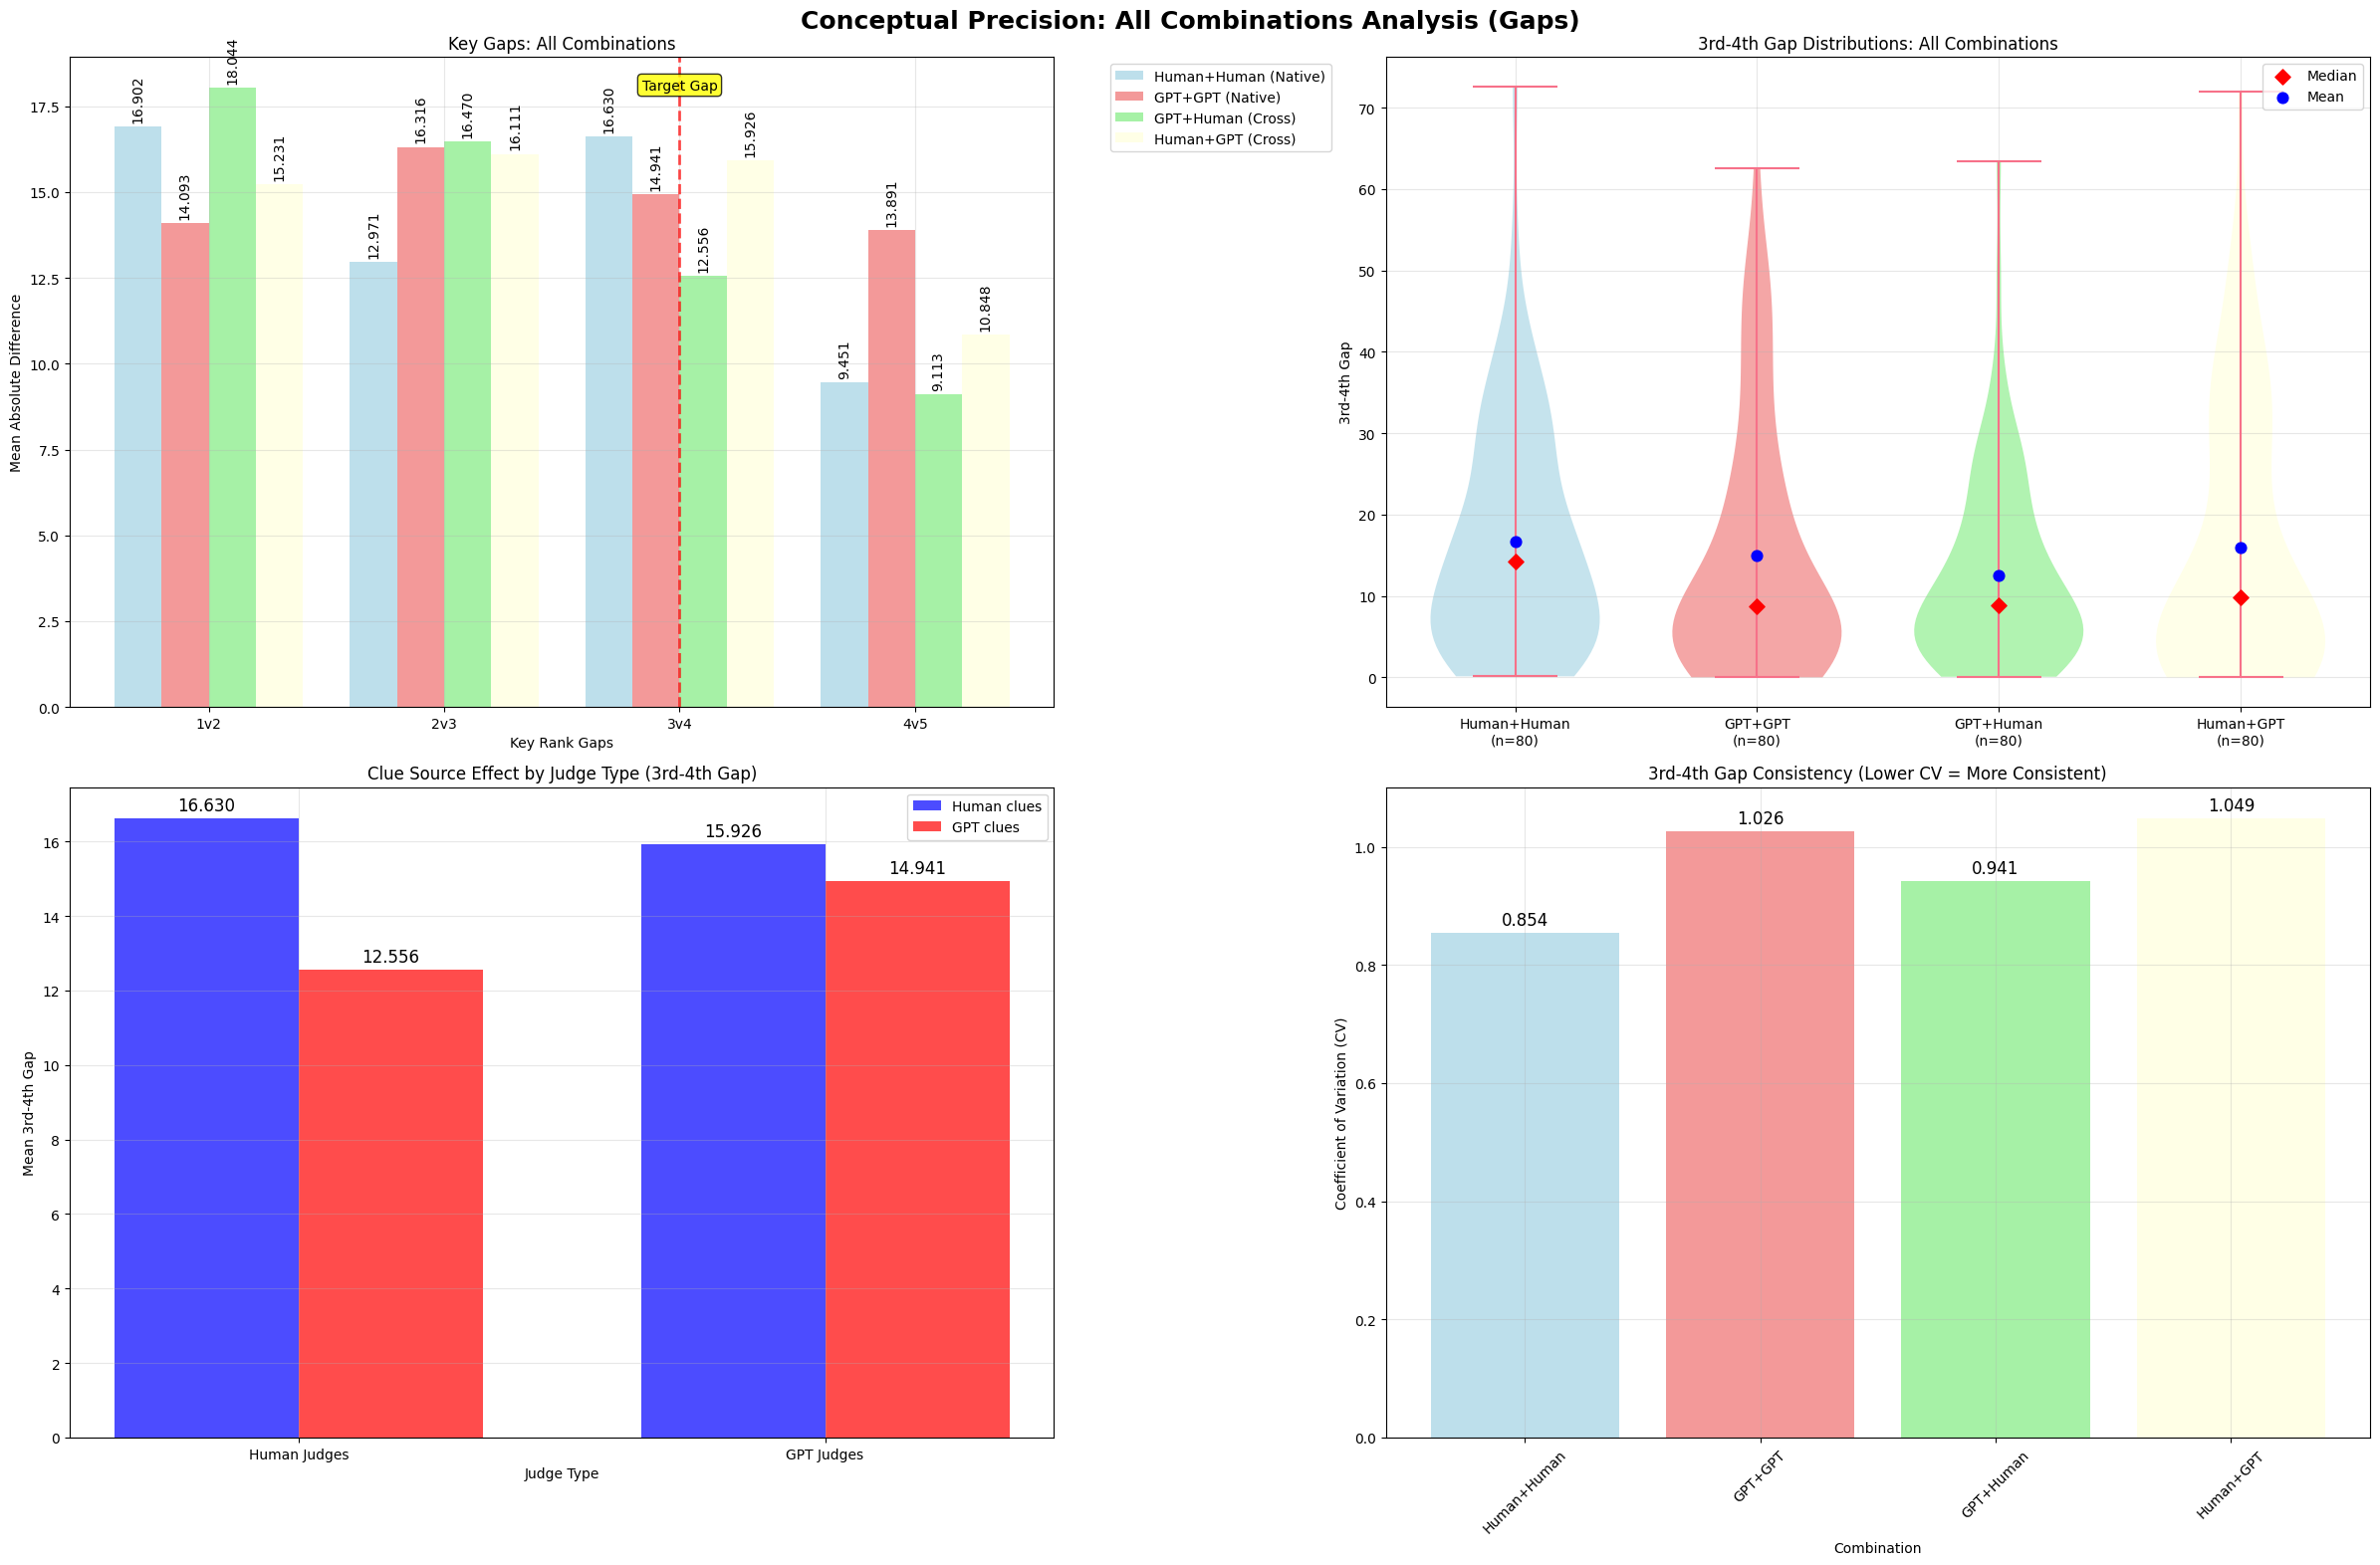

Detailed 3v4 analysis figure saved as 'conceptual_precision_3v4_detailed_analysis.png'


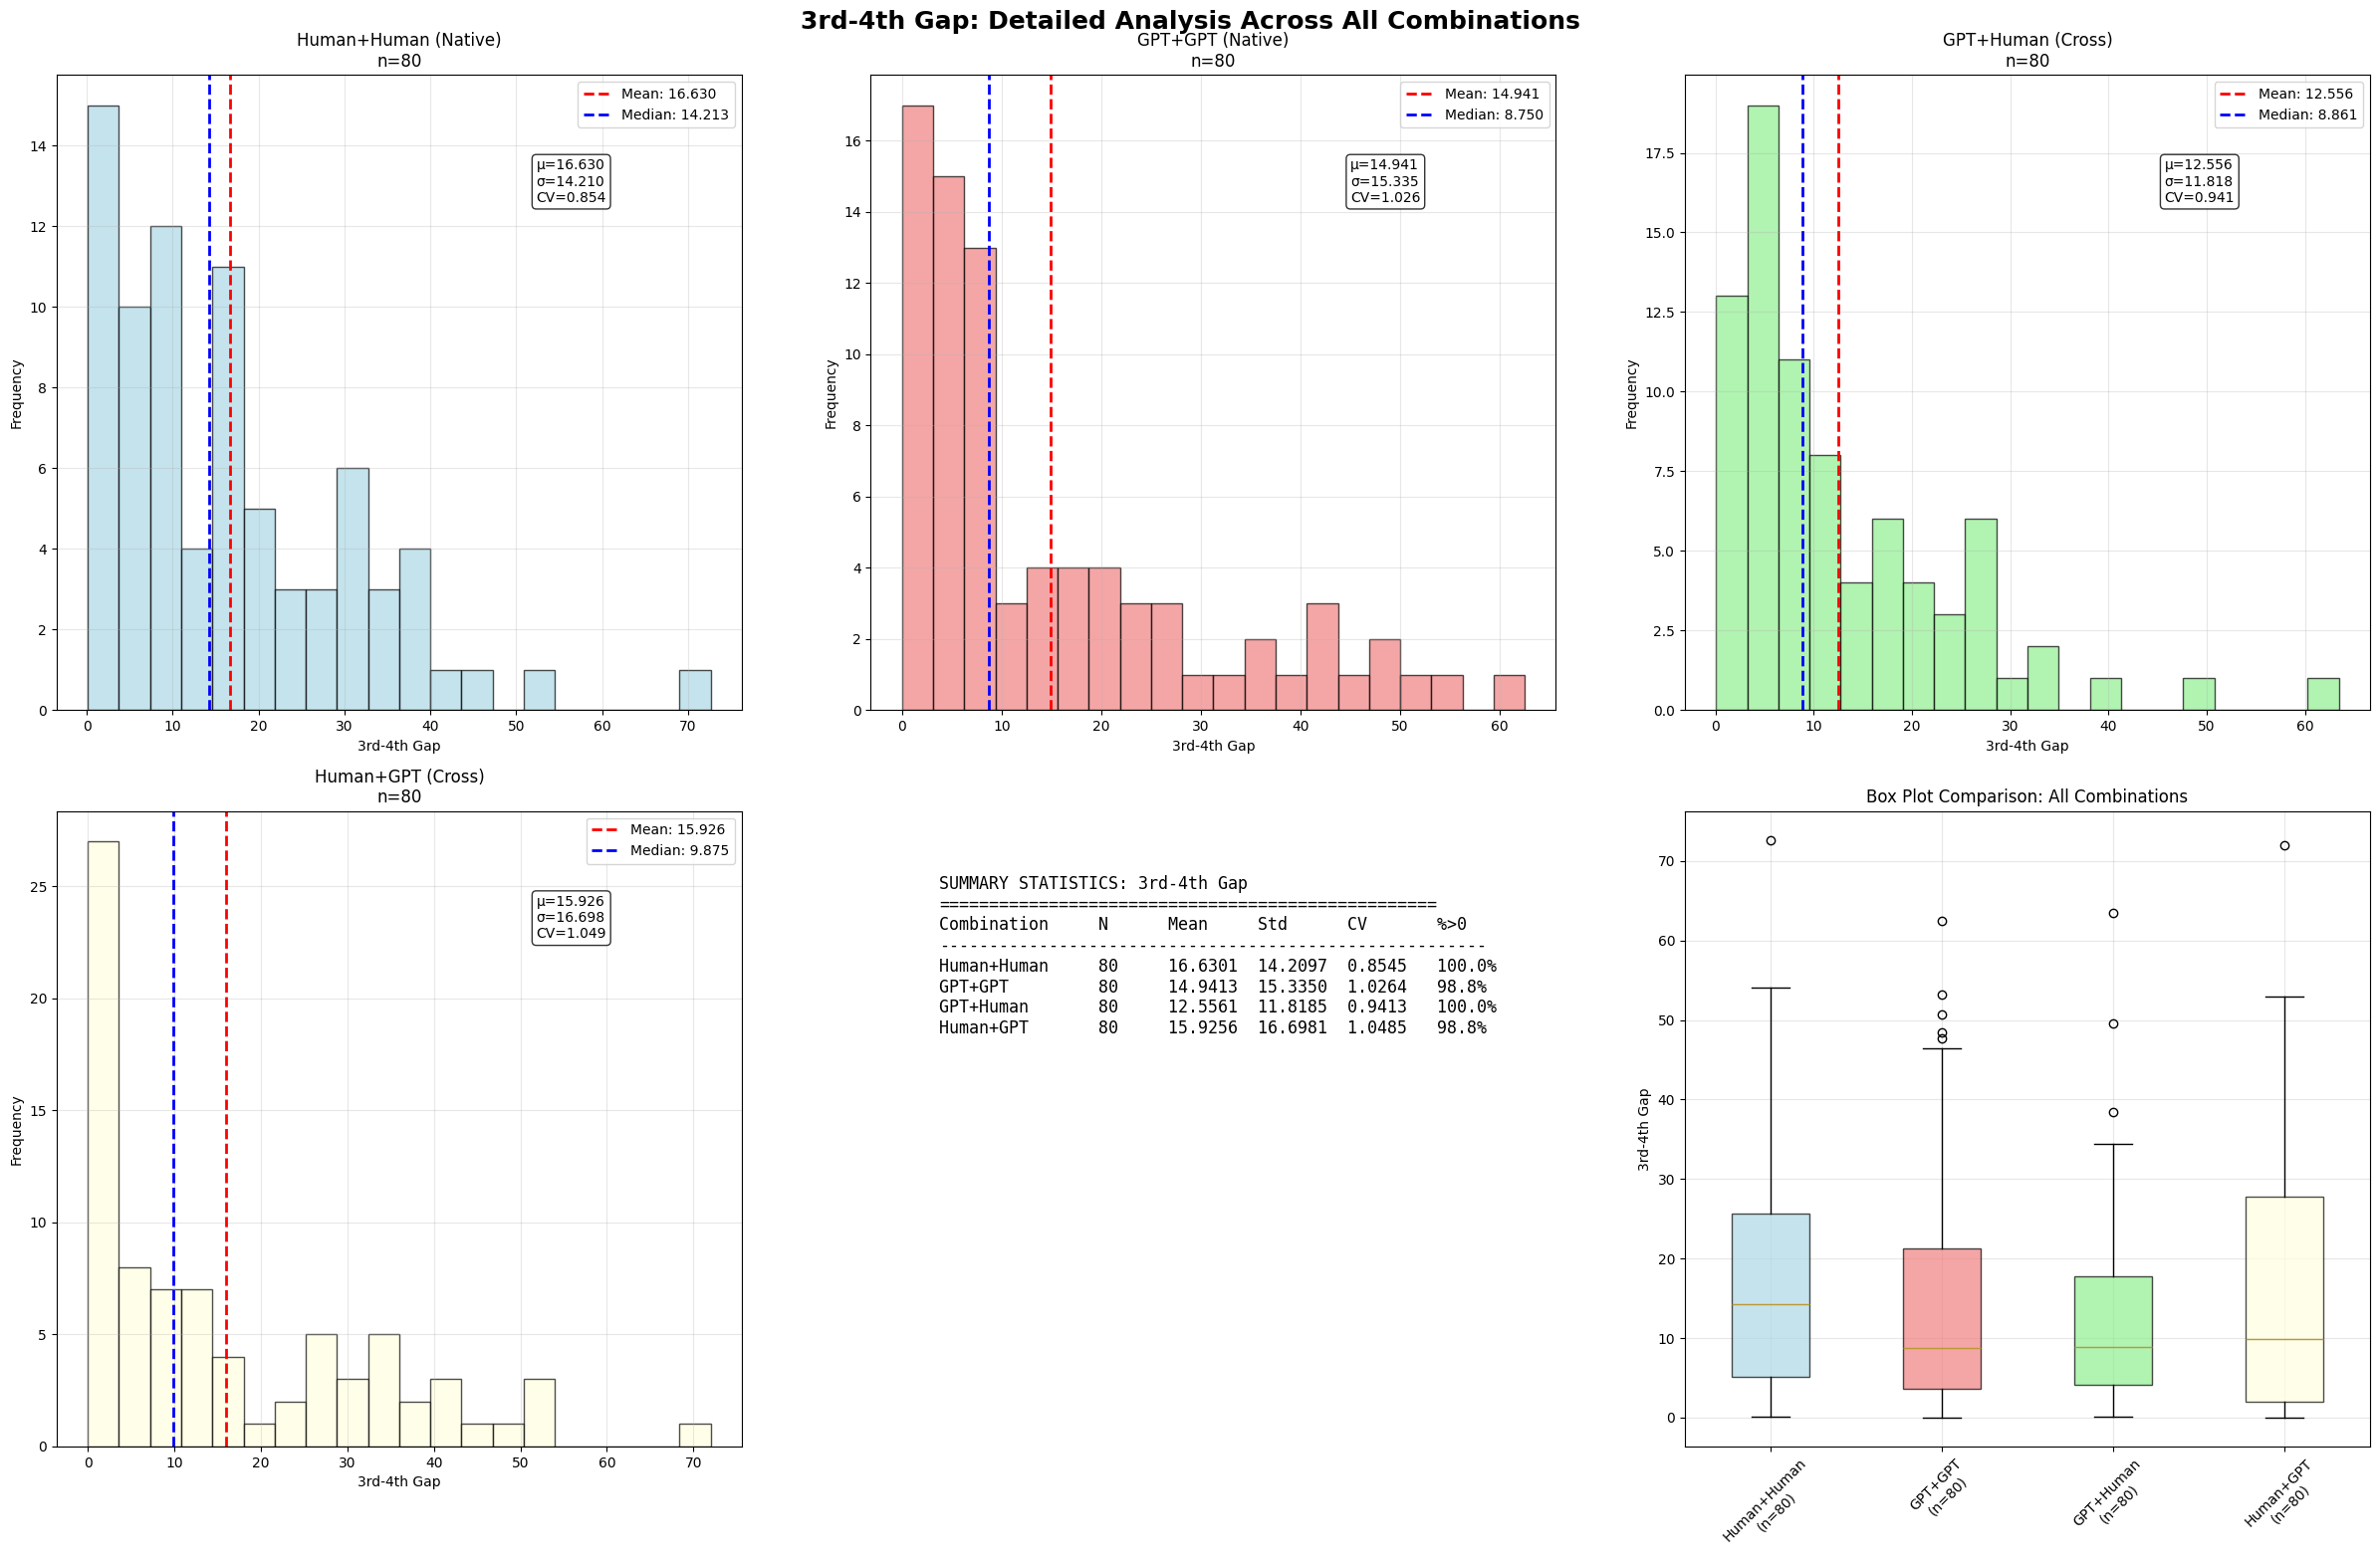

Cross-condition analysis figure saved as 'conceptual_precision_cross_analysis.png'


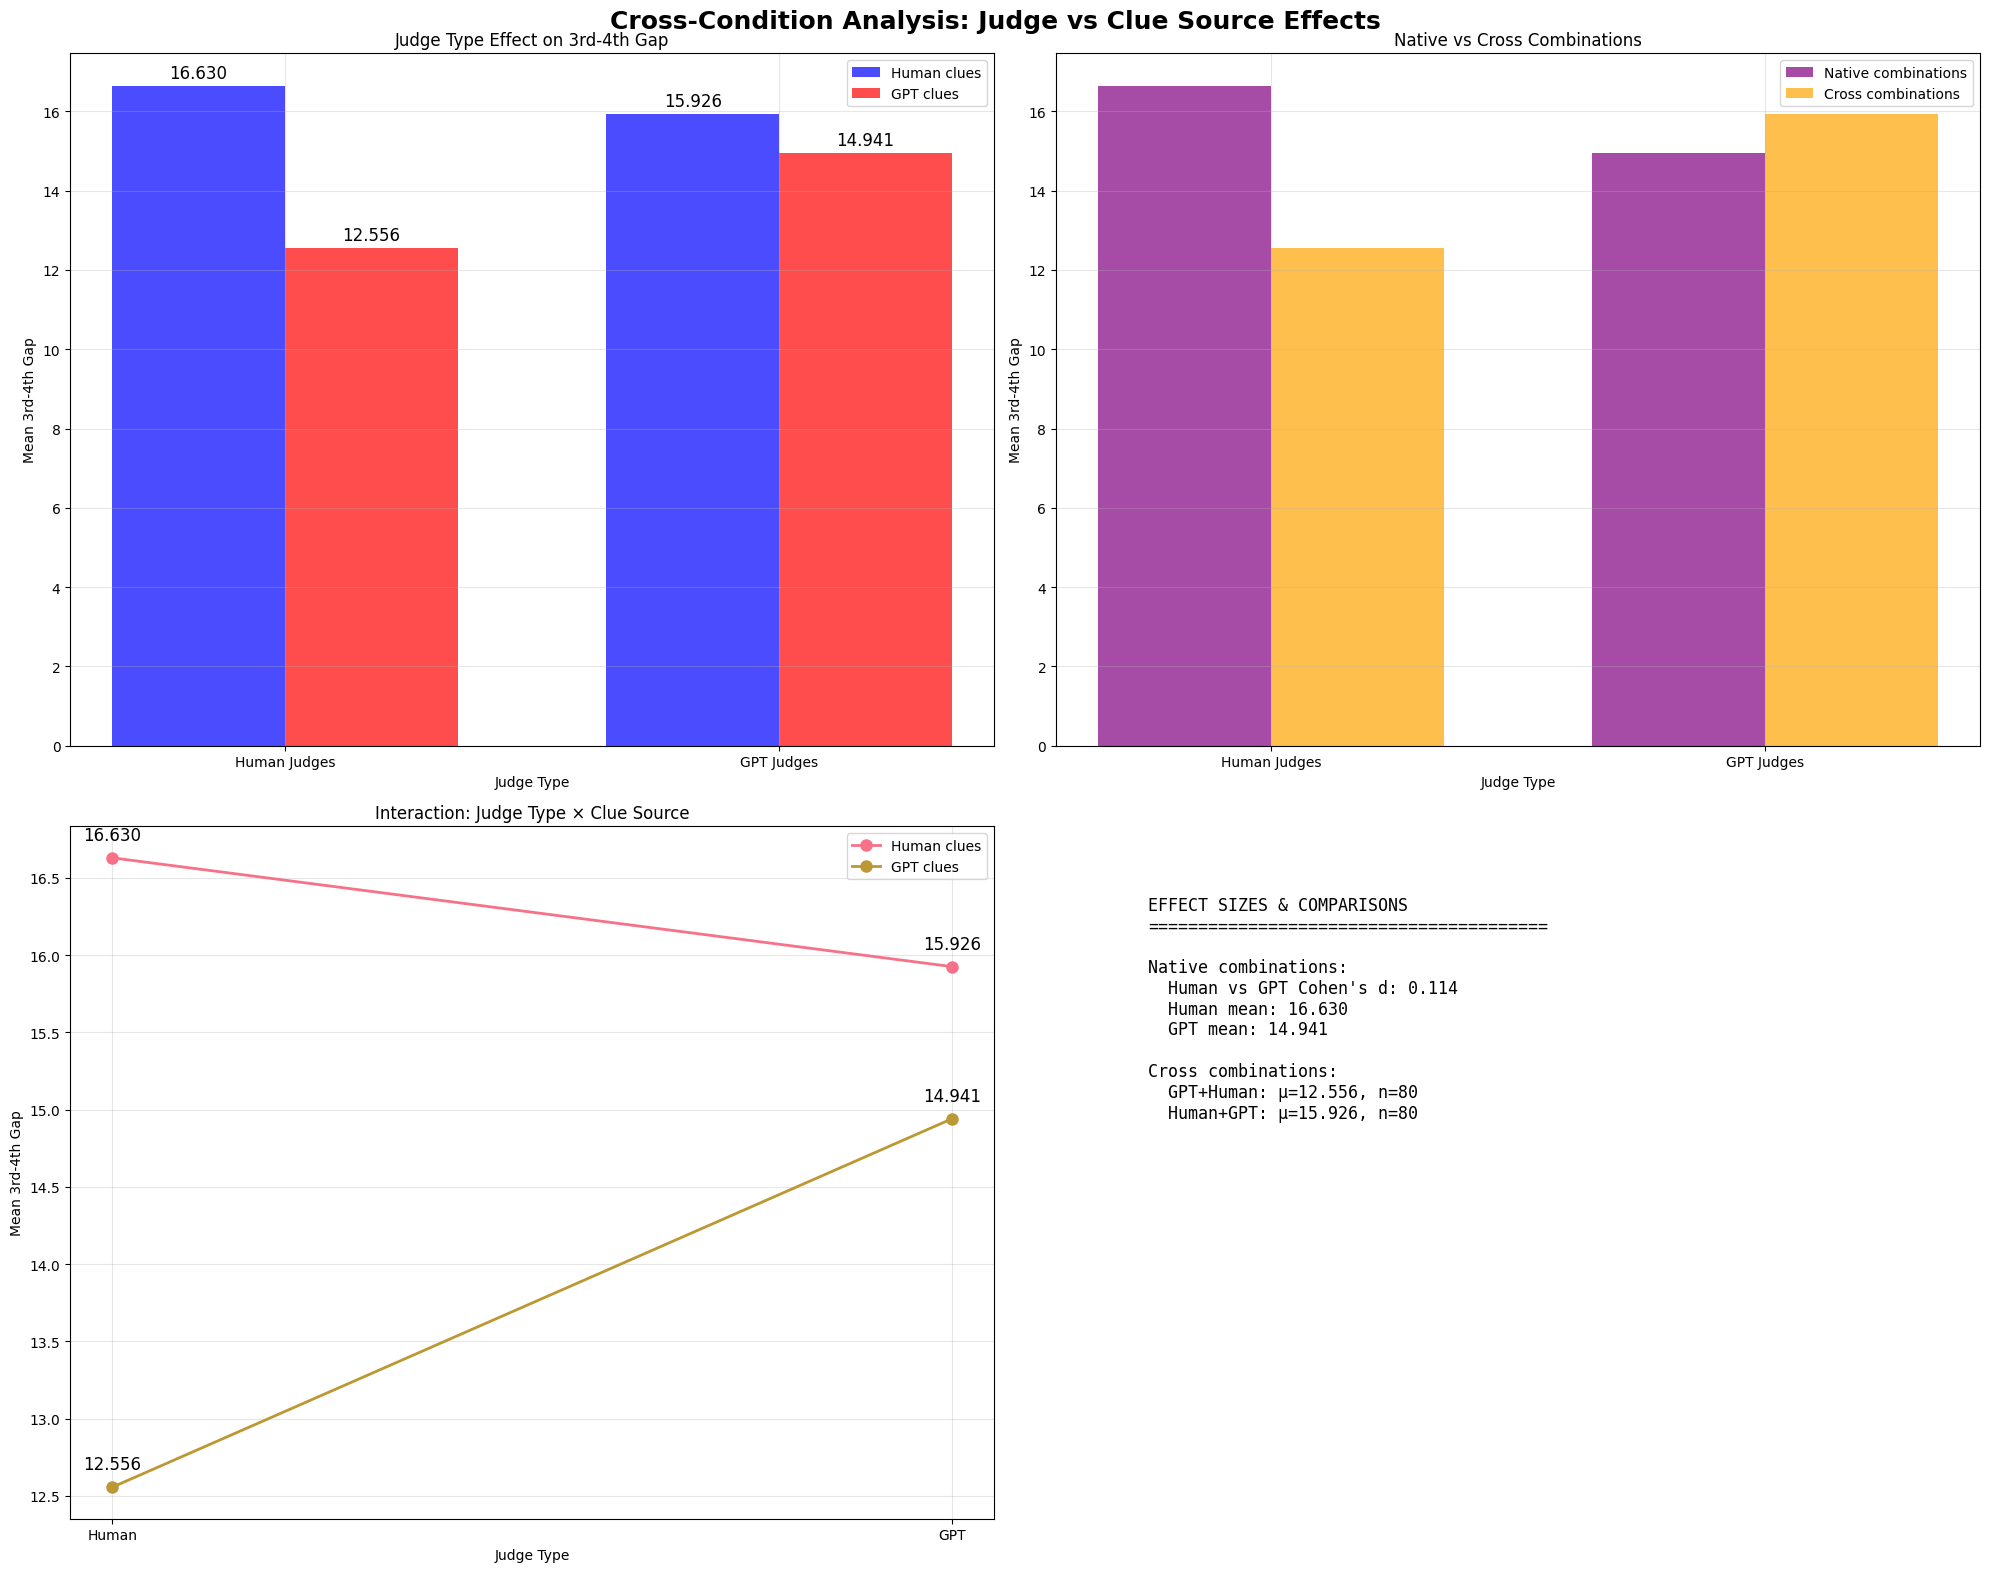

Normalizing...
Creating normalized version of results...
Found 12 rank score columns for normalization
Columns: ['rank_1_score', 'rank_2_score', 'rank_3_score', 'rank_4_score', 'rank_5_score', 'rank_6_score', 'rank_7_score', 'rank_8_score', 'rank_9_score', 'rank_10_score', 'rank_11_score', 'rank_12_score']
Normalization complete. Sample normalized gap_3v4 range: 0.00000 to 0.23928
Performing statistical analysis (normalized)...
=== CONCEPTUAL PRECISION ANALYSIS: COMPREHENSIVE GAP ANALYSIS ===
(Measuring ability to distinguish the 3 intended words from other board words)
Gap = 3rd most related score - 4th most related score
Higher gaps = better conceptual precision

SAMPLE SIZES:
Human clues + Human judges (native): n=80
GPT clues + GPT judges (native): n=80
GPT clues + Human judges (cross): n=80
Human clues + GPT judges (cross): n=80

1. NATIVE COMBINATIONS: Human+Human vs GPT+GPT
Human native: mean=0.051, std=0.044
GPT native: mean=0.036, std=0.037
Independent t-test: t=2.324, p=0.021

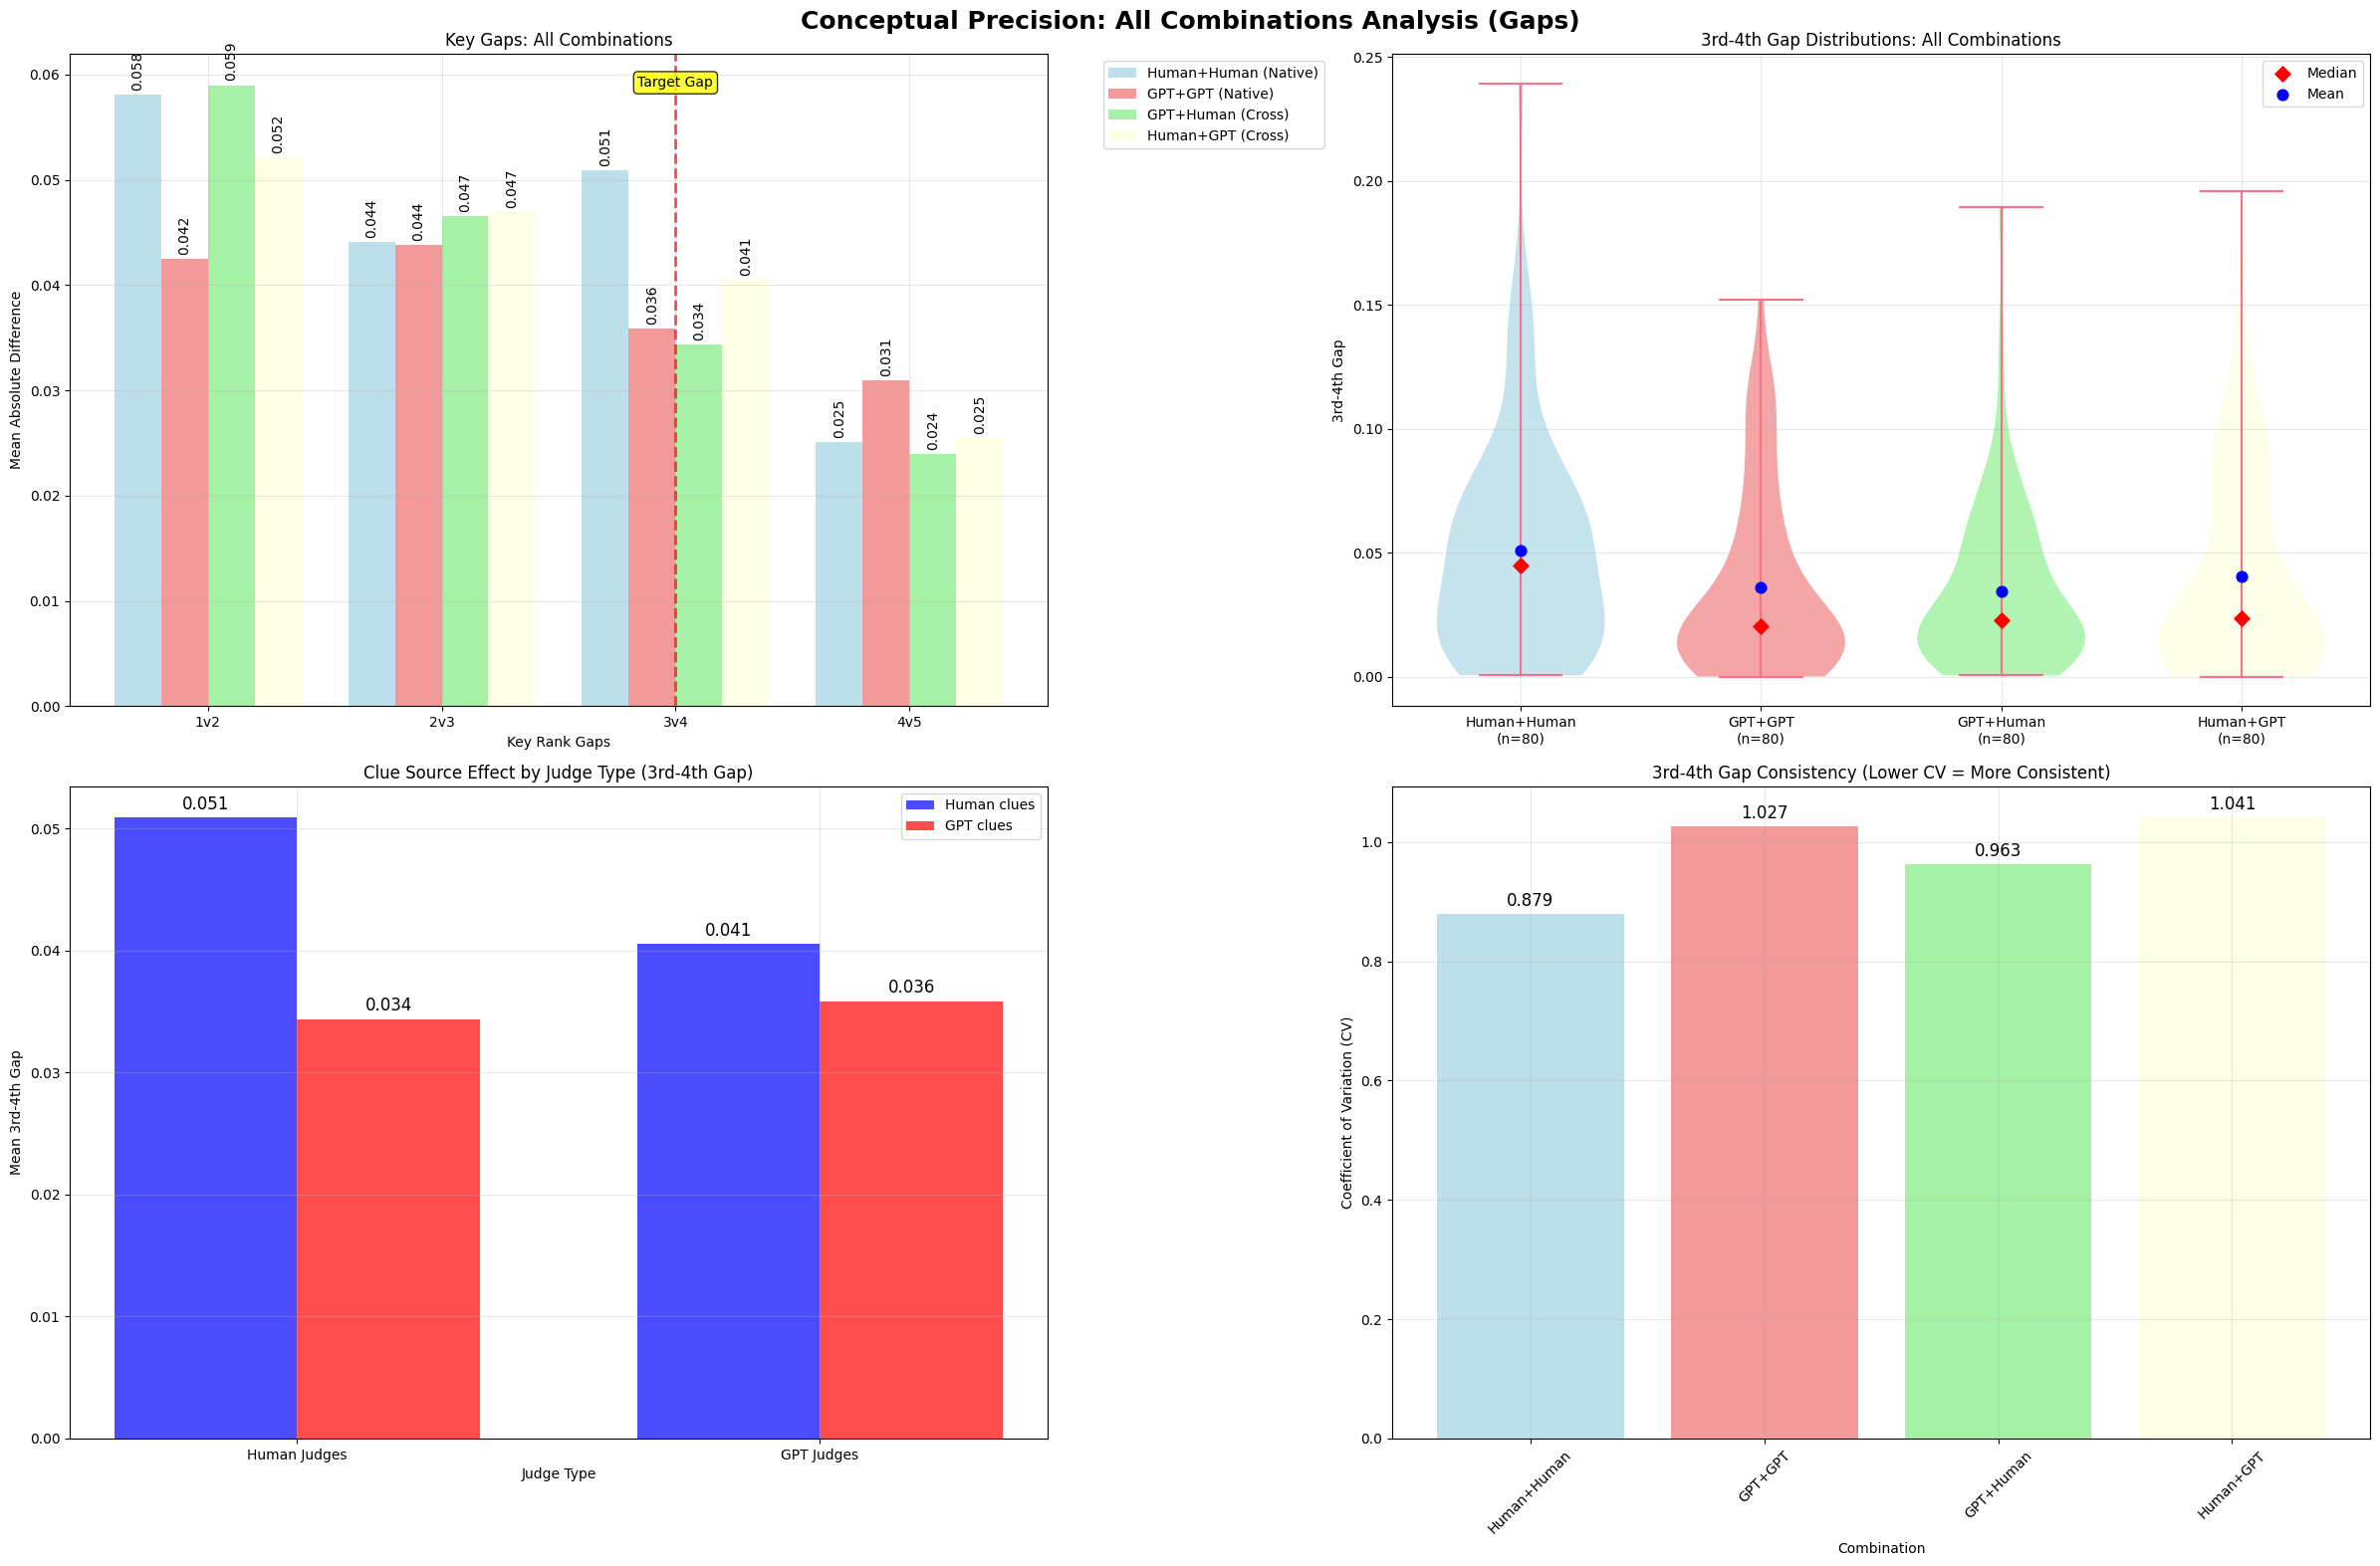

Detailed 3v4 analysis figure saved as 'conceptual_precision_3v4_detailed_analysis.png'


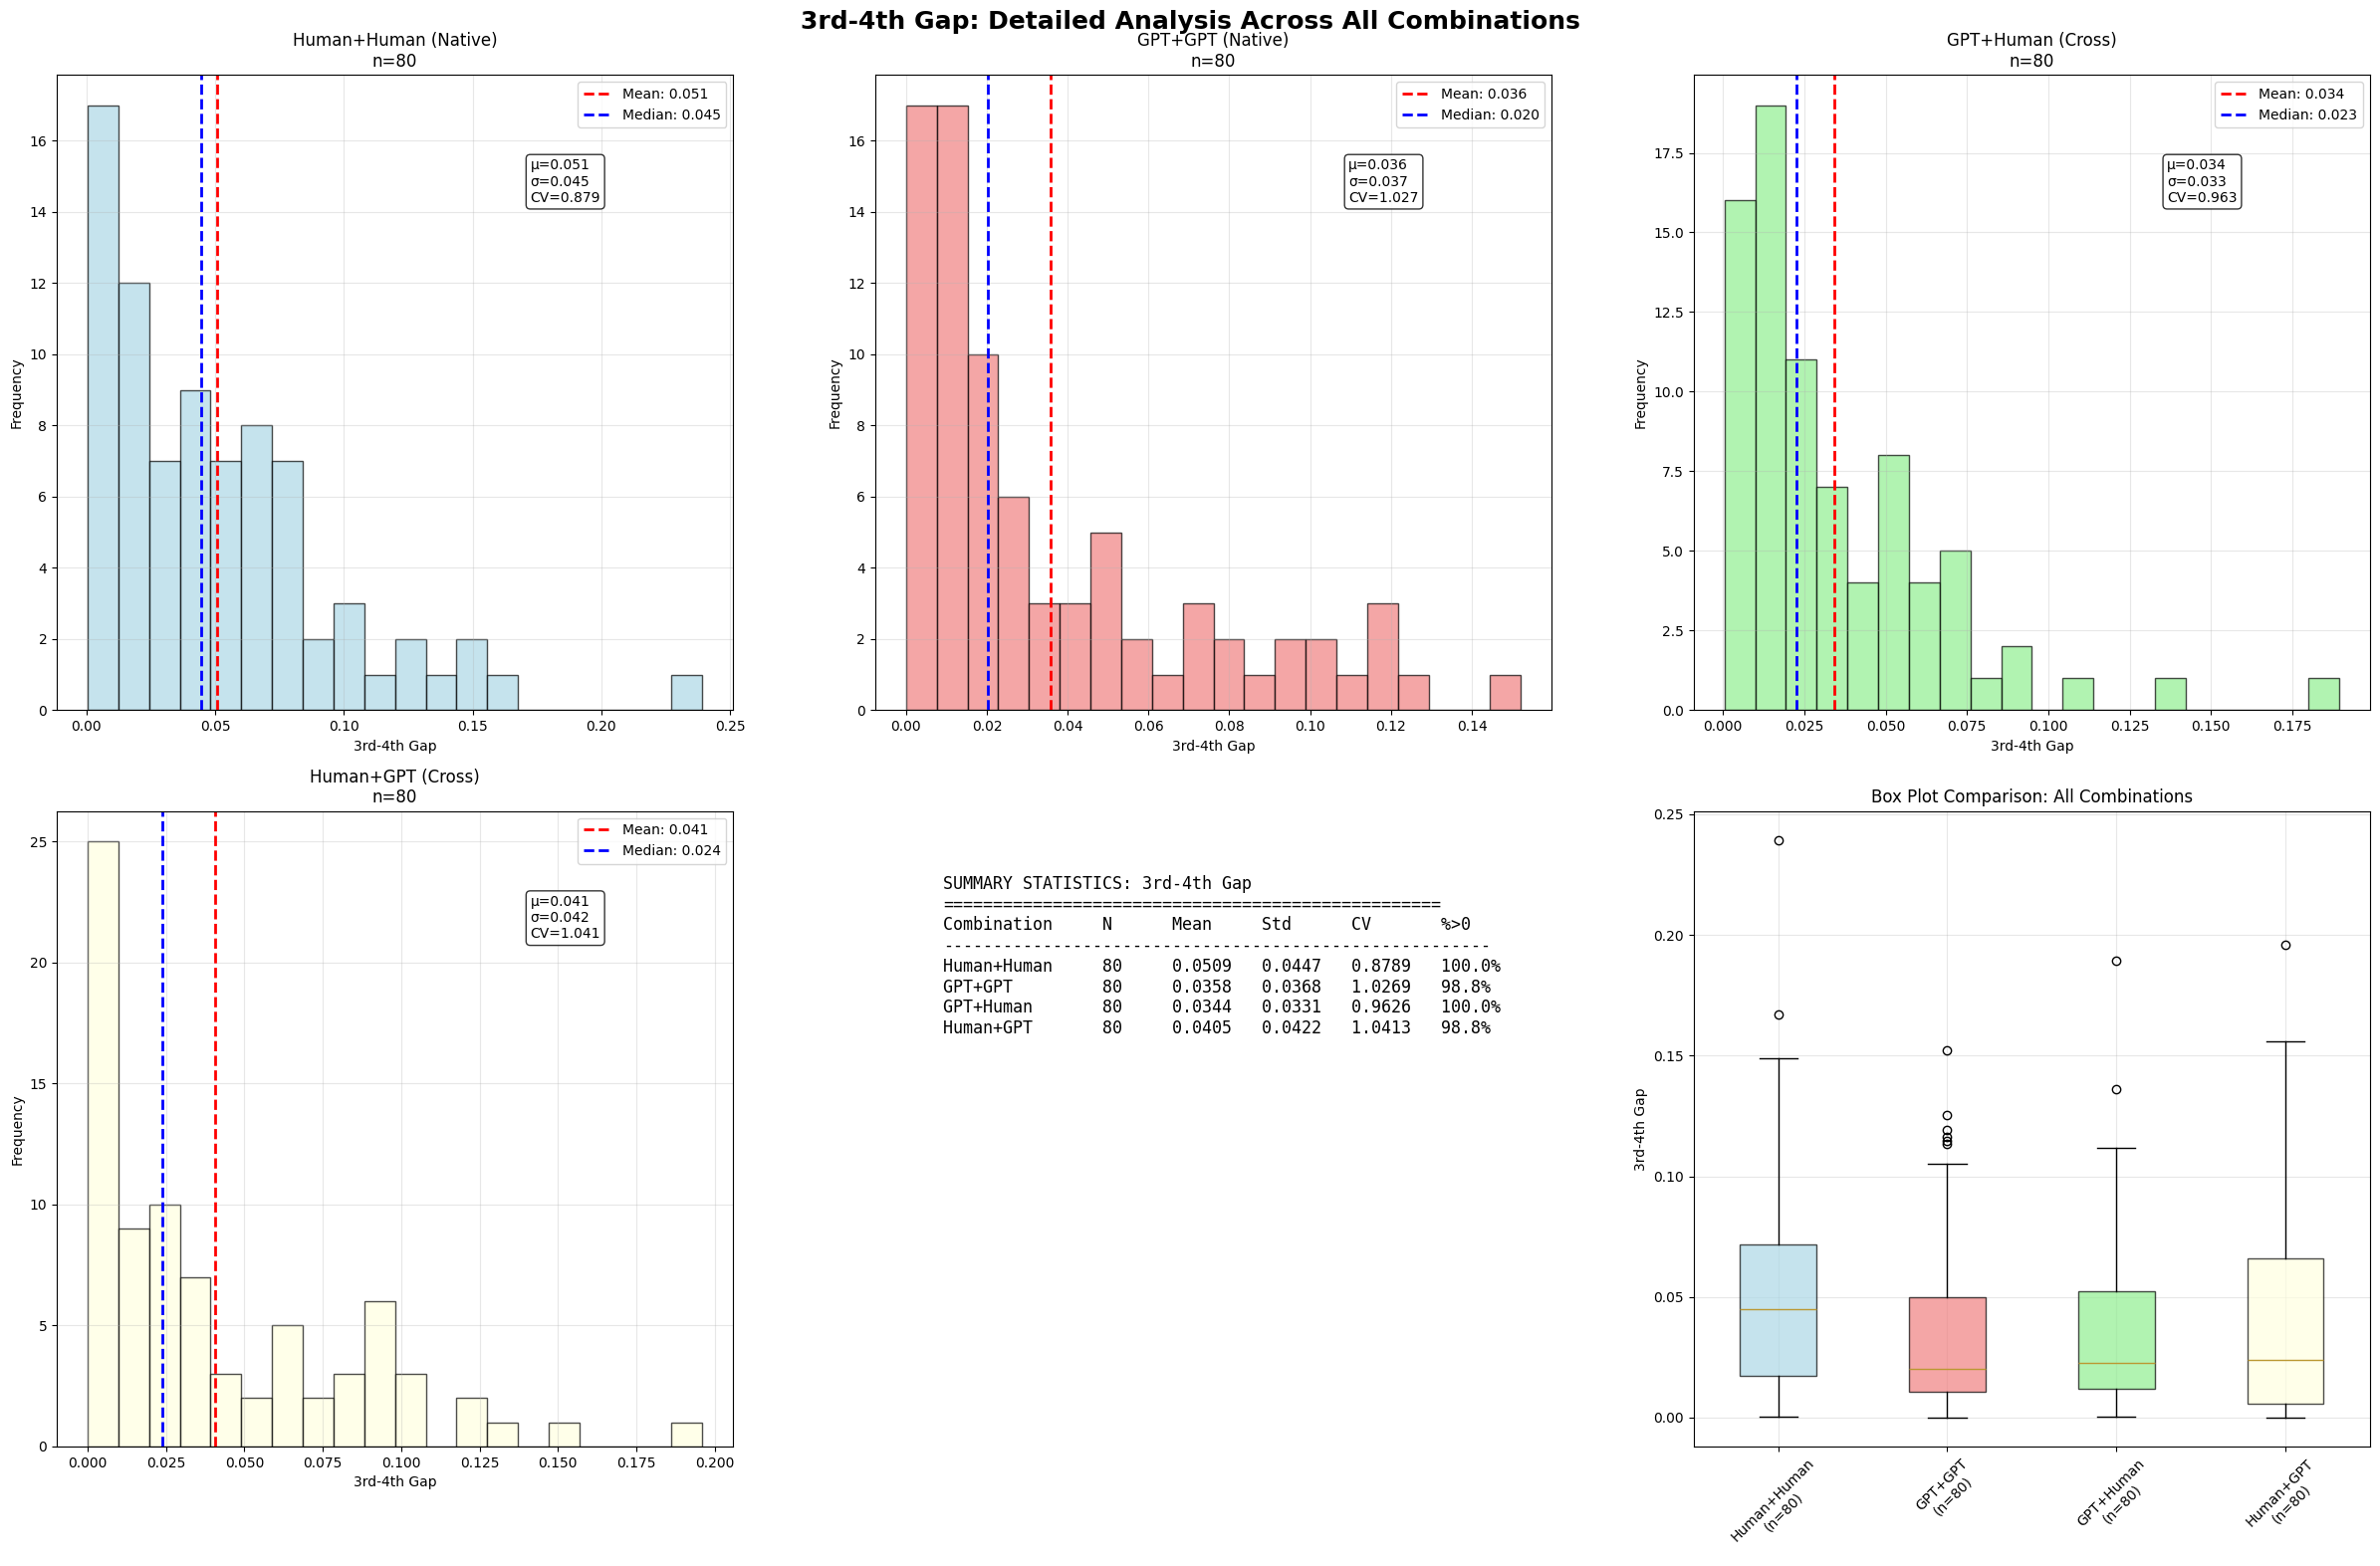

Cross-condition analysis figure saved as 'conceptual_precision_cross_analysis.png'


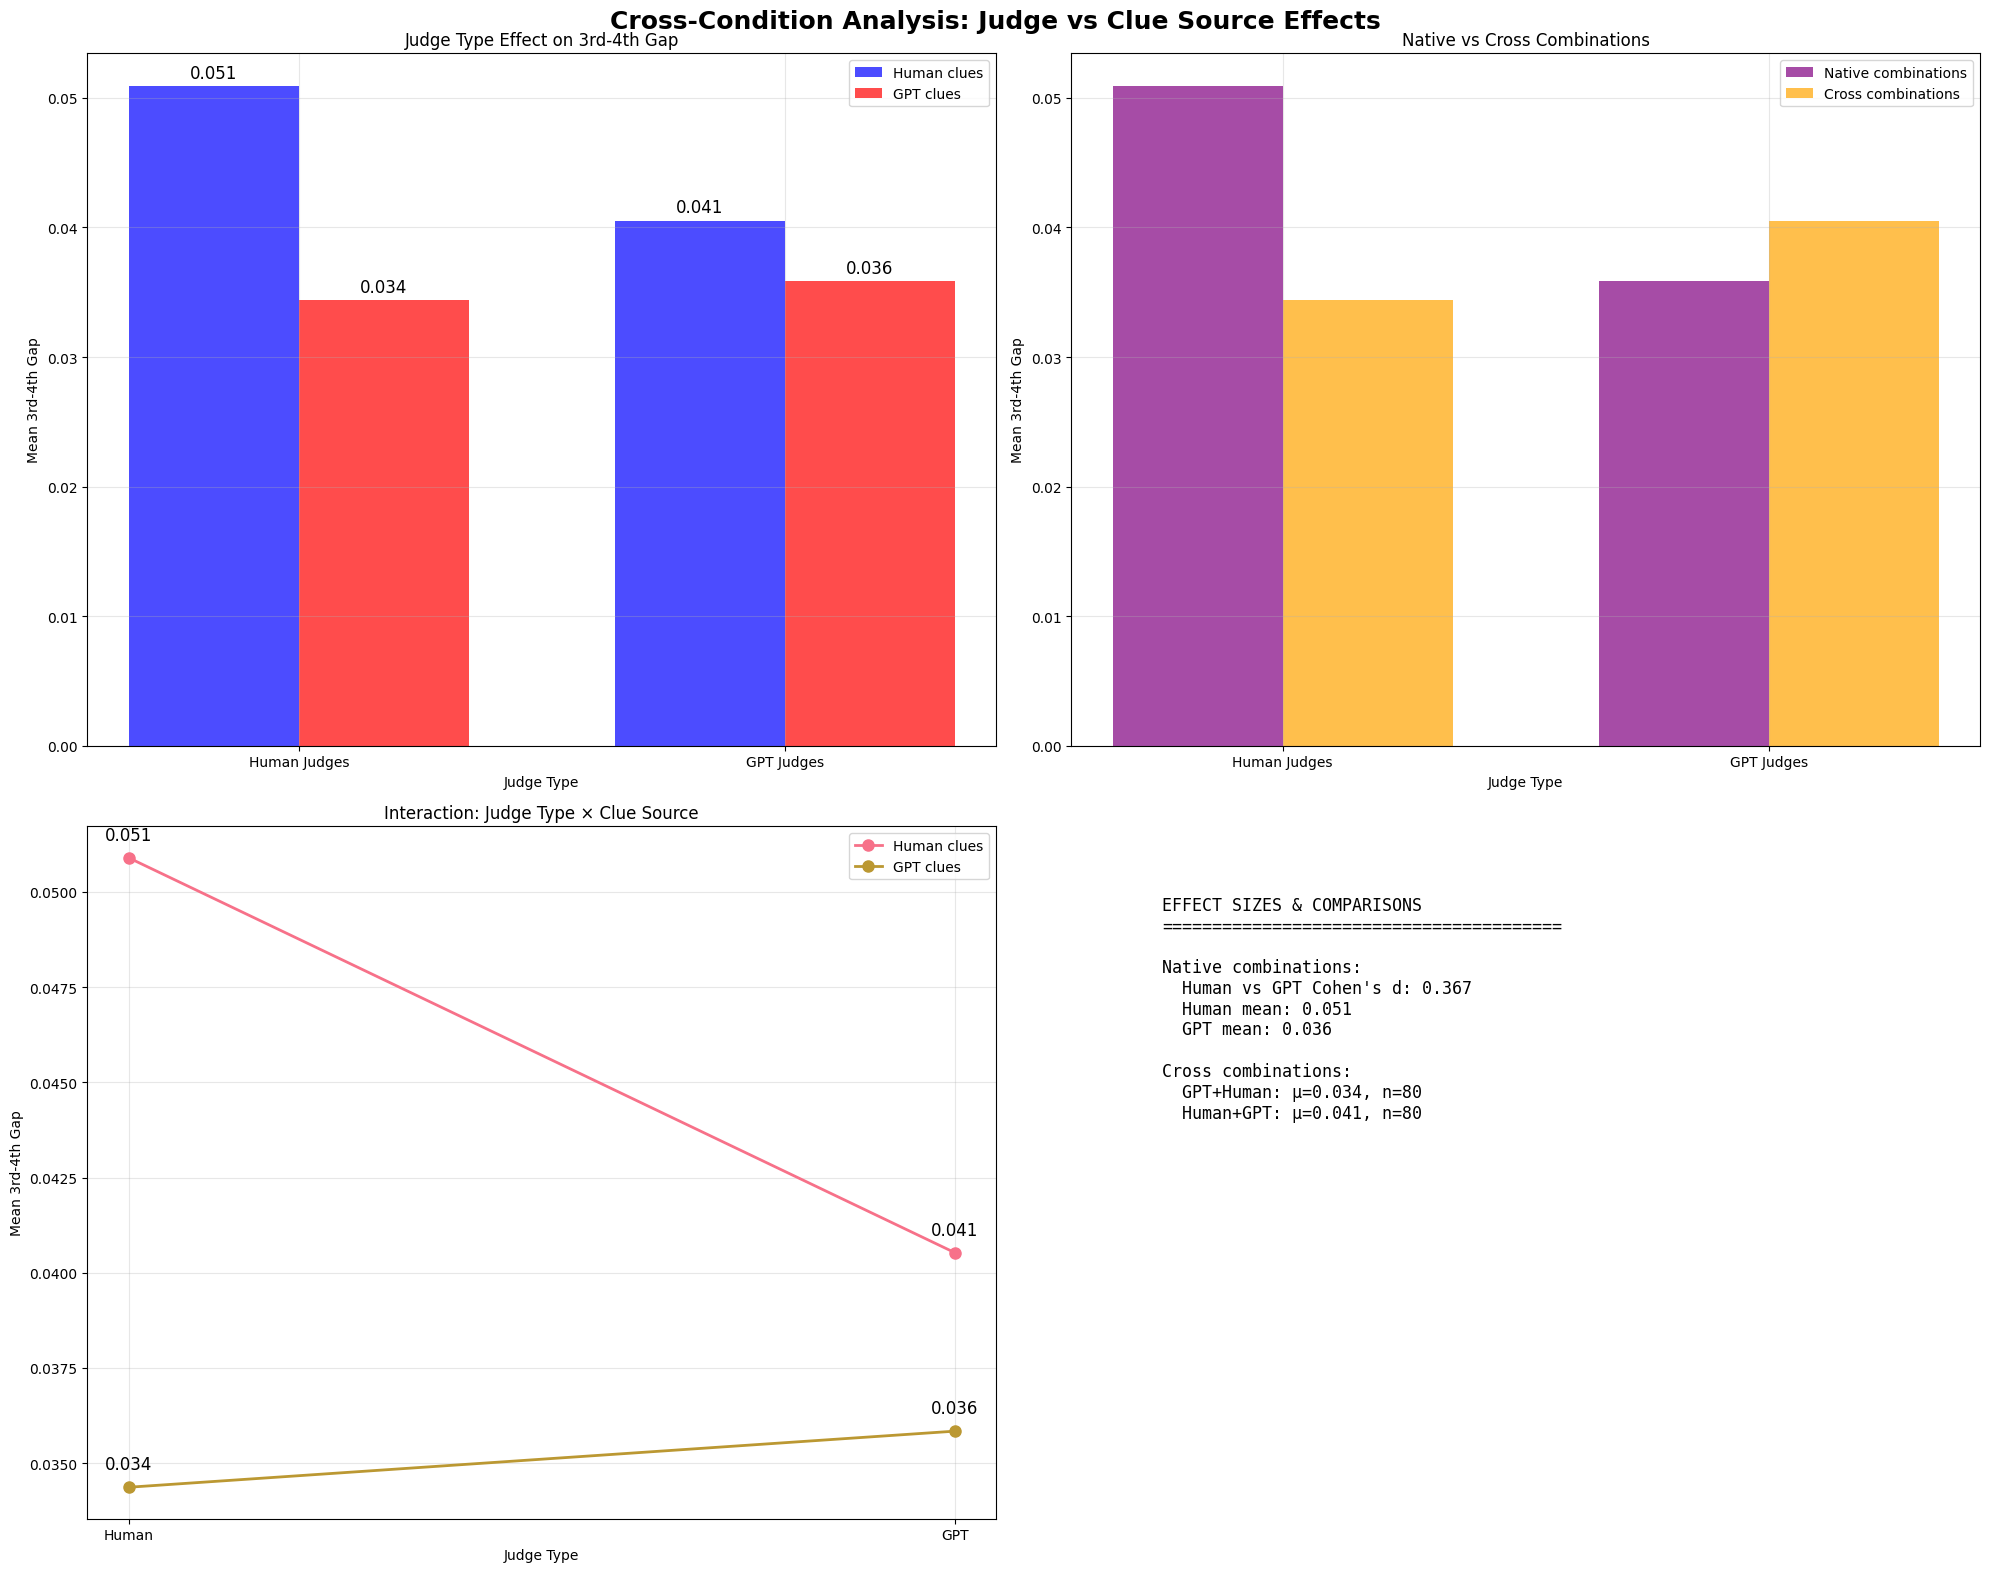

In [35]:
board_relatedness_gaps()

In [36]:
results = analyze_gap_differences(boards_data, relatedness_data)

NameError: name 'analyze_gap_differences' is not defined

In [ ]:
def find_complete_boards(boards_data, relatedness_data):

    relatedness_combinations = set()
    for entry in relatedness_data:
        clue = entry['clue']
        word = entry['word']
        judge_source = entry['source']
        if entry['relatedness']:
            relatedness_combinations.add((clue, word, judge_source))
    
    complete_boards = []
    
    for board_key, board_data in boards_data.items():
        words = board_data['words']
        has_complete_data = True
        
        has_human_clue = 'human_clue' in board_data and board_data['human_clue']
        has_gpt_clue = 'gpt_clue' in board_data and board_data['gpt_clue']
        
        if not (has_human_clue and has_gpt_clue):
            continue
        
        human_clue = board_data['human_clue']
        gpt_clue = board_data['gpt_clue']
        

        required_combinations = []
        
        for word in words:
            required_combinations.extend([
                (human_clue, word, 'human'),  # Human judge on human clue
                (gpt_clue, word, 'human'),    # Human judge on GPT clue
                (human_clue, word, 'gpt'),    # GPT judge on human clue
                (gpt_clue, word, 'gpt')       # GPT judge on GPT clue
            ])
        
        for combo in required_combinations:
            if combo not in relatedness_combinations:
                has_complete_data = False
                break
        
        if has_complete_data:
            complete_boards.append(board_key)
    
    print(f"Found {len(complete_boards)} boards with complete relatedness data")
    return complete_boards

def analyze_board_based_relatedness(boards_data, relatedness_data):
    """
    Analyze relatedness at the board level - each board contributes exactly
    the expected number of target and non-target scores.
    """
    
    # find boards with complete data
    complete_board_keys = find_complete_boards(boards_data, relatedness_data)
    
    if len(complete_board_keys) == 0:
        print("No boards found with complete relatedness data!")
        return {}
    
    # filter boards_data to only include complete boards
    filtered_boards_data = {k: v for k, v in boards_data.items() if k in complete_board_keys}
    
    print(f"Analyzing {len(filtered_boards_data)} complete boards")
    
    # create relatedness lookup
    relatedness_lookup, variance_info = create_relatedness_lookup(relatedness_data)
    
    print(f"Relatedness lookup contains {len(relatedness_lookup)} unique clue-word-judge combinations")
    
    # analyze each source separately (matching judge type with clue type)
    results = {}
    
    for source_type in ['human', 'gpt']:
        target_scores = []
        nontarget_scores = []
        missing_data_count = 0
        
        print(f"\n=== Processing {source_type.upper()} boards ===")
        
        # Process each board individually
        for board_key, board_data in filtered_boards_data.items():
            words = board_data['words']
            
            # Get clue and intended words for this source type
            if source_type == 'human':
                clue = board_data.get('human_clue')
                intended_words = board_data.get('human_intended_words', [])
            else:  # gpt
                clue = board_data.get('gpt_clue')
                intended_words = board_data.get('gpt_intended_words', [])
            
            if not clue or not intended_words:
                continue
            
            # Process each word on this board
            for word in words:
                # Look up relatedness score for this clue-word pair with matching judge
                lookup_key = (clue, word, source_type)
                
                if lookup_key in relatedness_lookup:
                    relatedness_score = relatedness_lookup[lookup_key]
                    
                    # Determine if this is a target or non-target word for this board
                    if word in intended_words:
                        target_scores.append(relatedness_score)
                    else:
                        nontarget_scores.append(relatedness_score)
                else:
                    missing_data_count += 1
                    print(f"Warning: Missing data for board {board_key}, clue '{clue}', word '{word}', judge '{source_type}'")
        
        if missing_data_count > 0:
            print(f"Total missing data points for {source_type}: {missing_data_count}")
        
        if len(target_scores) == 0 or len(nontarget_scores) == 0:
            print(f"\nWarning: No data found for {source_type} judge on {source_type} clues")
            continue
        
        # Verify expected sample sizes
        expected_targets = len(filtered_boards_data) * 3  # 3 intended words per board
        expected_nontargets = len(filtered_boards_data) * 9  # 9 non-intended words per board (assuming 12 words total)
        
        print(f"Expected targets: {expected_targets}, Got: {len(target_scores)}")
        print(f"Expected non-targets: {expected_nontargets}, Got: {len(nontarget_scores)}")
        
        # statistics
        target_mean = np.mean(target_scores)
        nontarget_mean = np.mean(nontarget_scores)
        t_stat, p_value = scipy.stats.ttest_ind(target_scores, nontarget_scores)
        df = len(target_scores) + len(nontarget_scores) - 2
        
        # Print results
        print(f"\n=== {source_type.upper()} Judge on {source_type.upper()} Clues (Board-Based Analysis) ===")
        print(f"Target words relatedness: M = {target_mean:.2f} (n = {len(target_scores)})")
        print(f"Non-target words relatedness: M = {nontarget_mean:.2f} (n = {len(nontarget_scores)})")
        print(f"t-test: t({df}) = {t_stat:.2f}, p = {p_value:.6f}")
        

        if p_value < 0.001:
            p_str = "p < 0.001"
        elif p_value < 0.01:
            p_str = "p < 0.01"
        elif p_value < 0.05:
            p_str = "p < 0.05"
        else:
            p_str = f"p = {p_value:.3f}"
        
        judge_label = "human judges" if source_type == 'human' else "GPT judges"
        clue_label = "human-generated" if source_type == 'human' else "GPT-generated"
        # example:
        paper_format = f"Using the {len(complete_board_keys)} boards with complete relatedness data, for {clue_label} clues as rated by {judge_label}, target words were more related to the clue (M={target_mean:.2f}) than non-target words (M={nontarget_mean:.2f}), t({df})={t_stat:.2f}, {p_str}."
        
        print(f"\nFormatted for paper:")
        print(paper_format)
        
        results[source_type] = {
            'target_mean': target_mean,
            'nontarget_mean': nontarget_mean,
            'target_scores': target_scores,
            'nontarget_scores': nontarget_scores,
            't_stat': t_stat,
            'p_value': p_value,
            'df': df,
            'paper_format': paper_format,
            'n_boards': len(complete_board_keys),
            'expected_targets': expected_targets,
            'expected_nontargets': expected_nontargets
        }
    
    return results

def get_board_completeness_summary(boards_data, relatedness_data):
    """
    Get a summary of data completeness across boards.
    """
    complete_board_keys = find_complete_boards(boards_data, relatedness_data)
    
    total_boards = len(boards_data)
    complete_boards = len(complete_board_keys)
    
    print(f"\n=== Data Completeness Summary ===")
    print(f"Total boards: {total_boards}")
    print(f"Complete boards: {complete_boards}")
    print(f"Percentage complete: {(complete_boards/total_boards)*100:.1f}%")
    
    return {
        'total_boards': total_boards,
        'complete_boards': complete_boards,
        'complete_board_keys': complete_board_keys,
        'completeness_rate': complete_boards/total_boards
    }

In [ ]:
results = analyze_board_based_relatedness(boards_data, relatedness_data)

Found 80 boards with complete relatedness data
Analyzing 80 complete boards
Relatedness lookup contains 10323 unique clue-word-judge combinations

=== Processing HUMAN boards ===
Expected targets: 240, Got: 240
Expected non-targets: 720, Got: 720

=== HUMAN Judge on HUMAN Clues (Board-Based Analysis) ===
Target words relatedness: M = 62.82 (n = 240)
Non-target words relatedness: M = 17.54 (n = 720)
t-test: t(958) = 31.88, p = 0.000000

Formatted for paper:
Using the 80 boards with complete relatedness data, for human-generated clues as rated by human judges, target words were more related to the clue (M=62.82) than non-target words (M=17.54), t(958)=31.88, p < 0.001.

=== Processing GPT boards ===
Expected targets: 240, Got: 240
Expected non-targets: 720, Got: 720

=== GPT Judge on GPT Clues (Board-Based Analysis) ===
Target words relatedness: M = 70.39 (n = 240)
Non-target words relatedness: M = 23.63 (n = 720)
t-test: t(958) = 30.66, p = 0.000000

Formatted for paper:
Using the 80 bo

In [ ]:
def calculate_same_agent_gaps(boards_data, relatedness_data):
    relatedness_lookup = create_relatedness_lookup(relatedness_data)
    
    # Find complete boards
    complete_boards = find_complete_boards(boards_data, relatedness_lookup)
    print(f"Found {len(complete_boards)} boards with complete relatedness data")
    
    human_on_human_clue_gaps = []  # Humans responding to human clues (using human relatedness)
    gpt_on_gpt_clue_gaps = []      # GPT responding to GPT clues (using GPT relatedness)
    
    for board_key, board_data in complete_boards:
        words = board_data['words']
        
        # Human guesses on human clues (using human relatedness judgments)
        if 'human_guess_human_clue' in board_data:
            human_gap = calculate_guess_gap_for_specific_clue_type(
                board_data['human_guess_human_clue'], 
                words, 
                relatedness_lookup, 
                board_data, 
                'human',  # Use human relatedness judgments (guesser's judgment)
                'human_clue'  # Use human clue for relatedness lookup
            )
            if human_gap is not None:
                human_on_human_clue_gaps.append(human_gap)
        
        # GPT guesses on GPT clues (using GPT relatedness judgments)
        if 'gpt_guess_gpt_clue' in board_data:
            gpt_gap = calculate_guess_gap_for_specific_clue_type(
                board_data['gpt_guess_gpt_clue'],
                words,
                relatedness_lookup,
                board_data,
                'gpt',  # Use GPT relatedness judgments (guesser's judgment)
                'gpt_clue'  # Use GPT clue for relatedness lookup
            )
            if gpt_gap is not None:
                gpt_on_gpt_clue_gaps.append(gpt_gap)
    
    return human_on_human_clue_gaps, gpt_on_gpt_clue_gaps

def calculate_cross_agent_gaps(boards_data, relatedness_data):
    """
    Calculate cross-agent conditions: humans on GPT clues vs GPT on human clues.
    Uses guesser's relatedness judgments.
    """
    relatedness_lookup = create_relatedness_lookup(relatedness_data)
    
    # Find complete boards
    complete_boards = find_complete_boards(boards_data, relatedness_lookup)
    print(f"Found {len(complete_boards)} boards with complete relatedness data")
    
    human_on_gpt_clue_gaps = []  # Humans responding to GPT clues (using human relatedness)
    gpt_on_human_clue_gaps = []  # GPT responding to human clues (using GPT relatedness)
    
    for board_key, board_data in complete_boards:
        words = board_data['words']
        
        # Human guesses on GPT clues (using human relatedness judgments)
        if 'human_guess_gpt_clue' in board_data:
            human_gap = calculate_guess_gap_for_specific_clue_type(
                board_data['human_guess_gpt_clue'], 
                words, 
                relatedness_lookup, 
                board_data, 
                'human',  # Use human relatedness judgments (guesser's judgment)
                'gpt_clue'  # Use GPT clue for relatedness lookup
            )
            if human_gap is not None:
                human_on_gpt_clue_gaps.append(human_gap)
        
        # GPT guesses on human clues (using GPT relatedness judgments)
        if 'gpt_guess_human_clue' in board_data:
            gpt_gap = calculate_guess_gap_for_specific_clue_type(
                board_data['gpt_guess_human_clue'],
                words,
                relatedness_lookup,
                board_data,
                'gpt',  # Use GPT relatedness judgments (guesser's judgment)
                'human_clue'  # Use human clue for relatedness lookup
            )
            if gpt_gap is not None:
                gpt_on_human_clue_gaps.append(gpt_gap)
    
    return human_on_gpt_clue_gaps, gpt_on_human_clue_gaps

def calculate_guess_gap_for_specific_clue_type(guess_sets, words, relatedness_lookup, 
                                             board_data, relatedness_agent, clue_type):
    """
    Args:
        guess_sets: The guess sequences for this condition
        words: Valid words on the board
        relatedness_lookup: Lookup table for relatedness scores
        board_data: Board data containing clues
        relatedness_agent: Which agent's relatedness judgments to use ('human' or 'gpt') - THE GUESSER'S judgment
        clue_type: Which clue to use ('human_clue' or 'gpt_clue')
    """
    if not guess_sets:
        return None
    
    # Flatten all guesses and count frequencies
    all_guesses = []
    for guess_sequence in guess_sets:
        all_guesses.extend(guess_sequence)
    
    # Count frequencies and filter to valid board words
    guess_counts = Counter(all_guesses)
    valid_ranked_guesses = [(word, count) for word, count in guess_counts.most_common() 
                           if word in words]
    
    # Need at least 4 different guesses
    if len(valid_ranked_guesses) < 4:
        return None
    
    third_word = valid_ranked_guesses[2][0]  # 3rd most common
    fourth_word = valid_ranked_guesses[3][0]  # 4th most common
    
    # Get the specific clue we want to use for relatedness
    if clue_type == 'gpt_clue':
        clue = board_data.get('gpt_clue')
    elif clue_type == 'human_clue':
        clue = board_data.get('human_clue')
    else:
        return None
    
    if clue is None:
        return None
    
    # Look up relatedness scores using the specified agent's judgments
    third_key = (clue, third_word, relatedness_agent)
    fourth_key = (clue, fourth_word, relatedness_agent)
    
    if third_key not in relatedness_lookup or fourth_key not in relatedness_lookup:
        return None
    
    third_score = relatedness_lookup[third_key]
    fourth_score = relatedness_lookup[fourth_key]
    
    gap = third_score - fourth_score
    return gap

def analyze_same_agent_differences(boards_data, relatedness_data):
    """
    Analysis function: compare humans-on-human-clues vs GPT-on-GPT-clues.
    """
    human_on_human_gaps, gpt_on_gpt_gaps = calculate_same_agent_gaps(boards_data, relatedness_data)
    
    print(f"\n=== Same-Agent Gap Analysis ===")
    print(f"Humans on human clues: n = {len(human_on_human_gaps)}")
    print(f"GPT on GPT clues: n = {len(gpt_on_gpt_gaps)}")
    
    if len(human_on_human_gaps) == 0 or len(gpt_on_gpt_gaps) == 0:
        print("Insufficient data for same-agent analysis.")
        return None
    
    # Calculate statistics
    human_on_human_mean = np.mean(human_on_human_gaps)
    gpt_on_gpt_mean = np.mean(gpt_on_gpt_gaps)
    
    # Independent samples t-test
    t_stat, p_value = scipy.stats.ttest_ind(human_on_human_gaps, gpt_on_gpt_gaps)
    df = len(human_on_human_gaps) + len(gpt_on_gpt_gaps) - 2
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(human_on_human_gaps) - 1) * np.var(human_on_human_gaps, ddof=1) + 
                         (len(gpt_on_gpt_gaps) - 1) * np.var(gpt_on_gpt_gaps, ddof=1)) / df)
    cohens_d = (human_on_human_mean - gpt_on_gpt_mean) / pooled_std
    
    print(f"\nHumans on human clues gap: M = {human_on_human_mean:.3f}")
    print(f"GPT on GPT clues gap: M = {gpt_on_gpt_mean:.3f}")
    print(f"Difference (Human-on-Human - GPT-on-GPT): {human_on_human_mean - gpt_on_gpt_mean:.3f}")
    print(f"Independent samples t-test: t({df}) = {t_stat:.2f}, p = {p_value:.6f}")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    
    # Format significance
    p_str = f"p = {p_value:.3f}"
    
    print(f"Significance: {p_str}")
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"Effect size interpretation: {effect_interpretation}")
    
    return {
        'human_on_human_gaps': human_on_human_gaps,
        'gpt_on_gpt_gaps': gpt_on_gpt_gaps,
        'human_on_human_mean': human_on_human_mean,
        'gpt_on_gpt_mean': gpt_on_gpt_mean,
        'difference': human_on_human_mean - gpt_on_gpt_mean,
        't_stat': t_stat,
        'p_value': p_value,
        'df': df,
        'cohens_d': cohens_d,
        'p_str': p_str,
        'effect_interpretation': effect_interpretation
    }

def analyze_cross_agent_differences(boards_data, relatedness_data):
    """
    Analysis function: compare humans-on-GPT-clues vs GPT-on-human-clues.
    Uses guesser's relatedness judgments.
    """
    human_on_gpt_gaps, gpt_on_human_gaps = calculate_cross_agent_gaps(boards_data, relatedness_data)
    
    print(f"\n=== Cross-Agent Gap Analysis ===")
    print(f"Humans on GPT clues: n = {len(human_on_gpt_gaps)}")
    print(f"GPT on human clues: n = {len(gpt_on_human_gaps)}")
    
    if len(human_on_gpt_gaps) == 0 or len(gpt_on_human_gaps) == 0:
        print("Insufficient data for cross-agent analysis.")
        return None
    
    # Calculate statistics
    human_on_gpt_mean = np.mean(human_on_gpt_gaps)
    gpt_on_human_mean = np.mean(gpt_on_human_gaps)
    
    # Independent samples t-test
    t_stat, p_value = scipy.stats.ttest_ind(human_on_gpt_gaps, gpt_on_human_gaps)
    df = len(human_on_gpt_gaps) + len(gpt_on_human_gaps) - 2
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(human_on_gpt_gaps) - 1) * np.var(human_on_gpt_gaps, ddof=1) + 
                         (len(gpt_on_human_gaps) - 1) * np.var(gpt_on_human_gaps, ddof=1)) / df)
    cohens_d = (human_on_gpt_mean - gpt_on_human_mean) / pooled_std
    
    print(f"\nHumans on GPT clues gap: M = {human_on_gpt_mean:.3f}")
    print(f"GPT on human clues gap: M = {gpt_on_human_mean:.3f}")
    print(f"Difference (Human-on-GPT - GPT-on-Human): {human_on_gpt_mean - gpt_on_human_mean:.3f}")
    print(f"Independent samples t-test: t({df}) = {t_stat:.2f}, p = {p_value:.6f}")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    
    # Format significance

    p_str = f"p = {p_value:.3f}"
    
    print(f"Significance: {p_str}")
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"Effect size interpretation: {effect_interpretation}")
    
    return {
        'human_on_gpt_gaps': human_on_gpt_gaps,
        'gpt_on_human_gaps': gpt_on_human_gaps,
        'human_on_gpt_mean': human_on_gpt_mean,
        'gpt_on_human_mean': gpt_on_human_mean,
        'difference': human_on_gpt_mean - gpt_on_human_mean,
        't_stat': t_stat,
        'p_value': p_value,
        'df': df,
        'cohens_d': cohens_d,
        'p_str': p_str,
        'effect_interpretation': effect_interpretation
    }

def guess_gaps(boards_data, relatedness_data):
    """
    Run both same-agent and cross-agent analyses for comprehensive comparison.
    """
    print("=" * 60)
    print("COMPREHENSIVE FOUR-CONDITION ANALYSIS")
    print("=" * 60)
    
    # Same-agent analysis: Human-on-Human vs GPT-on-GPT  
    print("\n1. SAME-AGENT ANALYSIS: Human-on-Human vs GPT-on-GPT")
    same_agent_results = analyze_same_agent_differences(boards_data, relatedness_data)
    
    # Cross-agent analysis: Human-on-GPT vs GPT-on-Human  
    print("\n2. CROSS-AGENT ANALYSIS: Human-on-GPT vs GPT-on-Human")
    cross_agent_results = analyze_cross_agent_differences(boards_data, relatedness_data)
    
    return {
        'same_agent': same_agent_results,
        'cross_agent': cross_agent_results
    }

# Relatedness Judgments Predictiveness of Performance

In [ ]:
def construct_rel_dict(relatedness_data):
    rel_judgments = {'human':{}, 'gpt':{}}
    for d in relatedness_data:
        rel = d['relatedness']
        if rel is None:
            continue
        if isinstance(rel, list):
            rel = sum(rel)/len(rel)
        rel_judgments[d['source']][d['clue']] = rel_judgments[d['source']].get(d['clue'], {})
        rel_judgments[d['source']][d['clue']][d['word']] = rel    
    return rel_judgments

In [ ]:
def have_relatedness_judgments(board_entry, rel_judgments):
    words = board_entry['words']
    sources = ['human', 'gpt']
    for source in sources:
        clue = board_entry[source + '_clue']
        if clue not in rel_judgments[source.lower()].keys():
            return False
        for word in words:
            if word not in rel_judgments[source.lower()][clue].keys():
                return False
    return True

In [ ]:
def get_mean_accuracy(intended_words, responses):
    accuracy = []
    # print("intended words, ", intended_words)
    # print("responses, ", responses)
    for res in responses:
        #print("res", res)

        # Ensure res is treated as a list
        if isinstance(res, str):  
            res = [res]  # Convert single word to list

        n_correct = len([w for w in res if w in intended_words])
        # print(n_correct)

        accuracy.append(n_correct / len(res))
    # print(sum(accuracy) / len(accuracy) if accuracy else 0)
    return sum(accuracy) / len(accuracy)


In [ ]:
def get_mean_relatedness(clue, intended_words, rel_judgments):
    relatedness = [rel_judgments[clue][w] for w in intended_words]
    return sum(relatedness)/len(relatedness)

In [ ]:
def calculate_relatedness_difference_and_predict_performance():
    boards_data, relatedness_data = load_data()
    # construct dictionary with mean relatedness judgments
    rel_judgments = construct_rel_dict(relatedness_data)

    # let's get all boards for which we have relatedness judgment data
    boards = {}
    for board, board_entry in boards_data.items():
        if have_relatedness_judgments(board_entry, rel_judgments):
            boards[board] = board_entry

    human_prefers_gpt_boards = []
    gpt_prefers_human_boards = []
    data = {'words':[],  'human_clue':[], 'gpt_clue':[], 'human_human_clue_accuracy':[], 'human_gpt_clue_accuracy':[], 'human_human_clue_relatedness':[], 'human_gpt_clue_relatedness':[], 'gpt_human_clue_accuracy':[], 'gpt_gpt_clue_accuracy':[], 'gpt_human_clue_relatedness':[], 'gpt_gpt_clue_relatedness':[],}
    for board_entry in boards.values():

        # human accuracy on human clues
        data['human_human_clue_accuracy'].append(get_mean_accuracy(board_entry['human_intended_words'], board_entry['human_guess_human_clue']))
        # human accuracy on gpt clues
        data['human_gpt_clue_accuracy'].append(get_mean_accuracy(board_entry['gpt_intended_words'], board_entry['human_guess_gpt_clue']))
        # human relatedness ratings between human clues and intended words
        data['human_human_clue_relatedness'].append(get_mean_relatedness(board_entry['human_clue'], board_entry['human_intended_words'], rel_judgments['human']))
        # human relatedness ratings between gpt clues and intended words
        data['human_gpt_clue_relatedness'].append(get_mean_relatedness(board_entry['gpt_clue'], board_entry['gpt_intended_words'], rel_judgments['human']))

        # gpt accuracy on human clues
        data['gpt_human_clue_accuracy'].append(get_mean_accuracy(board_entry['human_intended_words'], board_entry['gpt_guess_human_clue']))
        # gpt accuracy on gpt clues
        data['gpt_gpt_clue_accuracy'].append(get_mean_accuracy(board_entry['gpt_intended_words'], board_entry['gpt_guess_gpt_clue']))
        # gpt relatedness ratings between human clues and intended words
        data['gpt_human_clue_relatedness'].append(get_mean_relatedness(board_entry['human_clue'], board_entry['human_intended_words'], rel_judgments['gpt']))
        # gpt relatedness ratings between gpt clues and intended words
        data['gpt_gpt_clue_relatedness'].append(get_mean_relatedness(board_entry['gpt_clue'], board_entry['gpt_intended_words'], rel_judgments['gpt']))

        # count up 'off' cases
        if get_mean_accuracy(board_entry['gpt_intended_words'], board_entry['human_guess_gpt_clue']) > get_mean_accuracy(board_entry['human_intended_words'], board_entry['human_guess_human_clue']):
            human_prefers_gpt_boards.append(board_entry)
        if get_mean_accuracy(board_entry['human_intended_words'], board_entry['gpt_guess_human_clue']) > get_mean_accuracy(board_entry['gpt_intended_words'], board_entry['gpt_guess_gpt_clue']):
            gpt_prefers_human_boards.append(board_entry)

    print(f"\n Number of fully complete boards used in t-test: {len(data['human_human_clue_accuracy'])}")
    
    # test for difference in accuracy (human guessers, both giver types)
    print(scipy.stats.ttest_rel(data['human_human_clue_accuracy'], data['human_gpt_clue_accuracy']))
    # plot accuracy
    combined_data = np.concatenate([data['human_human_clue_accuracy'], data['human_gpt_clue_accuracy']])
    bins = np.linspace(combined_data.min(), combined_data.max(), 21)  # 20 bins 
    plt.hist(data['human_human_clue_accuracy'], bins=bins, color='blue', alpha=0.6, label='Human accuracy on human clues')
    plt.hist(data['human_gpt_clue_accuracy'], bins=bins, color='red', alpha=0.6, label='Human accuracy on GPT clues')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # test for difference in relatedness (human source)
    print(scipy.stats.ttest_rel(data['human_human_clue_relatedness'], data['human_gpt_clue_relatedness']))
    # plot relatedness
    combined_data = np.concatenate([data['human_human_clue_relatedness'], data['human_gpt_clue_relatedness']])
    bins = np.linspace(combined_data.min(), combined_data.max(), 21)  # 20 bins 
    plt.hist(data['human_human_clue_relatedness'], bins=bins, color='blue', alpha=0.6, label='Human relatedness ratings for human clues')
    plt.hist(data['human_gpt_clue_relatedness'], bins=bins, color='red', alpha=0.6, label='Human relatedness ratings for GPT clues')
    plt.xlabel('Mean relatedness between clue and intended words')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # COMBINED ANALYSIS: Calculate differences for both human and GPT
    human_accuracy_diff = [data['human_human_clue_accuracy'][i] - data['human_gpt_clue_accuracy'][i] for i in range(len(data['human_human_clue_accuracy']))]
    human_relatedness_diff = [data['human_human_clue_relatedness'][i] - data['human_gpt_clue_relatedness'][i] for i in range(len(data['human_human_clue_relatedness']))]
    
    gpt_accuracy_diff = [data['gpt_human_clue_accuracy'][i] - data['gpt_gpt_clue_accuracy'][i] for i in range(len(data['gpt_human_clue_accuracy']))]
    gpt_relatedness_diff = [data['gpt_human_clue_relatedness'][i] - data['gpt_gpt_clue_relatedness'][i] for i in range(len(data['gpt_human_clue_relatedness']))]
    
    # Convert to numpy arrays for regression
    human_rel_diff_array = np.array(human_relatedness_diff)
    human_acc_diff_array = np.array(human_accuracy_diff)
    gpt_rel_diff_array = np.array(gpt_relatedness_diff)
    gpt_acc_diff_array = np.array(gpt_accuracy_diff)
    
    # Calculate correlation and regression statistics for HUMAN
    human_correlation, human_p_value = scipy.stats.pearsonr(human_relatedness_diff, human_accuracy_diff)
    X_human = human_rel_diff_array.reshape(-1, 1)
    y_human = human_acc_diff_array
    reg_human = LinearRegression().fit(X_human, y_human)
    human_r_squared = r2_score(y_human, reg_human.predict(X_human))
    
    # Calculate correlation and regression statistics for GPT
    gpt_correlation, gpt_p_value = scipy.stats.pearsonr(gpt_relatedness_diff, gpt_accuracy_diff)
    X_gpt = gpt_rel_diff_array.reshape(-1, 1)
    y_gpt = gpt_acc_diff_array
    reg_gpt = LinearRegression().fit(X_gpt, y_gpt)
    gpt_r_squared = r2_score(y_gpt, reg_gpt.predict(X_gpt))
    
    # Create combined plot
    plt.figure(figsize=(12, 8))
    
    # Plot human data points
    plt.scatter(human_relatedness_diff, human_accuracy_diff, 
               color='#1f77b4', marker='o', alpha=0.7, s=50,
               label='Human', edgecolors='#0d4a70', linewidth=0.5)
    
    # Plot GPT data points
    plt.scatter(gpt_relatedness_diff, gpt_accuracy_diff, 
               color='#ff7f0e', marker='o', alpha=0.7, s=50,
               label='GPT', edgecolors='#cc5500', linewidth=0.5)
    
    # Add regression lines
    # Human regression line
    x_line_human = np.linspace(min(human_relatedness_diff), max(human_relatedness_diff), 100)
    y_line_human = reg_human.predict(x_line_human.reshape(-1, 1))
    plt.plot(x_line_human, y_line_human, '#1f77b4', linewidth=2.5, alpha=0.8)
    
    # GPT regression line
    x_line_gpt = np.linspace(min(gpt_relatedness_diff), max(gpt_relatedness_diff), 100)
    y_line_gpt = reg_gpt.predict(x_line_gpt.reshape(-1, 1))
    plt.plot(x_line_gpt, y_line_gpt, '#ff7f0e', linewidth=2.5, alpha=0.8)
    
    # Add detailed statistics text box
    stats_text = (
        f'Human:\n'
        f'  R² = {human_r_squared:.3f}, n = {len(human_accuracy_diff)}\n\n'
        f'GPT:\n'
        f'  R² = {gpt_r_squared:.3f}, n = {len(gpt_accuracy_diff)}'
    )
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", alpha=0.9),
             verticalalignment='top', fontsize=10, fontfamily='monospace')
    
    # Labels and formatting
    plt.xlabel('Relatedness Difference (Human clue - GPT clue)\nby respective judge', fontsize=AXIS-3)
    plt.ylabel('Performance Difference (Human clue - GPT clue)\nby respective guesser', fontsize=AXIS-3)
    plt.title('Do Relatedness Judgments Predict Codenames Performance?', fontsize=TITLE, fontweight='bold', pad=20)
    
    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Legend and grid
    plt.legend(loc='lower right', framealpha=0.9, fontsize=LABEL)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print combined results
    print("="*60)
    print("Do Relatedness Judgments Predict Codenames Performance?")
    print("="*60)
    print(f"Relatedness = mean rating of how related the 3 target words are to the clue")
    print(f"HUMAN (humans judge relatedness & guess):")
    print(f"  Correlation: r = {human_correlation:.4f}, p = {human_p_value:.1e}")
    print(f"  R-squared: {human_r_squared:.4f}")
    print()
    print(f"GPT (GPT judges relatedness & guesses):")
    print(f"  Correlation: r = {gpt_correlation:.4f}, p = {gpt_p_value:.4f}")
    print(f"  R-squared: {gpt_r_squared:.4f}")
    print()
    
    print("="*60)

    print("\n")
    print("\n")


 Number of fully complete boards used in t-test: 80
TtestResult(statistic=1.727383433630841, pvalue=0.08800666243780562, df=79)


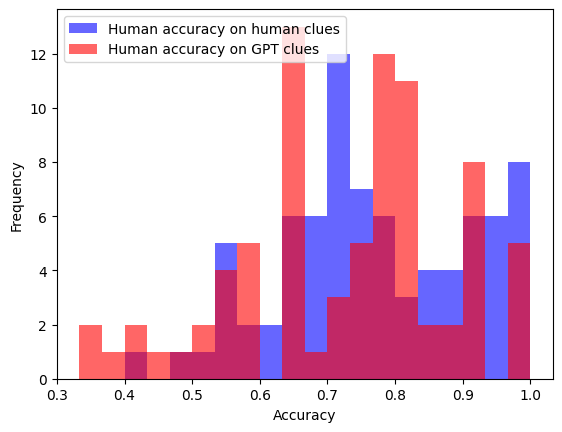

TtestResult(statistic=-0.8020302253815011, pvalue=0.4249415070721466, df=79)


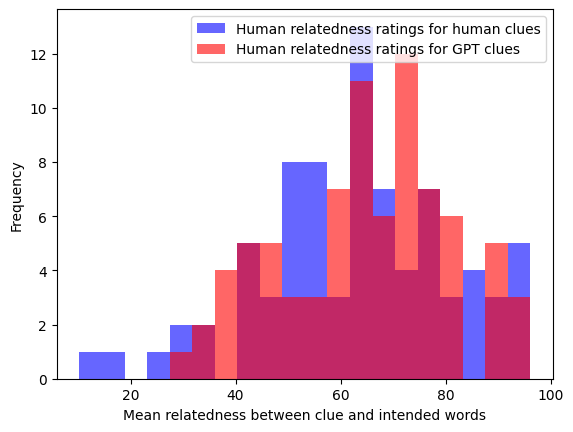

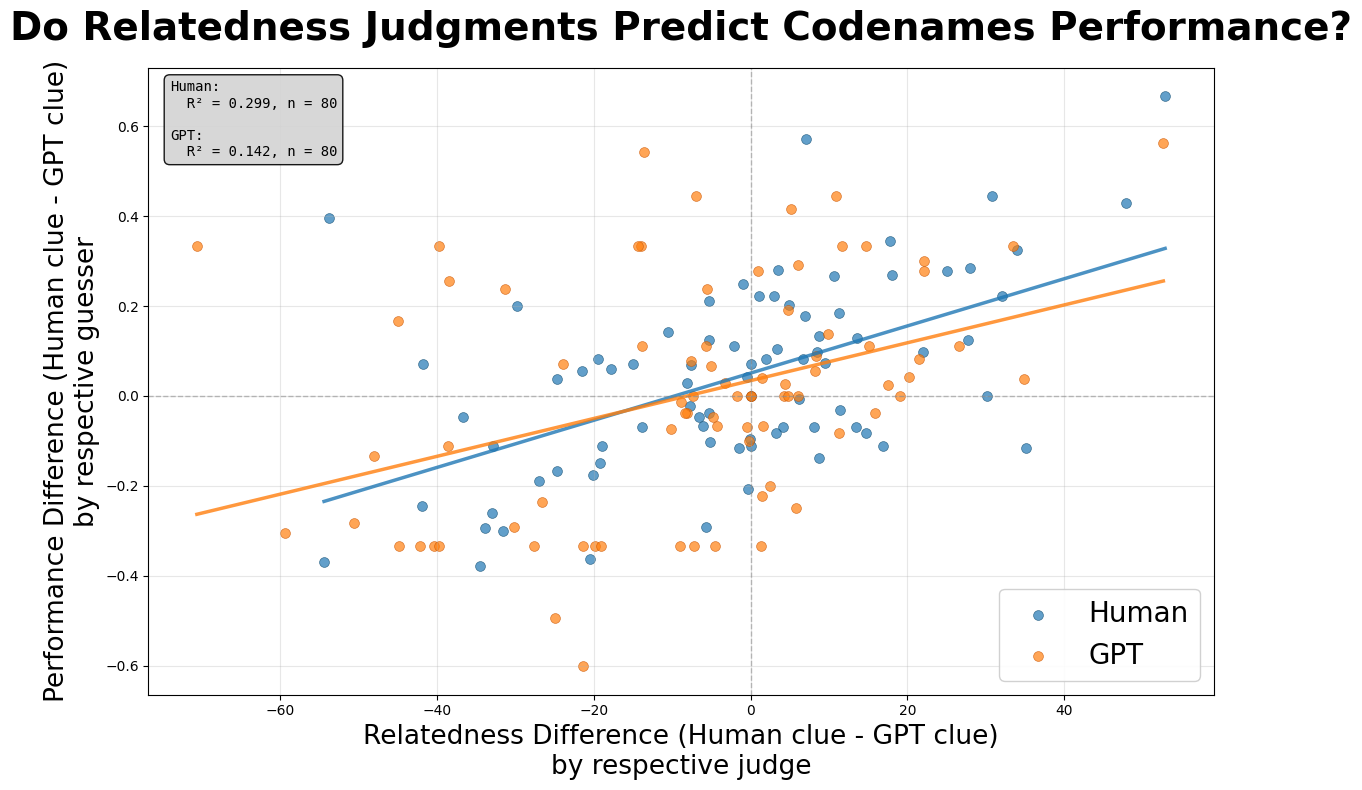

Do Relatedness Judgments Predict Codenames Performance?
Relatedness = mean rating of how related the 3 target words are to the clue
HUMAN (humans judge relatedness & guess):
  Correlation: r = 0.5469, p = 1.5e-07
  R-squared: 0.2991

GPT (GPT judges relatedness & guesses):
  Correlation: r = 0.3768, p = 0.0006
  R-squared: 0.1420







In [ ]:
calculate_relatedness_difference_and_predict_performance()

In [ ]:
def analyze_relatedness_vs_selection_probability():
    # Analyze correlation between relatedness judgments and probability of word selection

    boards_data, relatedness_data = load_data()
    rel_judgments = construct_rel_dict(relatedness_data)
    
    # Get boards with complete relatedness data
    boards = {}
    for board, board_entry in boards_data.items():
        if have_relatedness_judgments(board_entry, rel_judgments):
            boards[board] = board_entry
    
    # Collect word-level data for HUMAN clues and HUMAN guessers
    human_word_data = []
    
    # Collect word-level data for GPT clues and GPT guessers  
    gpt_word_data = []
    
    for board_name, board_entry in boards.items():
        all_words = board_entry['words']  # All words available on this board
        
        # DEBUG: Print board info for first few boards
        # if len(human_word_data) < 50:  # Only print for first couple boards to avoid spam
        #     print(f"\n=== BOARD: {board_name} ===")
        #     print(f"All words on board: {all_words}")
        
        # HUMAN ANALYSIS: Human clues → Human guessers
        human_clue = board_entry['human_clue']
        human_guesses = board_entry['human_guess_human_clue']  # List of guess lists
        
        # DEBUG: Print human analysis details
        # if len(human_word_data) < 50:
        #     print(f"Human clue: '{human_clue}'")
        #     print(f"Human intended words: {board_entry['human_intended_words']}")
        #     print(f"Human guesses raw: {human_guesses}")
        #     print(f"Human guesses type: {type(human_guesses)}")
        
        # Count how often each word was selected by human guessers
        human_word_counts = defaultdict(int)
        total_human_guesses = 0
        
        for guess_set in human_guesses:
            if isinstance(guess_set, str):
                guess_set = [guess_set]
            for word in guess_set:
                human_word_counts[word] += 1
                total_human_guesses += 1
        
        # DEBUG: Print human counting results
        # if len(human_word_data) < 50:
        #     print(f"Human word counts: {dict(human_word_counts)}")
        #     print(f"Total human guesses: {total_human_guesses}")
        
        # For each word on the board, get relatedness and selection probability
        for word in all_words:
            if word in rel_judgments['human'][human_clue]:
                relatedness = rel_judgments['human'][human_clue][word]
                selection_count = human_word_counts[word]
                selection_probability = selection_count / total_human_guesses if total_human_guesses > 0 else 0
                
                human_word_data.append({
                    'board': board_name,
                    'clue': human_clue,
                    'word': word,
                    'relatedness': relatedness,
                    'selection_probability': selection_probability,
                    'selection_count': selection_count,
                    'total_guesses': total_human_guesses,
                    'is_intended': word in board_entry['human_intended_words']
                })
        
        # GPT ANALYSIS: GPT clues → GPT guessers
        gpt_clue = board_entry['gpt_clue']
        gpt_guesses = board_entry['gpt_guess_gpt_clue']  # List of guess lists
        
        # DEBUG: Print GPT analysis details
        # if len(gpt_word_data) < 50:
        #     print(f"GPT clue: '{gpt_clue}'")
        #     print(f"GPT intended words: {board_entry['gpt_intended_words']}")
        #     print(f"GPT guesses raw: {gpt_guesses}")
        #     print(f"GPT guesses type: {type(gpt_guesses)}")
        
        # Count how often each word was selected by GPT guessers
        gpt_word_counts = defaultdict(int)
        total_gpt_guesses = 0
        
        for guess_set in gpt_guesses:
            if isinstance(guess_set, str):
                guess_set = [guess_set]
            for word in guess_set:
                gpt_word_counts[word] += 1
                total_gpt_guesses += 1
        
        # DEBUG: Print GPT counting results
        # if len(gpt_word_data) < 50:
        #     print(f"GPT word counts: {dict(gpt_word_counts)}")
        #     print(f"Total GPT guesses: {total_gpt_guesses}")
        
        # For each word on the board, get relatedness and selection probability
        for word in all_words:
            if word in rel_judgments['gpt'][gpt_clue]:
                relatedness = rel_judgments['gpt'][gpt_clue][word]
                selection_count = gpt_word_counts[word]
                selection_probability = selection_count / total_gpt_guesses if total_gpt_guesses > 0 else 0
                
                gpt_word_data.append({
                    'board': board_name,
                    'clue': gpt_clue,
                    'word': word,
                    'relatedness': relatedness,
                    'selection_probability': selection_probability,
                    'selection_count': selection_count,
                    'total_guesses': total_gpt_guesses,
                    'is_intended': word in board_entry['gpt_intended_words']
                })
    
    # Extract arrays for statistical analysis
    # HUMAN data
    human_relatedness = np.array([d['relatedness'] for d in human_word_data])
    human_selection_prob = np.array([d['selection_probability'] for d in human_word_data])
    
    # GPT data
    gpt_relatedness = np.array([d['relatedness'] for d in gpt_word_data])
    gpt_selection_prob = np.array([d['selection_probability'] for d in gpt_word_data])
    
    # Statistical analysis for HUMAN
    human_correlation, human_p_value = scipy.stats.pearsonr(human_relatedness, human_selection_prob)
    X_human = human_relatedness.reshape(-1, 1)
    y_human = human_selection_prob
    reg_human = LinearRegression().fit(X_human, y_human)
    human_r_squared = r2_score(y_human, reg_human.predict(X_human))
    
    # Statistical analysis for GPT
    gpt_correlation, gpt_p_value = scipy.stats.pearsonr(gpt_relatedness, gpt_selection_prob)
    X_gpt = gpt_relatedness.reshape(-1, 1)
    y_gpt = gpt_selection_prob
    reg_gpt = LinearRegression().fit(X_gpt, y_gpt)
    gpt_r_squared = r2_score(y_gpt, reg_gpt.predict(X_gpt))
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # HUMAN plot
    # Color code by intended vs non-intended words
    human_intended_mask = np.array([d['is_intended'] for d in human_word_data])
    
    ax1.scatter(human_relatedness[~human_intended_mask], human_selection_prob[~human_intended_mask], 
               alpha=0.6, s=40, color='lightblue', edgecolors='steelblue', linewidth=0.5, 
               label='Non-intended words')
    ax1.scatter(human_relatedness[human_intended_mask], human_selection_prob[human_intended_mask], 
               alpha=0.8, s=60, color='darkblue', edgecolors='navy', linewidth=0.5,
               label='Intended words')
    
    # Fit line for all data
    x_line_human = np.linspace(human_relatedness.min(), human_relatedness.max(), 100)
    y_line_human = reg_human.predict(x_line_human.reshape(-1, 1))
    ax1.plot(x_line_human, y_line_human, 'r-', linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Human Relatedness Judgments\n(Relatedness between clue and word)', fontsize=AXIS-3)
    ax1.set_ylabel('Selection Probability\n(Proportion of times word was guessed)', fontsize=AXIS-3)
    ax1.set_title('Human Guessers on Human Clues', fontsize=TITLE-6, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=LEGEND)
    
    stats_text_human = f'R² = {human_r_squared:.3f}'
    ax1.text(0.05, 0.95, stats_text_human, transform=ax1.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
             verticalalignment='top', fontsize=LEGEND)
    
    ax1.grid(True, alpha=0.3)
    
    # GPT plot
    gpt_intended_mask = np.array([d['is_intended'] for d in gpt_word_data])
    
    ax2.scatter(gpt_relatedness[~gpt_intended_mask], gpt_selection_prob[~gpt_intended_mask], 
               alpha=0.6, s=40, color='lightcoral', edgecolors='darkred', linewidth=0.5,
               label='Non-intended words')
    ax2.scatter(gpt_relatedness[gpt_intended_mask], gpt_selection_prob[gpt_intended_mask], 
               alpha=0.8, s=60, color='darkred', edgecolors='maroon', linewidth=0.5,
               label='Intended words')
    
    # Fit line for all data
    x_line_gpt = np.linspace(gpt_relatedness.min(), gpt_relatedness.max(), 100)
    y_line_gpt = reg_gpt.predict(x_line_gpt.reshape(-1, 1))
    ax2.plot(x_line_gpt, y_line_gpt, 'b-', linewidth=2, alpha=0.8)
    
    ax2.set_xlabel('GPT Relatedness Judgments\n(Relatedness between clue and word)', fontsize=AXIS-3)
    ax2.set_ylabel('Selection Probability\n(Proportion of times word was guessed)', fontsize=AXIS-3)
    ax2.set_title('GPT Guessers on GPT Clues', fontsize=TITLE-6, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=LEGEND)
    
    stats_text_gpt = f'R² = {gpt_r_squared:.3f}'
    ax2.text(0.05, 0.95, stats_text_gpt, transform=ax2.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
             verticalalignment='top', fontsize=LEGEND)
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("="*80)
    print("RELATEDNESS JUDGMENTS vs WORD SELECTION PROBABILITY")
    print("="*80)
    print(f"Number of boards analyzed: {len(boards)}")
    print()
    
    print("HUMAN RESULTS (Human clues → Human guessers → Human relatedness judgments)")
    print("-" * 70)
    print(f"Total words analyzed: {len(human_word_data)}")
    print(f"Intended words: {sum(d['is_intended'] for d in human_word_data)}")
    print(f"Non-intended words: {sum(not d['is_intended'] for d in human_word_data)}")
    print(f"Pearson correlation: r = {human_correlation:.4f}")
    print(f"P-value: {human_p_value:.2e}")
    print(f"R-squared: {human_r_squared:.4f}")
    print(f"Percentage of variance explained: {human_r_squared*100:.1f}%")
    print()
    
    print("GPT RESULTS (GPT clues → GPT guessers → GPT relatedness judgments)")
    print("-" * 70)
    print(f"Total words analyzed: {len(gpt_word_data)}")
    print(f"Intended words: {sum(d['is_intended'] for d in gpt_word_data)}")
    print(f"Non-intended words: {sum(not d['is_intended'] for d in gpt_word_data)}")
    print(f"Pearson correlation: r = {gpt_correlation:.4f}")
    print(f"P-value: {gpt_p_value:.2e}")
    print(f"R-squared: {gpt_r_squared:.4f}")
    print(f"Percentage of variance explained: {gpt_r_squared*100:.1f}%")
    print()
    
    # Comparison
    print("COMPARISON")
    print("-" * 30)
    if human_r_squared > gpt_r_squared:
        difference = human_r_squared - gpt_r_squared
        print(f"Human judgments explain {difference*100:.1f} percentage points MORE")
        print(f"variance in word selection than GPT judgments.")
    else:
        difference = gpt_r_squared - human_r_squared
        print(f"GPT judgments explain {difference*100:.1f} percentage points MORE")
        print(f"variance in word selection than human judgments.")
    print()
    
    # DEBUG: show examples of highly selected vs rarely selected words
    print("HUMAN Examples (top/bottom by selection probability):")
    print("-" * 60)
    human_sorted = sorted(human_word_data, key=lambda x: x['selection_probability'], reverse=True)
    print("MOST SELECTED words:")
    for i, item in enumerate(human_sorted[:3]):
        intended_str = " (INTENDED)" if item['is_intended'] else ""
        print(f"  '{item['word']}' for clue '{item['clue']}'{intended_str}")
        print(f"    Relatedness: {item['relatedness']:.3f}, Selected: {item['selection_probability']:.3f}")
    
    print("LEAST SELECTED words:")
    for i, item in enumerate(human_sorted[-3:]):
        intended_str = " (INTENDED)" if item['is_intended'] else ""
        print(f"  '{item['word']}' for clue '{item['clue']}'{intended_str}")
        print(f"    Relatedness: {item['relatedness']:.3f}, Selected: {item['selection_probability']:.3f}")
    print()
    
    print("GPT Examples (top/bottom by selection probability):")
    print("-" * 60)
    gpt_sorted = sorted(gpt_word_data, key=lambda x: x['selection_probability'], reverse=True)
    print("MOST SELECTED words:")
    for i, item in enumerate(gpt_sorted[:3]):
        intended_str = " (INTENDED)" if item['is_intended'] else ""
        print(f"  '{item['word']}' for clue '{item['clue']}'{intended_str}")
        print(f"    Relatedness: {item['relatedness']:.3f}, Selected: {item['selection_probability']:.3f}")
    
    print("LEAST SELECTED words:")
    for i, item in enumerate(gpt_sorted[-3:]):
        intended_str = " (INTENDED)" if item['is_intended'] else ""
        print(f"  '{item['word']}' for clue '{item['clue']}'{intended_str}")
        print(f"    Relatedness: {item['relatedness']:.3f}, Selected: {item['selection_probability']:.3f}")
    
    return {
        'human': {
            'correlation': human_correlation,
            'p_value': human_p_value,
            'r_squared': human_r_squared,
            'word_data': human_word_data,
            'relatedness': human_relatedness,
            'selection_prob': human_selection_prob
        },
        'gpt': {
            'correlation': gpt_correlation,
            'p_value': gpt_p_value,
            'r_squared': gpt_r_squared,
            'word_data': gpt_word_data,
            'relatedness': gpt_relatedness,
            'selection_prob': gpt_selection_prob
        },
        'n_boards': len(boards)
    }

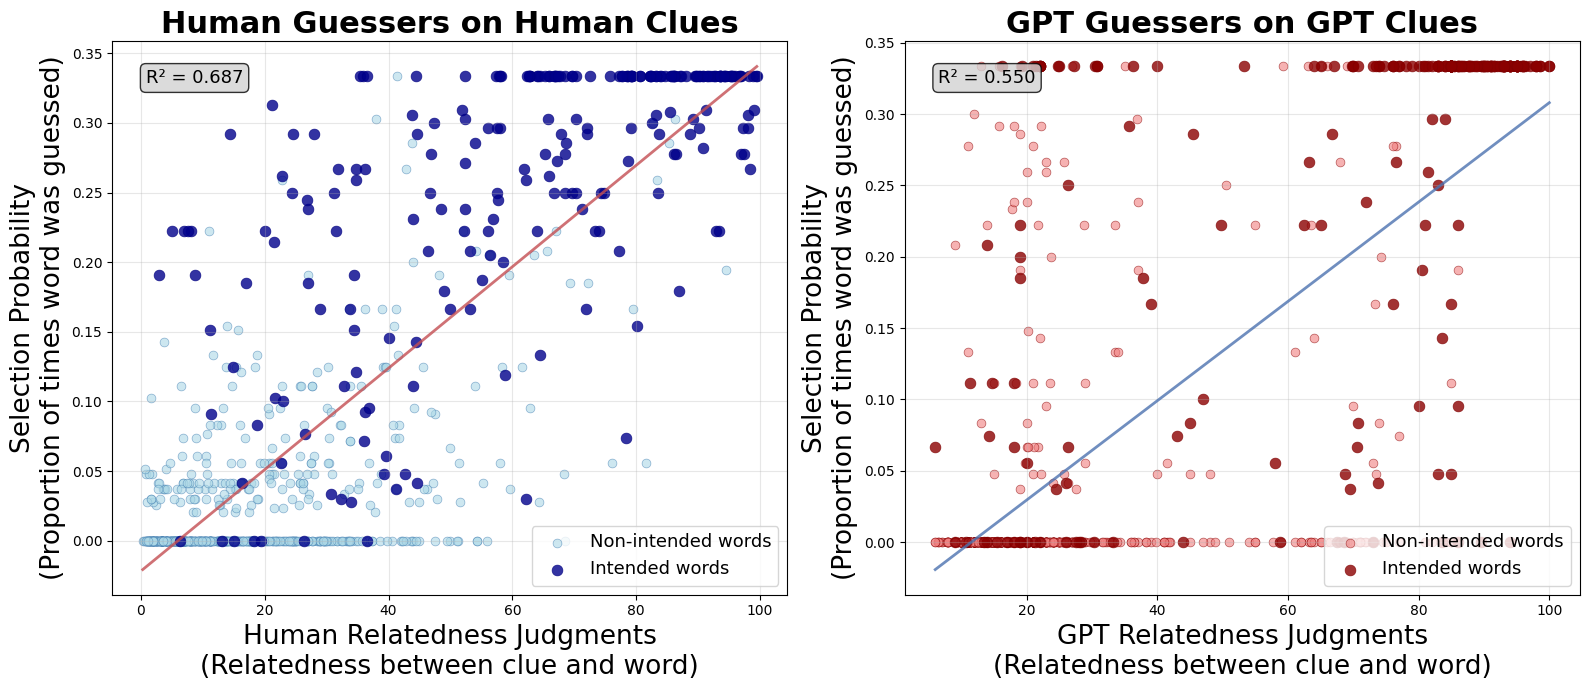

RELATEDNESS JUDGMENTS vs WORD SELECTION PROBABILITY
Number of boards analyzed: 80

HUMAN RESULTS (Human clues → Human guessers → Human relatedness judgments)
----------------------------------------------------------------------
Total words analyzed: 960
Intended words: 240
Non-intended words: 720
Pearson correlation: r = 0.8288
P-value: 8.16e-244
R-squared: 0.6869
Percentage of variance explained: 68.7%

GPT RESULTS (GPT clues → GPT guessers → GPT relatedness judgments)
----------------------------------------------------------------------
Total words analyzed: 960
Intended words: 240
Non-intended words: 720
Pearson correlation: r = 0.7419
P-value: 1.65e-168
R-squared: 0.5505
Percentage of variance explained: 55.0%

COMPARISON
------------------------------
Human judgments explain 13.6 percentage points MORE
variance in word selection than GPT judgments.

HUMAN Examples (top/bottom by selection probability):
------------------------------------------------------------
MOST SELECTED wo

{'human': {'correlation': 0.8288059074753016,
  'p_value': 8.163869604140654e-244,
  'r_squared': 0.686919232265963,
  'word_data': [{'board': "('MILLIONAIRE', 'PLATYPUS', 'FENCE', 'SPRING', 'WATER', 'AMERICA', 'LUCK', 'LONDON', 'NOVEL', 'DECK', 'ICE', 'CLOAK')",
    'clue': 'USA',
    'word': 'MILLIONAIRE',
    'relatedness': 22.833333333333332,
    'selection_probability': 0.2619047619047619,
    'selection_count': 11,
    'total_guesses': 42,
    'is_intended': True},
   {'board': "('MILLIONAIRE', 'PLATYPUS', 'FENCE', 'SPRING', 'WATER', 'AMERICA', 'LUCK', 'LONDON', 'NOVEL', 'DECK', 'ICE', 'CLOAK')",
    'clue': 'USA',
    'word': 'PLATYPUS',
    'relatedness': 11.4,
    'selection_probability': 0.0,
    'selection_count': 0,
    'total_guesses': 42,
    'is_intended': False},
   {'board': "('MILLIONAIRE', 'PLATYPUS', 'FENCE', 'SPRING', 'WATER', 'AMERICA', 'LUCK', 'LONDON', 'NOVEL', 'DECK', 'ICE', 'CLOAK')",
    'clue': 'USA',
    'word': 'FENCE',
    'relatedness': 30.9,
    'select

In [ ]:
analyze_relatedness_vs_selection_probability()


# Board Subset of 'Better' Human Clues (as determined by human performance)

In [ ]:
def comprehensive_codenames_analysis(boards_data, relatedness_data):
    """
    Comprehensive analysis of Codenames performance and relatedness judgments.
    
    This function analyzes:
    1. Performance patterns across different board subsets
    2. Relatedness judgment patterns
    3. Correlation between relatedness and performance
    4. Predictive power of relatedness for performance differences
    """
    
    print("COMPREHENSIVE CODENAMES ANALYSIS")
    print("=" * 80)
    
    # Construct relatedness dictionary
    rel_judgments = construct_rel_dict(relatedness_data)
    
    # Collect all board data
    all_boards = []
    boards_with_relatedness = []
    
    for board_key, board_data in boards_data.items():
        # Check if we have complete performance data
        required_fields = ['human_guess_human_clue', 'human_intended_words', 
                          'human_guess_gpt_clue', 'gpt_intended_words',
                          'gpt_guess_human_clue', 'gpt_guess_gpt_clue']
        
        if all(field in board_data for field in required_fields):
            board_info = {
                'board_key': board_key,
                'words': board_data.get('words', []),
                'human_clue': board_data.get('human_clue', 'N/A'),
                'gpt_clue': board_data.get('gpt_clue', 'N/A'),
                'human_intended': board_data['human_intended_words'],
                'gpt_intended': board_data['gpt_intended_words']
            }
            
            # Calculate performance metrics
            board_info['human_on_human'] = get_mean_accuracy(
                board_data['human_intended_words'], board_data['human_guess_human_clue'])
            board_info['human_on_gpt'] = get_mean_accuracy(
                board_data['gpt_intended_words'], board_data['human_guess_gpt_clue'])
            board_info['gpt_on_human'] = get_mean_accuracy(
                board_data['human_intended_words'], board_data['gpt_guess_human_clue'])
            board_info['gpt_on_gpt'] = get_mean_accuracy(
                board_data['gpt_intended_words'], board_data['gpt_guess_gpt_clue'])
            
            all_boards.append(board_info)
            
            # Check if this board also has relatedness data
            if have_relatedness_judgments(board_data, rel_judgments):
                # Add relatedness data
                board_info_rel = board_info.copy()
                
                # Human relatedness judgments
                board_info_rel['human_rel_human_clue'] = get_mean_relatedness(
                    board_data['human_clue'], board_data['human_intended_words'], 
                    rel_judgments['human'])
                board_info_rel['human_rel_gpt_clue'] = get_mean_relatedness(
                    board_data['gpt_clue'], board_data['gpt_intended_words'], 
                    rel_judgments['human'])
                
                # GPT relatedness judgments
                board_info_rel['gpt_rel_human_clue'] = get_mean_relatedness(
                    board_data['human_clue'], board_data['human_intended_words'], 
                    rel_judgments['gpt'])
                board_info_rel['gpt_rel_gpt_clue'] = get_mean_relatedness(
                    board_data['gpt_clue'], board_data['gpt_intended_words'], 
                    rel_judgments['gpt'])
                
                boards_with_relatedness.append(board_info_rel)
    
    print(f"Total boards with complete performance data: {len(all_boards)}")
    print(f"Boards with complete relatedness judgments: {len(boards_with_relatedness)}")
    
    # BASELINE STATISTICS - SANITY CHECK
    print(f"\n{'='*80}")
    print("BASELINE STATISTICS (SANITY CHECK)")
    print(f"{'='*80}")
    
    # Overall performance statistics on all boards
    print(f"\nOVERALL PERFORMANCE (All {len(all_boards)} boards):")
    print("-" * 50)
    
    # Human performance
    all_human_on_human = [board['human_on_human'] for board in all_boards]
    all_human_on_gpt = [board['human_on_gpt'] for board in all_boards]
    
    print(f"Human Performance:")
    print(f"  Human on Human clues: {np.mean(all_human_on_human):.4f} ± {np.std(all_human_on_human):.4f}")
    print(f"  Human on GPT clues:   {np.mean(all_human_on_gpt):.4f} ± {np.std(all_human_on_gpt):.4f}")
    print(f"  Difference (H-G):     {np.mean(all_human_on_human) - np.mean(all_human_on_gpt):.4f}")
    
    # Statistical test for human performance difference
    t_stat_human_all, p_val_human_all = scipy.stats.ttest_ind(all_human_on_human, all_human_on_gpt)
    print(f"  t-test: t={t_stat_human_all:.4f}, p={p_val_human_all:.6f}")
    
    # GPT performance
    all_gpt_on_human = [board['gpt_on_human'] for board in all_boards]
    all_gpt_on_gpt = [board['gpt_on_gpt'] for board in all_boards]
    
    print(f"\nGPT Performance:")
    print(f"  GPT on Human clues: {np.mean(all_gpt_on_human):.4f} ± {np.std(all_gpt_on_human):.4f}")
    print(f"  GPT on GPT clues:   {np.mean(all_gpt_on_gpt):.4f} ± {np.std(all_gpt_on_gpt):.4f}")
    print(f"  Difference (H-G):   {np.mean(all_gpt_on_human) - np.mean(all_gpt_on_gpt):.4f}")
    
    # Statistical test for GPT performance difference
    t_stat_gpt_all, p_val_gpt_all = scipy.stats.ttest_ind(all_gpt_on_human, all_gpt_on_gpt)
    print(f"  t-test: t={t_stat_gpt_all:.4f}, p={p_val_gpt_all:.6f}")
    
    # Cross-comparisons
    print(f"\nCROSS-COMPARISONS:")
    print(f"  Human vs GPT on Human clues: {np.mean(all_human_on_human):.4f} vs {np.mean(all_gpt_on_human):.4f}")
    print(f"  Human vs GPT on GPT clues:   {np.mean(all_human_on_gpt):.4f} vs {np.mean(all_gpt_on_gpt):.4f}")
    
    # Baseline statistics for relatedness subset if available
    if boards_with_relatedness:
        print(f"\nOVERALL PERFORMANCE (Relatedness subset, {len(boards_with_relatedness)} boards):")
        print("-" * 50)
        
        # Human performance in relatedness subset
        rel_human_on_human = [board['human_on_human'] for board in boards_with_relatedness]
        rel_human_on_gpt = [board['human_on_gpt'] for board in boards_with_relatedness]
        
        print(f"Human Performance (Relatedness Subset):")
        print(f"  Human on Human clues: {np.mean(rel_human_on_human):.4f} ± {np.std(rel_human_on_human):.4f}")
        print(f"  Human on GPT clues:   {np.mean(rel_human_on_gpt):.4f} ± {np.std(rel_human_on_gpt):.4f}")
        print(f"  Difference (H-G):     {np.mean(rel_human_on_human) - np.mean(rel_human_on_gpt):.4f}")
        
        t_stat_human_rel_all, p_val_human_rel_all = scipy.stats.ttest_ind(rel_human_on_human, rel_human_on_gpt)
        print(f"  t-test: t={t_stat_human_rel_all:.4f}, p={p_val_human_rel_all:.6f}")
        
        # GPT performance in relatedness subset
        rel_gpt_on_human = [board['gpt_on_human'] for board in boards_with_relatedness]
        rel_gpt_on_gpt = [board['gpt_on_gpt'] for board in boards_with_relatedness]
        
        print(f"\nGPT Performance (Relatedness Subset):")
        print(f"  GPT on Human clues: {np.mean(rel_gpt_on_human):.4f} ± {np.std(rel_gpt_on_human):.4f}")
        print(f"  GPT on GPT clues:   {np.mean(rel_gpt_on_gpt):.4f} ± {np.std(rel_gpt_on_gpt):.4f}")
        print(f"  Difference (H-G):   {np.mean(rel_gpt_on_human) - np.mean(rel_gpt_on_gpt):.4f}")
        
        t_stat_gpt_rel_all, p_val_gpt_rel_all = scipy.stats.ttest_ind(rel_gpt_on_human, rel_gpt_on_gpt)
        print(f"  t-test: t={t_stat_gpt_rel_all:.4f}, p={p_val_gpt_rel_all:.6f}")
        
        # Baseline relatedness statistics
        print(f"\nOVERALL RELATEDNESS (Relatedness subset, {len(boards_with_relatedness)} boards):")
        print("-" * 50)
        
        # Human relatedness judgments
        all_human_rel_human = [board['human_rel_human_clue'] for board in boards_with_relatedness]
        all_human_rel_gpt = [board['human_rel_gpt_clue'] for board in boards_with_relatedness]
        
        print(f"Human Relatedness Judgments:")
        print(f"  Human clues: {np.mean(all_human_rel_human):.4f} ± {np.std(all_human_rel_human):.4f}")
        print(f"  GPT clues:   {np.mean(all_human_rel_gpt):.4f} ± {np.std(all_human_rel_gpt):.4f}")
        print(f"  Difference:  {np.mean(all_human_rel_human) - np.mean(all_human_rel_gpt):.4f}")
        
        t_stat_human_rel, p_val_human_rel = scipy.stats.ttest_ind(all_human_rel_human, all_human_rel_gpt)
        print(f"  t-test: t={t_stat_human_rel:.4f}, p={p_val_human_rel:.6f}")
        
        # GPT relatedness judgments
        all_gpt_rel_human = [board['gpt_rel_human_clue'] for board in boards_with_relatedness]
        all_gpt_rel_gpt = [board['gpt_rel_gpt_clue'] for board in boards_with_relatedness]
        
        print(f"\nGPT Relatedness Judgments:")
        print(f"  Human clues: {np.mean(all_gpt_rel_human):.4f} ± {np.std(all_gpt_rel_human):.4f}")
        print(f"  GPT clues:   {np.mean(all_gpt_rel_gpt):.4f} ± {np.std(all_gpt_rel_gpt):.4f}")
        print(f"  Difference:  {np.mean(all_gpt_rel_human) - np.mean(all_gpt_rel_gpt):.4f}")
        
        t_stat_gpt_rel, p_val_gpt_rel = scipy.stats.ttest_ind(all_gpt_rel_human, all_gpt_rel_gpt)
        print(f"  t-test: t={t_stat_gpt_rel:.4f}, p={p_val_gpt_rel:.6f}")
        
        # Data distribution check
        print(f"\nDATA DISTRIBUTION CHECK:")
        print("-" * 30)
        print(f"Performance ranges:")
        print(f"  Human on human: [{min(rel_human_on_human):.3f}, {max(rel_human_on_human):.3f}]")
        print(f"  Human on GPT:   [{min(rel_human_on_gpt):.3f}, {max(rel_human_on_gpt):.3f}]")
        print(f"  GPT on human:   [{min(rel_gpt_on_human):.3f}, {max(rel_gpt_on_human):.3f}]")
        print(f"  GPT on GPT:     [{min(rel_gpt_on_gpt):.3f}, {max(rel_gpt_on_gpt):.3f}]")
        
        print(f"Relatedness ranges:")
        print(f"  Human rel human: [{min(all_human_rel_human):.3f}, {max(all_human_rel_human):.3f}]")
        print(f"  Human rel GPT:   [{min(all_human_rel_gpt):.3f}, {max(all_human_rel_gpt):.3f}]")
        print(f"  GPT rel human:   [{min(all_gpt_rel_human):.3f}, {max(all_gpt_rel_human):.3f}]")
        print(f"  GPT rel GPT:     [{min(all_gpt_rel_gpt):.3f}, {max(all_gpt_rel_gpt):.3f}]")
    
    # Define board subsets based on human performance patterns
    def categorize_boards(boards):
        human_better_on_human = []  # Humans do better on human clues
        human_better_on_gpt = []    # Humans do better on GPT clues
        human_equal = []            # Equal performance
        
        for board in boards:
            human_diff = board['human_on_human'] - board['human_on_gpt']
            if human_diff > 0:
                human_better_on_human.append(board)
            elif human_diff < 0:
                human_better_on_gpt.append(board)
            else:
                human_equal.append(board)
        
        return human_better_on_human, human_better_on_gpt, human_equal
    
    # Categorize all boards
    human_better_human_all, human_better_gpt_all, human_equal_all = categorize_boards(all_boards)
    
    print(f"\nBoard categorization (all {len(all_boards)} boards):")
    print(f"  Humans better on human clues: {len(human_better_human_all)} ({len(human_better_human_all)/len(all_boards)*100:.1f}%)")
    print(f"  Humans better on GPT clues: {len(human_better_gpt_all)} ({len(human_better_gpt_all)/len(all_boards)*100:.1f}%)")
    print(f"  Equal performance: {len(human_equal_all)} ({len(human_equal_all)/len(all_boards)*100:.1f}%)")
    
    # Categorize boards with relatedness data
    if boards_with_relatedness:
        human_better_human_rel, human_better_gpt_rel, human_equal_rel = categorize_boards(boards_with_relatedness)
        
        print(f"\nBoard categorization (relatedness subset, {len(boards_with_relatedness)} boards):")
        print(f"  Humans better on human clues: {len(human_better_human_rel)} ({len(human_better_human_rel)/len(boards_with_relatedness)*100:.1f}%)")
        print(f"  Humans better on GPT clues: {len(human_better_gpt_rel)} ({len(human_better_gpt_rel)/len(boards_with_relatedness)*100:.1f}%)")
        print(f"  Equal performance: {len(human_equal_rel)} ({len(human_equal_rel)/len(boards_with_relatedness)*100:.1f}%)")
    
    # ANALYSIS 1: Performance patterns in different subsets
    print(f"\n{'='*80}")
    print("ANALYSIS 1: PERFORMANCE PATTERNS IN SUBSETS")
    print(f"{'='*80}")
    
    def analyze_performance_subset(subset, subset_name):
        if not subset:
            print(f"\nNo boards in {subset_name} subset")
            return
        
        print(f"\n{subset_name} (n={len(subset)}):")
        print("-" * 50)
        
        # Human performance
        human_human = [board['human_on_human'] for board in subset]
        human_gpt = [board['human_on_gpt'] for board in subset]
        
        print(f"Human performance:")
        print(f"  On human clues: {np.mean(human_human):.3f} ± {np.std(human_human):.3f}")
        print(f"  On GPT clues:   {np.mean(human_gpt):.3f} ± {np.std(human_gpt):.3f}")
        print(f"  Difference:     {np.mean(human_human) - np.mean(human_gpt):.3f}")
        
        # GPT performance
        gpt_human = [board['gpt_on_human'] for board in subset]
        gpt_gpt = [board['gpt_on_gpt'] for board in subset]
        
        print(f"GPT performance:")
        print(f"  On human clues: {np.mean(gpt_human):.3f} ± {np.std(gpt_human):.3f}")
        print(f"  On GPT clues:   {np.mean(gpt_gpt):.3f} ± {np.std(gpt_gpt):.3f}")
        print(f"  Difference:     {np.mean(gpt_human) - np.mean(gpt_gpt):.3f}")
        
        # Statistical tests
        if len(subset) > 1:
            t_stat_human, p_val_human = scipy.stats.ttest_ind(human_human, human_gpt)
            t_stat_gpt, p_val_gpt = scipy.stats.ttest_ind(gpt_human, gpt_gpt)
            
            print(f"Statistical tests:")
            print(f"  Human preference: t={t_stat_human:.3f}, p={p_val_human:.6f}")
            print(f"  GPT preference:   t={t_stat_gpt:.3f}, p={p_val_gpt:.6f}")
    
    # Analyze performance in each subset
    analyze_performance_subset(human_better_human_all, "Humans better on human clues (all boards)")
    analyze_performance_subset(human_better_gpt_all, "Humans better on GPT clues (all boards)")
    
    if boards_with_relatedness:
        analyze_performance_subset(human_better_human_rel, "Humans better on human clues (relatedness subset)")
        analyze_performance_subset(human_better_gpt_rel, "Humans better on GPT clues (relatedness subset)")
        
        # NEW: Analyze performance for ALL boards with relatedness data
        analyze_performance_subset(boards_with_relatedness, "ALL BOARDS WITH RELATEDNESS DATA")
    
    # ANALYSIS 2: Relatedness patterns
    if boards_with_relatedness:
        print(f"\n{'='*80}")
        print("ANALYSIS 2: RELATEDNESS PATTERNS IN SUBSETS")
        print(f"{'='*80}")
        
        def analyze_relatedness_subset(subset, subset_name):
            if not subset:
                print(f"\nNo boards in {subset_name} subset")
                return
            
            print(f"\n{subset_name} (n={len(subset)}):")
            print("-" * 50)
            
            # Human relatedness judgments
            human_rel_human = [board['human_rel_human_clue'] for board in subset]
            human_rel_gpt = [board['human_rel_gpt_clue'] for board in subset]
            
            print(f"Human relatedness judgments:")
            print(f"  Human clues: {np.mean(human_rel_human):.3f} ± {np.std(human_rel_human):.3f}")
            print(f"  GPT clues:   {np.mean(human_rel_gpt):.3f} ± {np.std(human_rel_gpt):.3f}")
            print(f"  Difference:  {np.mean(human_rel_human) - np.mean(human_rel_gpt):.3f}")
            
            # GPT relatedness judgments
            gpt_rel_human = [board['gpt_rel_human_clue'] for board in subset]
            gpt_rel_gpt = [board['gpt_rel_gpt_clue'] for board in subset]
            
            print(f"GPT relatedness judgments:")
            print(f"  Human clues: {np.mean(gpt_rel_human):.3f} ± {np.std(gpt_rel_human):.3f}")
            print(f"  GPT clues:   {np.mean(gpt_rel_gpt):.3f} ± {np.std(gpt_rel_gpt):.3f}")
            print(f"  Difference:  {np.mean(gpt_rel_human) - np.mean(gpt_rel_gpt):.3f}")
            
            # Statistical tests
            if len(subset) > 1:
                t_stat_human_rel, p_val_human_rel = scipy.stats.ttest_ind(human_rel_human, human_rel_gpt)
                t_stat_gpt_rel, p_val_gpt_rel = scipy.stats.ttest_ind(gpt_rel_human, gpt_rel_gpt)
                
                print(f"Statistical tests:")
                print(f"  Human rel. preference: t={t_stat_human_rel:.3f}, p={p_val_human_rel:.6f}")
                print(f"  GPT rel. preference:   t={t_stat_gpt_rel:.3f}, p={p_val_gpt_rel:.6f}")
        
        analyze_relatedness_subset(human_better_human_rel, "Humans better on human clues")
        analyze_relatedness_subset(human_better_gpt_rel, "Humans better on GPT clues")
        

        analyze_relatedness_subset(boards_with_relatedness, "ALL BOARDS WITH RELATEDNESS DATA")
    
    # ANALYSIS 3: Correlation between relatedness and performance
    if boards_with_relatedness:
        print(f"\n{'='*80}")
        print("ANALYSIS 3: RELATEDNESS-PERFORMANCE CORRELATIONS")
        print(f"{'='*80}")
        
        def analyze_correlations(subset, subset_name):
            if len(subset) < 3:
                print(f"\nInsufficient data for {subset_name} (n={len(subset)})")
                return
            
            print(f"\n{subset_name} (n={len(subset)}):")
            print("-" * 50)
            
            # Calculate differences
            human_perf_diff = [board['human_on_human'] - board['human_on_gpt'] for board in subset]
            gpt_perf_diff = [board['gpt_on_human'] - board['gpt_on_gpt'] for board in subset]
            human_rel_diff = [board['human_rel_human_clue'] - board['human_rel_gpt_clue'] for board in subset]
            gpt_rel_diff = [board['gpt_rel_human_clue'] - board['gpt_rel_gpt_clue'] for board in subset]
            
            # Correlations
            correlations = [
                ("Human performance diff vs Human relatedness diff", 
                 scipy.stats.pearsonr(human_perf_diff, human_rel_diff)),
                ("GPT performance diff vs GPT relatedness diff", 
                 scipy.stats.pearsonr(gpt_perf_diff, gpt_rel_diff)),
                ("Human performance diff vs GPT relatedness diff", 
                 scipy.stats.pearsonr(human_perf_diff, gpt_rel_diff)),
                ("GPT performance diff vs Human relatedness diff", 
                 scipy.stats.pearsonr(gpt_perf_diff, human_rel_diff))
            ]
            
            for desc, (r, p) in correlations:
                print(f"  {desc}:")
                print(f"    r = {r:.4f}, p = {p:.6f}")
        
        analyze_correlations(human_better_human_rel, "Humans better on human clues")
        analyze_correlations(human_better_gpt_rel, "Humans better on GPT clues")
        analyze_correlations(boards_with_relatedness, "ALL BOARDS WITH RELATEDNESS DATA")
    
    # ANALYSIS 4: Predictive modeling
    if boards_with_relatedness and len(boards_with_relatedness) >= 10:
        print(f"\n{'='*80}")
        print("ANALYSIS 4: PREDICTIVE MODELING")
        print(f"{'='*80}")
        
        # Prepare data for modeling
        data_for_modeling = []
        for board in boards_with_relatedness:
            data_for_modeling.append({
                'human_perf_diff': board['human_on_human'] - board['human_on_gpt'],
                'gpt_perf_diff': board['gpt_on_human'] - board['gpt_on_gpt'],
                'human_rel_diff': board['human_rel_human_clue'] - board['human_rel_gpt_clue'],
                'gpt_rel_diff': board['gpt_rel_human_clue'] - board['gpt_rel_gpt_clue'],
                'human_rel_human': board['human_rel_human_clue'],
                'human_rel_gpt': board['human_rel_gpt_clue'],
                'gpt_rel_human': board['gpt_rel_human_clue'],
                'gpt_rel_gpt': board['gpt_rel_gpt_clue']
            })
        
        df = pd.DataFrame(data_for_modeling)
        
        # Model 1: Predict human performance difference from relatedness
        print("\nModel 1: Predicting human performance difference")
        X1 = df[['human_rel_diff', 'gpt_rel_diff']].values
        y1 = df['human_perf_diff'].values
        
        reg1 = LinearRegression().fit(X1, y1)
        r2_1 = r2_score(y1, reg1.predict(X1))
        
        print(f"  R² = {r2_1:.4f}")
        print(f"  Coefficients: Human rel diff = {reg1.coef_[0]:.4f}, GPT rel diff = {reg1.coef_[1]:.4f}")
        
        # Model 2: Predict GPT performance difference from relatedness
        print("\nModel 2: Predicting GPT performance difference")
        X2 = df[['human_rel_diff', 'gpt_rel_diff']].values
        y2 = df['gpt_perf_diff'].values
        
        reg2 = LinearRegression().fit(X2, y2)
        r2_2 = r2_score(y2, reg2.predict(X2))
        
        print(f"  R² = {r2_2:.4f}")
        print(f"  Coefficients: Human rel diff = {reg2.coef_[0]:.4f}, GPT rel diff = {reg2.coef_[1]:.4f}")
    
    # ANALYSIS 5: SPECIFIC RESEARCH QUESTIONS
    if boards_with_relatedness:
        print(f"\n{'='*80}")
        print("ANALYSIS 5: SPECIFIC RESEARCH QUESTIONS")
        print(f"{'='*80}")
        
        # Question 1: GPT relatedness predicting GPT selection probability on human-better boards
        if human_better_human_rel:
            print(f"\nQUESTION 1: GPT Relatedness → GPT Selection Probability")
            print(f"Subset: Boards where humans do better on human clues (n={len(human_better_human_rel)})")
            print("-" * 70)
            
            # For each board, calculate GPT's "selection probability" for human clues
            # This is essentially GPT's performance on human clues
            gpt_selection_prob_human = [board['gpt_on_human'] for board in human_better_human_rel]
            gpt_relatedness_human = [board['gpt_rel_human_clue'] for board in human_better_human_rel]
            
            # Also look at the difference in GPT relatedness (human - gpt clues)
            gpt_rel_diff_subset1 = [board['gpt_rel_human_clue'] - board['gpt_rel_gpt_clue'] 
                                   for board in human_better_human_rel]
            
            # Correlations
            r1a, p1a = scipy.stats.pearsonr(gpt_relatedness_human, gpt_selection_prob_human)
            r1b, p1b = scipy.stats.pearsonr(gpt_rel_diff_subset1, gpt_selection_prob_human)
            
            print(f"GPT relatedness to human clues vs GPT performance on human clues:")
            print(f"  r = {r1a:.4f}, p = {p1a:.6f}")
            print(f"  Interpretation: {'Significant' if p1a < 0.05 else 'Not significant'} correlation")
            
            print(f"\nGPT relatedness difference (Human-GPT) vs GPT performance on human clues:")
            print(f"  r = {r1b:.4f}, p = {p1b:.6f}")
            print(f"  Interpretation: {'Significant' if p1b < 0.05 else 'Not significant'} correlation")
            
            # Linear regression for prediction
            if len(human_better_human_rel) >= 5:
                X1 = np.array(gpt_relatedness_human).reshape(-1, 1)
                y1 = np.array(gpt_selection_prob_human)
                reg1 = LinearRegression().fit(X1, y1)
                r2_1 = r2_score(y1, reg1.predict(X1))
                
                print(f"\nPredictive model: GPT relatedness → GPT selection probability")
                print(f"  R² = {r2_1:.4f}")
                print(f"  Coefficient = {reg1.coef_[0]:.4f} (for every 1-point increase in relatedness)")
                print(f"  Intercept = {reg1.intercept_:.4f}")
                
                # Effect size interpretation
                gpt_rel_range = max(gpt_relatedness_human) - min(gpt_relatedness_human)
                predicted_effect = reg1.coef_[0] * gpt_rel_range
                print(f"  Practical effect: {gpt_rel_range:.1f}-point relatedness range → {predicted_effect:.3f} difference in selection probability")
        
        # Question 2: Human relatedness explaining human worseness on GPT-better boards  
        if human_better_gpt_rel:
            print(f"\nQUESTION 2: Human Relatedness → Human Performance Deficit")
            print(f"Subset: Boards where humans do better on GPT clues (n={len(human_better_gpt_rel)})")
            print("-" * 70)
            
            # Human "worseness" = how much worse they do on human clues vs GPT clues
            human_worseness = [board['human_on_gpt'] - board['human_on_human'] 
                              for board in human_better_gpt_rel]  # Positive = worse on human clues
            
            # Human relatedness patterns
            human_rel_human_subset2 = [board['human_rel_human_clue'] for board in human_better_gpt_rel]
            human_rel_gpt_subset2 = [board['human_rel_gpt_clue'] for board in human_better_gpt_rel]
            human_rel_diff_subset2 = [board['human_rel_human_clue'] - board['human_rel_gpt_clue'] 
                                     for board in human_better_gpt_rel]
            
            # Correlations
            r2a, p2a = scipy.stats.pearsonr(human_rel_human_subset2, human_worseness)
            r2b, p2b = scipy.stats.pearsonr(human_rel_gpt_subset2, human_worseness)
            r2c, p2c = scipy.stats.pearsonr(human_rel_diff_subset2, human_worseness)
            
            print(f"Human relatedness to human clues vs human worseness:")
            print(f"  r = {r2a:.4f}, p = {p2a:.6f}")
            print(f"  Interpretation: {'Lower' if r2a < 0 else 'Higher'} relatedness → {'less' if r2a < 0 else 'more'} worseness")
            
            print(f"\nHuman relatedness to GPT clues vs human worseness:")
            print(f"  r = {r2b:.4f}, p = {p2b:.6f}")
            print(f"  Interpretation: {'Lower' if r2b < 0 else 'Higher'} relatedness to GPT clues → {'less' if r2b < 0 else 'more'} worseness")
            
            print(f"\nHuman relatedness difference (Human-GPT) vs human worseness:")
            print(f"  r = {r2c:.4f}, p = {p2c:.6f}")
            print(f"  Interpretation: {'Negative' if r2c < 0 else 'Positive'} difference → {'less' if r2c < 0 else 'more'} worseness")
            
            # Linear regression for explanation
            if len(human_better_gpt_rel) >= 5:
                X2 = np.array(human_rel_diff_subset2).reshape(-1, 1)
                y2 = np.array(human_worseness)
                reg2 = LinearRegression().fit(X2, y2)
                r2_2 = r2_score(y2, reg2.predict(X2))
                
                print(f"\nExplanatory model: Human relatedness difference → Human worseness")
                print(f"  R² = {r2_2:.4f} (variance in worseness explained)")
                print(f"  Coefficient = {reg2.coef_[0]:.4f}")
                print(f"  Interpretation: For every 1-point increase in relatedness difference,")
                print(f"                  worseness {'increases' if reg2.coef_[0] > 0 else 'decreases'} by {abs(reg2.coef_[0]):.4f}")
                
                # Check if relatedness explains the phenomenon
                mean_worseness = np.mean(human_worseness)
                mean_rel_diff = np.mean(human_rel_diff_subset2)
                print(f"\nKey findings:")
                print(f"  Average human worseness: {mean_worseness:.3f}")
                print(f"  Average relatedness difference: {mean_rel_diff:.3f}")
                
                if r2_2 > 0.1 and p2c < 0.05:
                    print(f"  ✓ Relatedness differences significantly explain human worseness")
                else:
                    print(f"  ✗ Relatedness differences do not well explain human worseness")
        
        # NEW QUESTION 3: Research questions for ALL boards with relatedness data
        print(f"\nQUESTION 3: Analysis for ALL BOARDS with Relatedness Data")
        print(f"Dataset: All boards with relatedness judgments (n={len(boards_with_relatedness)})")
        print("-" * 70)
        
        # Calculate performance and relatedness differences for all boards
        all_human_perf_diff = [board['human_on_human'] - board['human_on_gpt'] for board in boards_with_relatedness]
        all_gpt_perf_diff = [board['gpt_on_human'] - board['gpt_on_gpt'] for board in boards_with_relatedness]
        all_human_rel_diff = [board['human_rel_human_clue'] - board['human_rel_gpt_clue'] for board in boards_with_relatedness]
        all_gpt_rel_diff = [board['gpt_rel_human_clue'] - board['gpt_rel_gpt_clue'] for board in boards_with_relatedness]
        
        # GPT relatedness predicting GPT performance (all boards)
        all_gpt_rel_human = [board['gpt_rel_human_clue'] for board in boards_with_relatedness]
        all_gpt_perf_human = [board['gpt_on_human'] for board in boards_with_relatedness]
        all_gpt_rel_gpt = [board['gpt_rel_gpt_clue'] for board in boards_with_relatedness]
        all_gpt_perf_gpt = [board['gpt_on_gpt'] for board in boards_with_relatedness]
        
        print(f"\nGPT Relatedness → GPT Performance Correlations (All Boards):")
        
        # GPT relatedness to human clues vs GPT performance on human clues
        r3a, p3a = scipy.stats.pearsonr(all_gpt_rel_human, all_gpt_perf_human)
        print(f"  GPT rel. to human clues vs GPT perf. on human clues: r = {r3a:.4f}, p = {p3a:.6f}")
        
        # GPT relatedness to GPT clues vs GPT performance on GPT clues  
        r3b, p3b = scipy.stats.pearsonr(all_gpt_rel_gpt, all_gpt_perf_gpt)
        print(f"  GPT rel. to GPT clues vs GPT perf. on GPT clues:     r = {r3b:.4f}, p = {p3b:.6f}")
        
        # GPT relatedness difference vs GPT performance difference
        r3c, p3c = scipy.stats.pearsonr(all_gpt_rel_diff, all_gpt_perf_diff)
        print(f"  GPT rel. difference vs GPT perf. difference:        r = {r3c:.4f}, p = {p3c:.6f}")
        
        # Human relatedness predicting human performance (all boards)
        all_human_rel_human = [board['human_rel_human_clue'] for board in boards_with_relatedness]
        all_human_perf_human = [board['human_on_human'] for board in boards_with_relatedness]
        all_human_rel_gpt = [board['human_rel_gpt_clue'] for board in boards_with_relatedness]
        all_human_perf_gpt = [board['human_on_gpt'] for board in boards_with_relatedness]
        
        print(f"\nHuman Relatedness → Human Performance Correlations (All Boards):")
        
        # Human relatedness to human clues vs human performance on human clues
        r3d, p3d = scipy.stats.pearsonr(all_human_rel_human, all_human_perf_human)
        print(f"  Human rel. to human clues vs Human perf. on human clues: r = {r3d:.4f}, p = {p3d:.6f}")
        
        # Human relatedness to GPT clues vs human performance on GPT clues
        r3e, p3e = scipy.stats.pearsonr(all_human_rel_gpt, all_human_perf_gpt)
        print(f"  Human rel. to GPT clues vs Human perf. on GPT clues:     r = {r3e:.4f}, p = {p3e:.6f}")
        
        # Human relatedness difference vs human performance difference
        r3f, p3f = scipy.stats.pearsonr(all_human_rel_diff, all_human_perf_diff)
        print(f"  Human rel. difference vs Human perf. difference:        r = {r3f:.4f}, p = {p3f:.6f}")
        
        # Cross-correlations (all boards)
        print(f"\nCross-Correlations (All Boards):")
        
        # Human relatedness vs GPT performance
        r3g, p3g = scipy.stats.pearsonr(all_human_rel_diff, all_gpt_perf_diff)
        print(f"  Human rel. difference vs GPT perf. difference:          r = {r3g:.4f}, p = {p3g:.6f}")
        
        # GPT relatedness vs human performance  
        r3h, p3h = scipy.stats.pearsonr(all_gpt_rel_diff, all_human_perf_diff)
        print(f"  GPT rel. difference vs Human perf. difference:          r = {r3h:.4f}, p = {p3h:.6f}")
        
        # Independent t-tests for ALL boards with relatedness data
        print(f"\nIndependent T-Tests for Performance Differences (All {len(boards_with_relatedness)} Boards):")
        
        # T-test for human performance difference (human vs GPT clues)
        t_stat_all_human, p_val_all_human = scipy.stats.ttest_1samp(all_human_perf_diff, 0)
        print(f"  Human performance difference (Human - GPT clues):")
        print(f"    Mean difference: {np.mean(all_human_perf_diff):.4f} ± {np.std(all_human_perf_diff):.4f}")
        print(f"    One-sample t-test vs 0: t = {t_stat_all_human:.4f}, p = {p_val_all_human:.6f}")
        print(f"    Interpretation: Humans perform {'significantly better' if p_val_all_human < 0.05 and np.mean(all_human_perf_diff) > 0 else 'significantly worse' if p_val_all_human < 0.05 and np.mean(all_human_perf_diff) < 0 else 'not significantly differently'} on human vs GPT clues")
        
        # T-test for GPT performance difference (human vs GPT clues)
        t_stat_all_gpt, p_val_all_gpt = scipy.stats.ttest_1samp(all_gpt_perf_diff, 0)
        print(f"\n  GPT performance difference (Human - GPT clues):")
        print(f"    Mean difference: {np.mean(all_gpt_perf_diff):.4f} ± {np.std(all_gpt_perf_diff):.4f}")
        print(f"    One-sample t-test vs 0: t = {t_stat_all_gpt:.4f}, p = {p_val_all_gpt:.6f}")
        print(f"    Interpretation: GPT performs {'significantly better' if p_val_all_gpt < 0.05 and np.mean(all_gpt_perf_diff) > 0 else 'significantly worse' if p_val_all_gpt < 0.05 and np.mean(all_gpt_perf_diff) < 0 else 'not significantly differently'} on human vs GPT clues")
        
        # Independent t-tests for ALL boards relatedness differences
        print(f"\nIndependent T-Tests for Relatedness Differences (All {len(boards_with_relatedness)} Boards):")
        
        # T-test for human relatedness difference (human vs GPT clues)
        t_stat_all_human_rel, p_val_all_human_rel = scipy.stats.ttest_1samp(all_human_rel_diff, 0)
        print(f"  Human relatedness difference (Human - GPT clues):")
        print(f"    Mean difference: {np.mean(all_human_rel_diff):.4f} ± {np.std(all_human_rel_diff):.4f}")
        print(f"    One-sample t-test vs 0: t = {t_stat_all_human_rel:.4f}, p = {p_val_all_human_rel:.6f}")
        print(f"    Interpretation: Humans rate human clues as {'significantly more' if p_val_all_human_rel < 0.05 and np.mean(all_human_rel_diff) > 0 else 'significantly less' if p_val_all_human_rel < 0.05 and np.mean(all_human_rel_diff) < 0 else 'not significantly more'} related than GPT clues")
        
        # T-test for GPT relatedness difference (human vs GPT clues)
        t_stat_all_gpt_rel, p_val_all_gpt_rel = scipy.stats.ttest_1samp(all_gpt_rel_diff, 0)
        print(f"\n  GPT relatedness difference (Human - GPT clues):")
        print(f"    Mean difference: {np.mean(all_gpt_rel_diff):.4f} ± {np.std(all_gpt_rel_diff):.4f}")
        print(f"    One-sample t-test vs 0: t = {t_stat_all_gpt_rel:.4f}, p = {p_val_all_gpt_rel:.6f}")
        print(f"    Interpretation: GPT rates human clues as {'significantly more' if p_val_all_gpt_rel < 0.05 and np.mean(all_gpt_rel_diff) > 0 else 'significantly less' if p_val_all_gpt_rel < 0.05 and np.mean(all_gpt_rel_diff) < 0 else 'not significantly more'} related than GPT clues")
        
        # Predictive modeling for all boards
        if len(boards_with_relatedness) >= 10:
            print(f"\nPredictive Models (All {len(boards_with_relatedness)} Boards):")
            
            # Model: Human relatedness difference → Human performance difference
            X_human = np.array(all_human_rel_diff).reshape(-1, 1)
            y_human = np.array(all_human_perf_diff)
            reg_human = LinearRegression().fit(X_human, y_human)
            r2_human = r2_score(y_human, reg_human.predict(X_human))
            
            print(f"\n  Model 1: Human relatedness difference → Human performance difference")
            print(f"    R² = {r2_human:.4f} (explains {r2_human*100:.1f}% of variance)")
            print(f"    Coefficient = {reg_human.coef_[0]:.4f}")
            print(f"    Intercept = {reg_human.intercept_:.4f}")
            print(f"    Interpretation: 1-point increase in human relatedness difference")
            print(f"                   → {reg_human.coef_[0]:.4f} change in human performance difference")
            
            # Model: GPT relatedness difference → GPT performance difference
            X_gpt = np.array(all_gpt_rel_diff).reshape(-1, 1)
            y_gpt = np.array(all_gpt_perf_diff)
            reg_gpt = LinearRegression().fit(X_gpt, y_gpt)
            r2_gpt = r2_score(y_gpt, reg_gpt.predict(X_gpt))
            
            print(f"\n  Model 2: GPT relatedness difference → GPT performance difference")
            print(f"    R² = {r2_gpt:.4f} (explains {r2_gpt*100:.1f}% of variance)")
            print(f"    Coefficient = {reg_gpt.coef_[0]:.4f}")
            print(f"    Intercept = {reg_gpt.intercept_:.4f}")
            print(f"    Interpretation: 1-point increase in GPT relatedness difference")
            print(f"                   → {reg_gpt.coef_[0]:.4f} change in GPT performance difference")
        
        # Summary of findings for both questions
        print(f"\n{'='*80}")
        print("SUMMARY: ANSWERS TO RESEARCH QUESTIONS")
        print(f"{'='*80}")
        
        if human_better_human_rel:
            print(f"\nQuestion 1: Does GPT relatedness predict GPT selection on human-better boards?")
            if 'r1a' in locals() and 'p1a' in locals():
                answer1 = "YES" if p1a < 0.05 and r1a > 0.3 else "WEAK/NO"
                print(f"  Answer: {answer1}")
                print(f"  Evidence: r = {r1a:.3f}, p = {p1a:.4f}")
                if 'r2_1' in locals():
                    print(f"           R² = {r2_1:.3f} (explains {r2_1*100:.1f}% of variance)")
        
        if human_better_gpt_rel:
            print(f"\nQuestion 2: Do relatedness judgments explain human worseness on GPT-better boards?")
            if 'r2c' in locals() and 'p2c' in locals():
                answer2 = "YES" if p2c < 0.05 and abs(r2c) > 0.3 else "WEAK/NO"
                print(f"  Answer: {answer2}")
                print(f"  Evidence: r = {r2c:.3f}, p = {p2c:.4f}")
                if 'r2_2' in locals():
                    print(f"           R² = {r2_2:.3f} (explains {r2_2*100:.1f}% of variance)")
                    
                # Mechanistic explanation
                if 'human_rel_diff_subset2' in locals():
                    print(f"  Mechanism: Humans rate their own clues {np.mean(human_rel_diff_subset2):.1f} points")
                    print(f"            {'higher' if np.mean(human_rel_diff_subset2) > 0 else 'lower'} than GPT clues, but perform worse")
        
        print(f"\nQuestion 3: Overall patterns across ALL boards with relatedness data:")
        print(f"  Dataset: {len(boards_with_relatedness)} boards")
        
        # Significant correlations
        significant_correlations = []
        if p3a < 0.05: significant_correlations.append(f"GPT rel→perf on human clues (r={r3a:.3f})")
        if p3b < 0.05: significant_correlations.append(f"GPT rel→perf on GPT clues (r={r3b:.3f})")
        if p3c < 0.05: significant_correlations.append(f"GPT rel diff→perf diff (r={r3c:.3f})")
        if p3d < 0.05: significant_correlations.append(f"Human rel→perf on human clues (r={r3d:.3f})")
        if p3e < 0.05: significant_correlations.append(f"Human rel→perf on GPT clues (r={r3e:.3f})")
        if p3f < 0.05: significant_correlations.append(f"Human rel diff→perf diff (r={r3f:.3f})")
        if p3g < 0.05: significant_correlations.append(f"Human rel diff→GPT perf diff (r={r3g:.3f})")
        if p3h < 0.05: significant_correlations.append(f"GPT rel diff→Human perf diff (r={r3h:.3f})")
        
        if significant_correlations:
            print(f"  Significant correlations (p < 0.05):")
            for corr in significant_correlations:
                print(f"    • {corr}")
        else:
            print(f"  No significant correlations found (all p > 0.05)")
        
        # Overall performance and relatedness patterns
        print(f"\n  Overall patterns:")
        print(f"    Human performance difference: {np.mean(all_human_perf_diff):.3f} ± {np.std(all_human_perf_diff):.3f}")
        print(f"    GPT performance difference:   {np.mean(all_gpt_perf_diff):.3f} ± {np.std(all_gpt_perf_diff):.3f}")
        print(f"    Human relatedness difference: {np.mean(all_human_rel_diff):.3f} ± {np.std(all_human_rel_diff):.3f}")
        print(f"    GPT relatedness difference:   {np.mean(all_gpt_rel_diff):.3f} ± {np.std(all_gpt_rel_diff):.3f}")
        
        # Statistical significance of differences
        performance_sig = []
        if p_val_all_human < 0.05: performance_sig.append("Human performance difference")
        if p_val_all_gpt < 0.05: performance_sig.append("GPT performance difference")
        if p_val_all_human_rel < 0.05: performance_sig.append("Human relatedness difference")
        if p_val_all_gpt_rel < 0.05: performance_sig.append("GPT relatedness difference")
        
        if performance_sig:
            print(f"    Significant differences from zero: {', '.join(performance_sig)}")
        else:
            print(f"    No significant differences from zero found")

    # ANALYSIS 6: Visualization
    if boards_with_relatedness and len(boards_with_relatedness) >= 10:
        print(f"\n{'='*80}")
        print("ANALYSIS 6: GENERATING VISUALIZATIONS")
        print(f"{'='*80}")
        
        # Create comprehensive visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Prepare data
        human_perf_diff = [board['human_on_human'] - board['human_on_gpt'] for board in boards_with_relatedness]
        gpt_perf_diff = [board['gpt_on_human'] - board['gpt_on_gpt'] for board in boards_with_relatedness]
        human_rel_diff = [board['human_rel_human_clue'] - board['human_rel_gpt_clue'] for board in boards_with_relatedness]
        gpt_rel_diff = [board['gpt_rel_human_clue'] - board['gpt_rel_gpt_clue'] for board in boards_with_relatedness]
        
        # Plot 1: Human performance vs Human relatedness
        ax1.scatter(human_rel_diff, human_perf_diff, alpha=0.6, color='blue')
        r1, p1 = scipy.stats.pearsonr(human_rel_diff, human_perf_diff)
        ax1.set_xlabel('Human Relatedness Difference (Human - GPT clues)')
        ax1.set_ylabel('Human Performance Difference (Human - GPT clues)')
        ax1.set_title(f'Human Performance vs Human Relatedness\nr = {r1:.3f}, p = {p1:.3f}')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # Plot 2: GPT performance vs GPT relatedness
        ax2.scatter(gpt_rel_diff, gpt_perf_diff, alpha=0.6, color='orange')
        r2, p2 = scipy.stats.pearsonr(gpt_rel_diff, gpt_perf_diff)
        ax2.set_xlabel('GPT Relatedness Difference (Human - GPT clues)')
        ax2.set_ylabel('GPT Performance Difference (Human - GPT clues)')
        ax2.set_title(f'GPT Performance vs GPT Relatedness\nr = {r2:.3f}, p = {p2:.3f}')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # Plot 3: Cross-correlation (Human perf vs GPT relatedness)
        ax3.scatter(gpt_rel_diff, human_perf_diff, alpha=0.6, color='green')
        r3, p3 = scipy.stats.pearsonr(gpt_rel_diff, human_perf_diff)
        ax3.set_xlabel('GPT Relatedness Difference (Human - GPT clues)')
        ax3.set_ylabel('Human Performance Difference (Human - GPT clues)')
        ax3.set_title(f'Human Performance vs GPT Relatedness\nr = {r3:.3f}, p = {p3:.3f}')
        ax3.grid(True, alpha=0.3)
        ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # Plot 4: Cross-correlation (GPT perf vs Human relatedness)
        ax4.scatter(human_rel_diff, gpt_perf_diff, alpha=0.6, color='purple')
        r4, p4 = scipy.stats.pearsonr(human_rel_diff, gpt_perf_diff)
        ax4.set_xlabel('Human Relatedness Difference (Human - GPT clues)')
        ax4.set_ylabel('GPT Performance Difference (Human - GPT clues)')
        ax4.set_title(f'GPT Performance vs Human Relatedness\nr = {r4:.3f}, p = {p4:.3f}')
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        print("Visualizations created successfully!")
    
    # Summary
    print(f"\n{'='*80}")
    print("ANALYSIS SUMMARY")
    print(f"{'='*80}")
    
    summary = {
        'total_boards': len(all_boards),
        'boards_with_relatedness': len(boards_with_relatedness) if boards_with_relatedness else 0,
        'human_better_on_human_all': len(human_better_human_all),
        'human_better_on_gpt_all': len(human_better_gpt_all),
    }
    
    if boards_with_relatedness:
        summary.update({
            'human_better_on_human_rel': len(human_better_human_rel),
            'human_better_on_gpt_rel': len(human_better_gpt_rel),
        })
    
    for key, value in summary.items():
        print(f"{key}: {value}")
    
    return summary

COMPREHENSIVE CODENAMES ANALYSIS
Total boards with complete performance data: 400
Boards with complete relatedness judgments: 80

BASELINE STATISTICS (SANITY CHECK)

OVERALL PERFORMANCE (All 400 boards):
--------------------------------------------------
Human Performance:
  Human on Human clues: 0.7901 ± 0.1488
  Human on GPT clues:   0.7395 ± 0.1647
  Difference (H-G):     0.0506
  t-test: t=4.5524, p=0.000006

GPT Performance:
  GPT on Human clues: 0.7979 ± 0.1916
  GPT on GPT clues:   0.7927 ± 0.1751
  Difference (H-G):   0.0053
  t-test: t=0.4053, p=0.685332

CROSS-COMPARISONS:
  Human vs GPT on Human clues: 0.7901 vs 0.7979
  Human vs GPT on GPT clues:   0.7395 vs 0.7927

OVERALL PERFORMANCE (Relatedness subset, 80 boards):
--------------------------------------------------
Human Performance (Relatedness Subset):
  Human on Human clues: 0.7723 ± 0.1420
  Human on GPT clues:   0.7317 ± 0.1584
  Difference (H-G):     0.0406
  t-test: t=1.6959, p=0.091872

GPT Performance (Relatedne

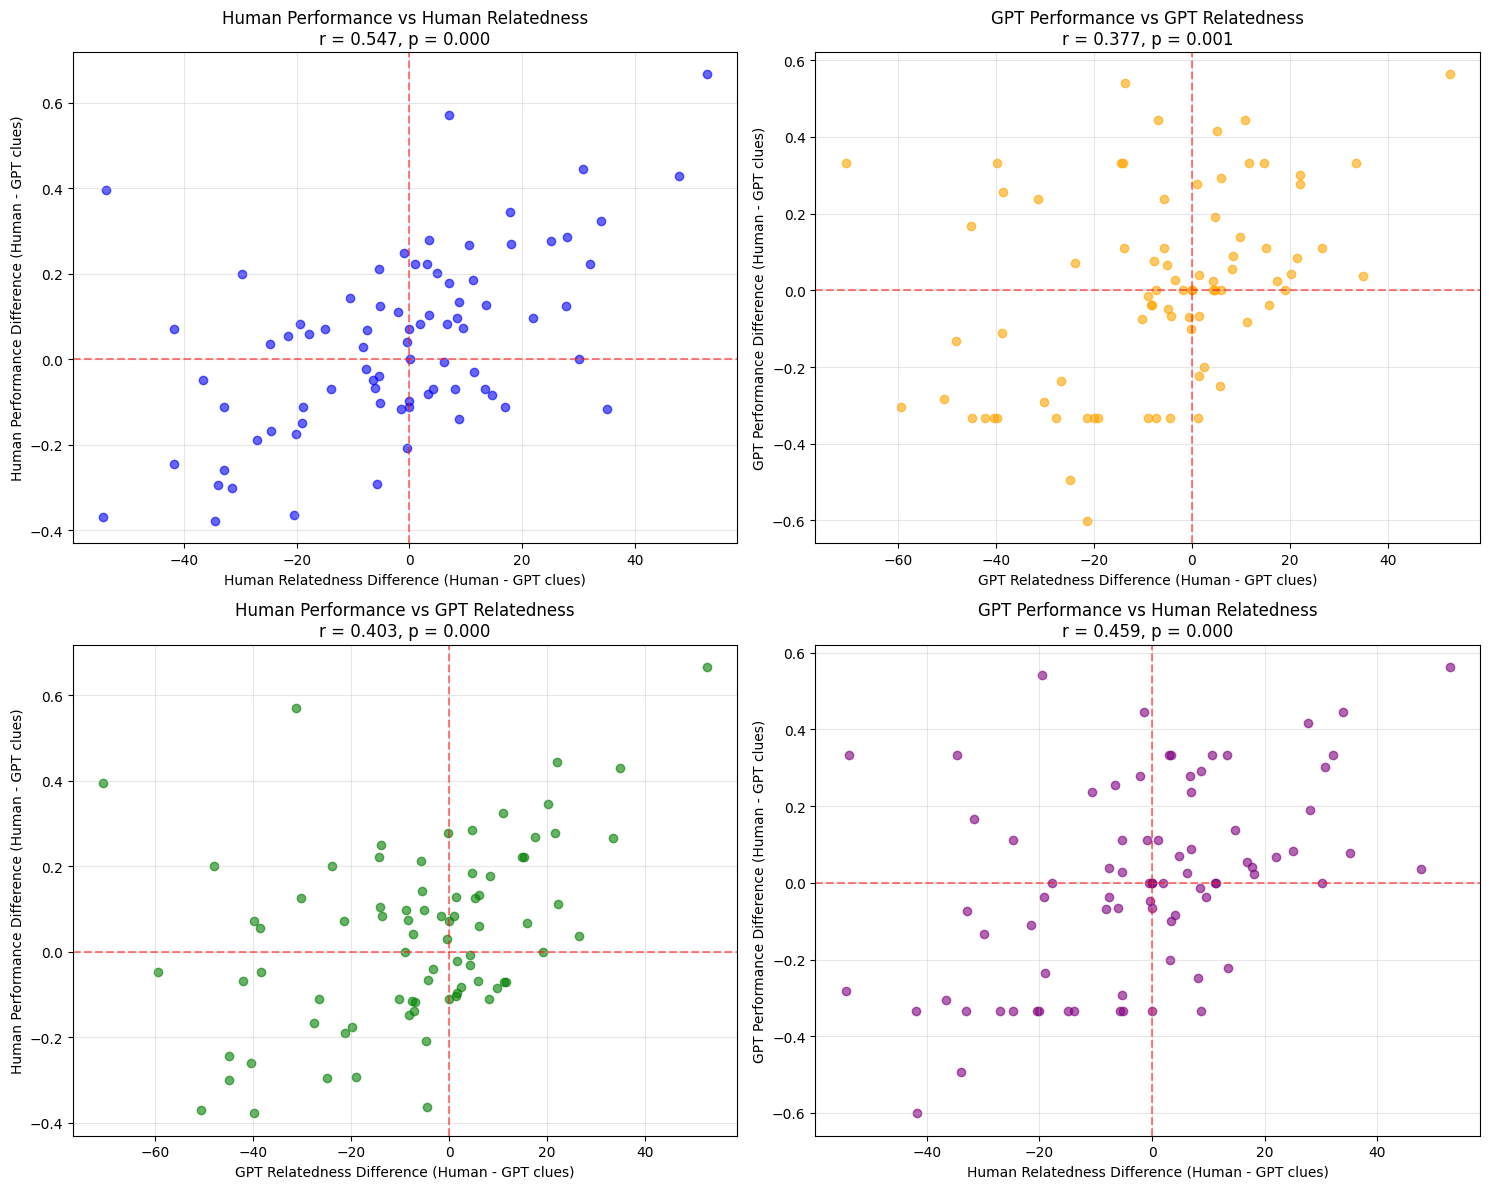

Visualizations created successfully!

ANALYSIS SUMMARY
total_boards: 400
boards_with_relatedness: 80
human_better_on_human_all: 239
human_better_on_gpt_all: 145
human_better_on_human_rel: 43
human_better_on_gpt_rel: 35


{'total_boards': 400,
 'boards_with_relatedness': 80,
 'human_better_on_human_all': 239,
 'human_better_on_gpt_all': 145,
 'human_better_on_human_rel': 43,
 'human_better_on_gpt_rel': 35}

In [ ]:
boards_data, relatedness_data = load_data()

comprehensive_codenames_analysis(boards_data, relatedness_data)

In [ ]:
def calculate_average_responses(data):

    total_responses = 0
    total_boards = 0
    
    for board_key, board_data in data.items():
        if 'human_guess_human_clue' in board_data:
            num_responses = len(board_data['human_guess_human_clue'])
            total_responses += num_responses
            total_boards += 1
            print(f"Board: {len(board_data['words'])} words - Human responses: {num_responses}")
    
    if total_boards > 0:
        average = total_responses / total_boards
        print(f"\nTotal boards: {total_boards}")
        print(f"Total Human responses: {total_responses}")
        print(f"Average Human responses per board: {average:.2f}")
        return average
    else:
        print("No valid boards found")
        return 0
    



In [ ]:

def count_by_source(relatedness_data):
    """
    Count judgments separately by source (human vs gpt).
    """
    source_counts = defaultdict(int)
    source_pairs = defaultdict(set)
    
    for entry in relatedness_data:
        if not all(key in entry for key in ['clue', 'word', 'source', 'relatedness']):
            continue
            
        clue = entry['clue']
        word = entry['word']
        source = entry['source']
        relatedness = entry['relatedness']
        
        if relatedness is None:
            continue
            
        pair_key = (clue, word)
        source_pairs[source].add(pair_key)
        
        if isinstance(relatedness, list):
            source_counts[source] += len(relatedness)
        elif isinstance(relatedness, (int, float)):
            source_counts[source] += 1
    
    print(f"\n=== BY SOURCE ===")
    for source in source_counts:
        unique_pairs = len(source_pairs[source])
        total_judgments = source_counts[source]
        avg_per_pair = total_judgments / unique_pairs if unique_pairs > 0 else 0
        print(f"{source.upper()}: {total_judgments} judgments across {unique_pairs} pairs (avg: {avg_per_pair:.2f} per pair)")


In [ ]:
count_by_source(relatedness_data)


=== BY SOURCE ===
GPT: 48000 judgments across 8471 pairs (avg: 5.67 per pair)
HUMAN: 11268 judgments across 1852 pairs (avg: 6.08 per pair)


In [ ]:
calculate_average_responses(boards_data)

Board: 12 words - Human responses: 12
Board: 12 words - Human responses: 6
Board: 12 words - Human responses: 14
Board: 12 words - Human responses: 10
Board: 12 words - Human responses: 10
Board: 12 words - Human responses: 13
Board: 12 words - Human responses: 8
Board: 12 words - Human responses: 10
Board: 12 words - Human responses: 11
Board: 12 words - Human responses: 9
Board: 12 words - Human responses: 16
Board: 12 words - Human responses: 12
Board: 12 words - Human responses: 12
Board: 12 words - Human responses: 10
Board: 12 words - Human responses: 7
Board: 12 words - Human responses: 9
Board: 12 words - Human responses: 9
Board: 12 words - Human responses: 11
Board: 12 words - Human responses: 11
Board: 12 words - Human responses: 11
Board: 12 words - Human responses: 9
Board: 12 words - Human responses: 10
Board: 12 words - Human responses: 6
Board: 12 words - Human responses: 16
Board: 12 words - Human responses: 11
Board: 12 words - Human responses: 9
Board: 12 words - Hum

10.0225